# To-Do
Avg. CV IKI by word type (WF and BF)  
Words with highest/lowest CV IKI  
Bigrams with highest/lowest CV IKI  
Difference between avg. CV IKI by word type between individuals  



make extra figures into a separate document  
put stats under header for each type of analysis  
put MRS analysis in different document

In [1]:
import os
import numpy as np
import pandas as pd
import math
import glob
import statistics as stat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
from scipy.stats import variation
from scipy.stats import wilcoxon
from scipy.stats import pearsonr
import warnings
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sb
import pingouin as pg
import itertools as it
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('ignore')

import typingmod as typ

# DATAFRAME SETUP AND FUNCTIONS
___

In [2]:
# Setting save directory
save_dir = os.getcwd()
save_dir

'/Users/rubi/Desktop/Github/typingexp/typing_task_analysis'

In [3]:
# test = all_trials[(all_trials['sID'] == 's210') 
#        & (all_trials['key_resp.rt.10'] != 0)]
# test
# # print(ID_list)

In [4]:
## Creating dataframes of all trials and bigrams collected across all subjects

# Getting subject data folders from server
server = r'/Volumes/greenhouse/typingtask_data/subject_data'
os.chdir(server)
folders = os.listdir()

# Looping through subject folders, getting appropriate paths to data, 
# and making sID list
sub_folders = list(filter(lambda x: x.startswith('s', 0, 1), folders))
all_bytrial = []
all_bybigram = []
ID_list = []
for sub in sub_folders:
    sub_folder = r'/Volumes/greenhouse/typingtask_data/'\
                 'subject_data/%s/psychopy_data/edited' % sub
    os.chdir(sub_folder)
    sID = sub.split('_', 1)[0]
    bytrial = pd.read_csv(glob.glob('*_bytrial.csv')[0])
    bybigram = pd.read_csv(glob.glob('*_bybigram.csv')[0])
    all_bytrial.append(bytrial)
    all_bybigram.append(bybigram)
    ID_list.append(sID)

# Makes list of folders for subjects without turbo typing data
server_noturbo = r'/Volumes/greenhouse/typingtask_data/subject_data/'\
                 'not_used/no_turbotyping/'
os.chdir(server_noturbo)
folders_noturbo = os.listdir()
sub_folders_noturbo = list(filter(lambda x: x.startswith('s', 0, 1), 
                                  folders_noturbo))

# Gets data from subjects without turbotyping
for sub in sub_folders_noturbo:
    sub_folder = server_noturbo + r'%s/psychopy_data/edited' % sub
    os.chdir(sub_folder)
    sID = sub.split('_', 1)[0]
    bytrial = pd.read_csv(glob.glob('*_bytrial.csv')[0])
    bybigram = pd.read_csv(glob.glob('*_bybigram.csv')[0])
    all_bytrial.append(bytrial)
    all_bybigram.append(bybigram)
    ID_list.append(sID)

# Concatenating all trial-based dataframes
all_trials = pd.concat(all_bytrial).reset_index(drop=True)
all_trials.drop(columns = ['Unnamed: 0'], inplace = True)
all_trials = all_trials.sort_values(by=['sID', 
                                        'trial_num', 
                                        'rep_num']).reset_index(drop = True)

# Adding IKI columns
all_rts = typ.rt_columns(all_trials)
all_trials = pd.concat([all_trials, typ.iki(all_rts).drop(columns=['string'])], 
                       axis = 1)

# Changing column names to identify they are IKI values
change = {}
for col in all_trials.columns:
    if isinstance(col, int):
        change[col] = 'iki_' + str(int(col)+1)
all_trials = all_trials.rename(columns=change)

# Concatenating all bigram-based dataframes
all_bigrams = pd.concat(all_bybigram).reset_index(drop=True)
all_bigrams = all_bigrams.sort_values(by=['sID'])
all_bigrams.drop(columns = ['Unnamed: 0'], inplace = True)
all_bigrams = all_bigrams.sort_values(by=['sID', 
                                          'trial_num', 
                                          'rep_num', 
                                          'bigram_loc'])

# Sorting ID list by ascending value
ID_list.sort()

12


In [5]:
# Checking how many participants
len(ID_list)

38

In [6]:
## keep ?? 

np.seterr(invalid='ignore') ## gets rid of runtime error about invalid division

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [7]:
# # Function to filter dataframes by correct or incorrect trial or bigrams
# def corr_filter(dataframe, tri_or_bg, corr_or_incorr):
#     if (tri_or_bg == 'tri') and (corr_or_incorr == 'corr'):
#         DF = (dataframe[dataframe.string 
#                == dataframe.resp_string]).reset_index(drop=True)
#     elif (tri_or_bg == 'tri') and (corr_or_incorr == 'incorr'):
#         DF = (dataframe[dataframe.string 
#                  != dataframe.resp_string]).reset_index(drop=True)
#     elif (tri_or_bg == 'bg') and (corr_or_incorr == 'corr'):
#         DF = (all_bigrams[all_bigrams.bigram 
#             == all_bigrams.resp_bigram]).reset_index(drop=True)
#     elif (tri_or_bg == 'bg') and (corr_or_incorr == 'incorr'):
#         DF = (all_bigrams[all_bigrams.bigram 
#               != all_bigrams.resp_bigram]).reset_index(drop=True)
#     else: print('''Please write "tri" or "bg" for tri_or_bg variable and/or
#                 "corr" or "incorr" for corr_or_incorr variable.''')
        

In [8]:
# Making filtered dataframes by errors
corr_trials = (all_trials[all_trials.string 
               == all_trials.resp_string]).reset_index(drop=True)
incorr_trials = (all_trials[all_trials.string 
                 != all_trials.resp_string]).reset_index(drop=True)

corr_trials_bybg = (all_bigrams[all_bigrams.string 
                    == all_bigrams.resp_string]).reset_index(drop=True)
incorr_trials_bybg = (all_bigrams[all_bigrams.string 
                      != all_bigrams.resp_string]).reset_index(drop=True)

# Excludes only incorrect bigrams 
corr_bgs = (all_bigrams[all_bigrams.bigram 
            == all_bigrams.resp_bigram]).reset_index(drop=True) 
incorr_bgs = (all_bigrams[all_bigrams.bigram 
              != all_bigrams.resp_bigram]).reset_index(drop=True)

corr_rts = typ.rt_columns(corr_trials)
incorr_rts = typ.rt_columns(incorr_trials)

# Making dataframe with only correct trials that have ikis 
# within 2sd of the inividuals mean iki (iki is by posiiton)
tight_trials = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials[corr_trials.sID == subject]
    for col in sub_df.columns:
        if col.startswith('iki_'):
            avg_iki = sub_df[col].mean()
            sd_iki = sub_df[col].std()
            sub_df = sub_df[(sub_df[col] < (avg_iki + 2*sd_iki)) 
                     & (sub_df[col] > (avg_iki - 2*sd_iki))]
    tight_trials = pd.concat([tight_trials, sub_df])

# Making dataframe with only correct bigrams that have ikis 
# within 2sd of the individuals mean iki (across all ikis)
tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials_bybg[corr_trials_bybg.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) 
             & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    tight_bgs = pd.concat([tight_bgs, sub_df])
    
# Making dataframe with both correct and incorrect bigrams 
# that have ikis within 2sd
all_tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = all_bigrams[all_bigrams.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) 
             & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    all_tight_bgs = pd.concat([all_tight_bgs, sub_df])

In [190]:
# Defining functions that calculate individual IKI means and CVs for a 
# particular bigram in a defined string.

##### These need to be edited to include changable dataframe like the other functions

def indiv_means_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean']))
    return means

def indiv_cvs_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    cvs = pd.DataFrame(DF.groupby('sID').IKI.agg([variation]))
    return cvs

# Defining functions that calculate indivdual IKI means, mean CVs, 
# and mean SDs by word and bigram groupings
def indiv_means(dataframe, str_or_bg, sort_type): ## str_or_bg can be 'string' or 'bigram'
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg IKI'})
    # means['wf_type'] = get_var_name(sort_type)
    if sort_type == typ.highbf:
        means['bf_type'] = 'high'
    elif sort_type == typ.medbf:
        means['bf_type'] = 'med'
    elif sort_type == typ.lowbf:
        means['bf_type'] = 'low'
    return means

def indiv_avgcvs(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    else:
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    cvs = DF.groupby(['sID', str_or_bg]).IKI.agg([variation])
    avg_cvs = pd.DataFrame(cvs.groupby('sID').variation.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg CV IKI'})
    # avg_cvs.columns = ['Avg CV IKI']
    return avg_cvs

def indiv_avgsds(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    else:
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    sds = DF.groupby(['sID', str_or_bg]).IKI.agg(['std'])
    sds = sds.rename(columns={'std':'sd'})
    avg_sds = pd.DataFrame(sds.groupby('sID').sd.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg SD IKI'})
    # avg_sds.columns = ['Avg SD IKI']
    return avg_sds

def indiv_error(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    else:
        print('please write "string" or "bigram" for str_or_bg variable')
    errs = pd.DataFrame(DF.groupby(['sID']).size()).reset_index().rename(columns = {0:'Total Error'})
    for ID in dataframe.sID.unique():
        if ID not in list(errs['sID']):
            # no_err_ID = [ID, 0]
            errs.loc[len(errs.index)] = [ID, 0]
            errs = errs.sort_values('sID', ignore_index=True)
    return errs

In [10]:
## Making dataframe of IKI stats
bg_stats = pd.DataFrame()
for index, bg in enumerate(typ.bg_freqs['Bigrams']):
    bg_stats.loc[index, 'Bigram'] = bg
    df = corr_trials_bybg[corr_trials_bybg['bigram'] == bg].reset_index()
    bg_stats.loc[index, 'Mean'] = df['IKI'].mean()
    bg_stats.loc[index, 'SD'] = np.std(df['IKI'])
    bg_stats.loc[index, 'CV'] = variation(df['IKI'], nan_policy='omit')
    bg_stats.loc[index, 'Frequency'] = typ.bg_freqs.loc[index, 'Frequency']
    bg_stats.loc[index, 'bf_type'] = df.loc[1, 'bf_type']
    
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(bg_stats)
# bg_stats

In [11]:
## making data frames with for individual stats for each bigram
cvs = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg([variation])).reset_index()
for index, bg in enumerate(cvs['bigram']):
    if bg in list(typ.highbf):
        cvs.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        cvs.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        cvs.loc[index, 'bf_type'] = 'Low'     

sds = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['std'])).reset_index()
for index, bg in enumerate(sds['bigram']):
    if bg in list(typ.highbf):
        sds.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        sds.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        sds.loc[index, 'bf_type'] = 'Low' 

ikis = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['mean'])).reset_index()
for index, bg in enumerate(ikis['bigram']):
    if bg in list(typ.highbf):
        ikis.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        ikis.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        ikis.loc[index, 'bf_type'] = 'Low'

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(ikis)

In [12]:
## making lists of bigrams without bigrams with repeated letters
med_reps = ['ll', 'ee', 'oo', 'pp']    
medbf_norep = list(filter(lambda x: x not in med_reps, typ.medbf))

typ.lowbf
low_reps = ['dd', 'kk']
lowbf_norep = list(filter(lambda x: x not in low_reps, typ.lowbf))

In [13]:
# corr_trials_bybg.groupby('wf_type').IKI.count()

corr_trials_bybg[corr_trials_bybg['IKI'] >= 1].groupby('bf_type').count()

sID  bigram_num  trial_num  rep_num  bigram_loc  bigram  resp_bigram  \
bf_type                                                                         
high      11          11         11       11          11      11           11   
low       24          24         24       24          24      24           24   
med        3           3          3        3           3       3            3   

         IKI  string  resp_string  bg_freq  meanbf_type  wf_type  trial_corr  \
bf_type                                                                        
high      11      11           11       11           11       11           6   
low       24      24           24       24           24       24          15   
med        3       3            3        3            3        3           3   

         bg_corr  
bf_type           
high           6  
low           15  
med            3

# STATS
___

In [185]:
high_iki = indiv_means(corr_trials_bybg, 'bigram', typ.highbf)
high_iki['bf_type'] = 'high'
med_iki = indiv_means(corr_trials_bybg, 'bigram', typ.medbf)
med_iki['bf_type'] = 'med'
low_iki = indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)
low_iki['bf_type'] = 'low'

print(stat.stdev(high_iki['Avg IKI']))
print(stat.stdev(med_iki['Avg IKI']))
print(stat.stdev(low_iki['Avg IKI']))

0.03567117652419928
0.03462750448565023
0.04404790347385392


In [186]:
## anova for means (by bg freq)
high_iki = indiv_means(corr_trials_bybg, 'bigram', typ.highbf)
high_iki['bf_type'] = 'high'
med_iki = indiv_means(corr_trials_bybg, 'bigram', typ.medbf)
med_iki['bf_type'] = 'med'
low_iki = indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)
low_iki['bf_type'] = 'low'

ikis = pd.concat([high_iki, med_iki, low_iki], ignore_index=True)
# print(ikis)

iki_anova = pg.rm_anova(ikis, 'Avg IKI', 'bf_type', 'sID')
print(iki_anova)

pg.pairwise_tukey(ikis, 'Avg IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  bf_type      2     68  171.31415  2.805700e-27  0.299258  0.816495


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T       p-tukey  \
0  high  low  0.143146  0.203503 -0.060357  0.009167 -6.584215  6.047532e-09   
1  high  med  0.143146  0.169703 -0.026558  0.009167 -2.897121  1.269945e-02   
2   low  med  0.203503  0.169703  0.033799  0.009167  3.687094  1.057426e-03   

      cohen  
0 -1.505953  
1 -0.755485  
2  0.853116

In [16]:
## anova for means (by avg bg freq)
high_iki = indiv_means(corr_trials_bybg, 'string', typ.avg_highbf)
high_iki['bf_type'] = 'high'
med_iki = indiv_means(corr_trials_bybg, 'string', typ.avg_medbf)
med_iki['bf_type'] = 'med'
low_iki = indiv_means(corr_trials_bybg, 'string', typ.avg_lowbf)
low_iki['bf_type'] = 'low'

ikis = pd.concat([high_iki, med_iki, low_iki], ignore_index=True)
# print(ikis)

iki_anova = pg.rm_anova(ikis, 'Avg IKI', 'bf_type', 'sID')
print(iki_anova)

pg.pairwise_tukey(ikis, 'Avg IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2           F         p-unc       ng2       eps
0  bf_type      2     68  240.433545  1.456862e-31  0.333882  0.703558


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T       p-tukey  \
0  high  low  0.144400  0.206467 -0.062067  0.008996 -6.899729  1.347457e-09   
1  high  med  0.144400  0.160817 -0.016418  0.008996 -1.825088  1.665616e-01   
2   low  med  0.206467  0.160817  0.045650  0.008996  5.074642  5.208643e-06   

      cohen  
0 -1.605187  
1 -0.477312  
2  1.152040

In [196]:
## anova for means (by word freq)
# only_onebf = corr_trials_bybg[corr_trials_bybg.bf_type == 'low']

high_iki = indiv_means(corr_trials_bybg, 'string', typ.highwf)
high_iki['wf_type'] = 'high'
med_iki = indiv_means(corr_trials_bybg, 'string', typ.medwf)
med_iki['wf_type'] = 'med'
low_iki = indiv_means(corr_trials_bybg, 'string', typ.lowwf)
low_iki['wf_type'] = 'low'
pseudo_iki = indiv_means(corr_trials_bybg, 'string', typ.pseudo)
pseudo_iki['wf_type'] = 'pseudo'

## printing standard deviations for each grouping
print(stat.stdev(pseudo_iki['Avg IKI']))
print(stat.stdev(low_iki['Avg IKI']))
print(stat.stdev(med_iki['Avg IKI']))
print(stat.stdev(high_iki['Avg IKI']))

ikis = pd.concat([high_iki, med_iki, low_iki, pseudo_iki], ignore_index=True)
# print(ikis)

iki_anova = pg.rm_anova(ikis, 'Avg IKI', 'wf_type', 'sID')
print(iki_anova)

pg.pairwise_tukey(ikis, 'Avg IKI', 'wf_type', effsize='cohen')

0.0429767908799934
0.04057496001463618
0.034737988956114095
0.03408494280893879
    Source  ddof1  ddof2          F         p-unc      ng2       eps
0  wf_type      3    102  31.457888  1.762405e-14  0.08367  0.713122


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low  0.155227  0.180784 -0.025557  0.009151 -2.792777  0.030116   
1  high     med  0.155227  0.163313 -0.008085  0.009151 -0.883554  0.813395   
2  high  pseudo  0.155227  0.181877 -0.026650  0.009151 -2.912232  0.021578   
3   low     med  0.180784  0.163313  0.017471  0.009151  1.909223  0.229012   
4   low  pseudo  0.180784  0.181877 -0.001093  0.009151 -0.119455  0.999388   
5   med  pseudo  0.163313  0.181877 -0.018564  0.009151 -2.028678  0.182594   

      cohen  
0 -0.682044  
1 -0.234952  
2 -0.687089  
3  0.462578  
4 -0.026156  
5 -0.475095

In [18]:
## anova for cvs (by bg freq)
high_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)
high_cv['bf_type'] = 'high'
med_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)
med_cv['bf_type'] = 'med'
low_cv = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)
low_cv['bf_type'] = 'low'

cvs = pd.concat([high_cv, med_cv, low_cv], ignore_index=True)
# print(cvs)

cv_anova = pg.rm_anova(cvs, 'Avg CV IKI', 'bf_type', 'sID')
print(cv_anova)

pg.pairwise_tukey(cvs, 'Avg CV IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  bf_type      2     68  17.215806  8.923738e-07  0.127839  0.735831


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  0.270311  0.262188  0.008123  0.013921  0.583532  0.829235   
1  high  med  0.270311  0.220169  0.050142  0.013921  3.602018  0.001412   
2   low  med  0.262188  0.220169  0.042019  0.013921  3.018486  0.008931   

      cohen  
0  0.128276  
1  0.815984  
2  0.859971

In [19]:
## anova for cvs (by avg bg freq)
high_cv = indiv_avgcvs(corr_trials_bybg, 'string', typ.avg_highbf)
high_cv['bf_type'] = 'high'
med_cv = indiv_avgcvs(corr_trials_bybg, 'string', typ.avg_medbf)
med_cv['bf_type'] = 'med'
low_cv = indiv_avgcvs(corr_trials_bybg, 'string', typ.avg_lowbf)
low_cv['bf_type'] = 'low'

cvs = pd.concat([high_cv, med_cv, low_cv], ignore_index=True)
# print(cvs)

cv_anova = pg.rm_anova(cvs, 'Avg CV IKI', 'bf_type', 'sID')
print(cv_anova)

pg.pairwise_tukey(cvs, 'Avg CV IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F     p-unc       ng2       eps
0  bf_type      2     68  15.042432  0.000004  0.085235  0.925533


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  0.361286  0.434601 -0.073315  0.023807 -3.079494  0.007451   
1  high  med  0.361286  0.400912 -0.039626  0.023807 -1.664432  0.223880   
2   low  med  0.434601  0.400912  0.033689  0.023807  1.415062  0.336972   

      cohen  
0 -0.755707  
1 -0.379926  
2  0.346252

In [165]:
## anova for cvs (by word freq)

high_iki = indiv_avgcvs(corr_trials_bybg, 'string', typ.highwf)
high_iki['wf_type'] = 'high'
med_iki = indiv_avgcvs(corr_trials_bybg, 'string', typ.medwf)
med_iki['wf_type'] = 'med'
low_iki = indiv_avgcvs(corr_trials_bybg, 'string', typ.lowwf)
low_iki['wf_type'] = 'low'
pseudo_iki = indiv_avgcvs(corr_trials_bybg, 'string', typ.pseudo)
pseudo_iki['wf_type'] = 'pseudo'

ikis = pd.concat([high_iki, med_iki, low_iki, pseudo_iki], ignore_index=True)
# print(ikis)

iki_anova = pg.rm_anova(ikis, 'Avg CV IKI', 'wf_type', 'sID')
print(iki_anova)

pg.pairwise_tukey(ikis, 'Avg CV IKI', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc     p-GG-corr       ng2  \
0  wf_type      3    102  16.082074  1.238644e-08  2.181322e-07  0.117459   

        eps  sphericity   W-spher   p-spher  
0  0.809836       False  0.685876  0.030509  


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low  0.360396  0.407545 -0.047149  0.024952 -1.889560  0.237352   
1  high     med  0.360396  0.371306 -0.010910  0.024952 -0.437243  0.971926   
2  high  pseudo  0.360396  0.456486 -0.096090  0.024952 -3.850948  0.001026   
3   low     med  0.407545  0.371306  0.036239  0.024952  1.452317  0.469212   
4   low  pseudo  0.407545  0.456486 -0.048941  0.024952 -1.961388  0.207845   
5   med  pseudo  0.371306  0.456486 -0.085180  0.024952 -3.413706  0.004638   

      cohen  
0 -0.463229  
1 -0.104321  
2 -0.892332  
3  0.358891  
4 -0.469762  
5 -0.796672

In [199]:
## anova for sds (by bg freq)
high_sd = indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)
high_sd['bf_type'] = 'high'
med_sd = indiv_avgsds(corr_trials_bybg, 'bigram', medbf_norep)
med_sd['bf_type'] = 'med'
low_sd = indiv_avgsds(corr_trials_bybg, 'bigram', lowbf_norep)
low_sd['bf_type'] = 'low'

## printing standard devs of each bg category
print(stat.stdev(low_sd['Avg SD IKI']))
print(stat.stdev(med_sd['Avg SD IKI']))
print(stat.stdev(high_sd['Avg SD IKI']))

sds = pd.concat([high_sd, med_sd, low_sd], ignore_index=True)
# print(sds)

sd_anova = pg.rm_anova(sds, 'Avg SD IKI', 'bf_type', 'sID')
print(sd_anova)

pg.pairwise_tukey(sds, 'Avg SD IKI', 'bf_type', effsize='cohen')

0.021608912227966234
0.017659712697981465
0.024594147834404514
    Source  ddof1  ddof2          F         p-unc       ng2    eps
0  bf_type      2     68  30.881369  2.872123e-10  0.171495  0.689


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  0.044687  0.065254 -0.020567  0.005134 -4.006261  0.000343   
1  high  med  0.044687  0.044966 -0.000279  0.005134 -0.054435  0.998368   
2   low  med  0.065254  0.044966  0.020288  0.005134  3.951826  0.000418   

      cohen  
0 -0.888449  
1 -0.014162  
2  0.947608

In [22]:
## anova for sds (by avg bg freq)
high_sd = indiv_avgsds(corr_trials_bybg, 'string', typ.avg_highbf)
high_sd['bf_type'] = 'high'
med_sd = indiv_avgsds(corr_trials_bybg, 'string', typ.avg_medbf)
med_sd['bf_type'] = 'med'
low_sd = indiv_avgsds(corr_trials_bybg, 'string', typ.avg_lowbf)
low_sd['bf_type'] = 'low'

sds = pd.concat([high_sd, med_sd, low_sd], ignore_index=True)
# print(sds)

sd_anova = pg.rm_anova(sds, 'Avg SD IKI', 'bf_type', 'sID')
print(sd_anova)

pg.pairwise_tukey(sds, 'Avg SD IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  bf_type      2     68  60.448042  8.198277e-16  0.249097  0.771458


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T       p-tukey  \
0  high  low  0.055846  0.096312 -0.040466  0.007162 -5.650056  4.363132e-07   
1  high  med  0.055846  0.067500 -0.011653  0.007162 -1.627108  2.389434e-01   
2   low  med  0.096312  0.067500  0.028812  0.007162  4.022949  3.230817e-04   

      cohen  
0 -1.296698  
1 -0.443593  
2  0.898214

In [23]:
## anova for sds (by word freq)
high_iki = indiv_avgsds(corr_trials_bybg, 'string', typ.highwf)
high_iki['wf_type'] = 'high'
med_iki = indiv_avgsds(corr_trials_bybg, 'string', typ.medwf)
med_iki['wf_type'] = 'med'
low_iki = indiv_avgsds(corr_trials_bybg, 'string', typ.lowwf)
low_iki['wf_type'] = 'low'
pseudo_iki = indiv_avgsds(corr_trials_bybg, 'string', typ.pseudo)
pseudo_iki['wf_type'] = 'pseudo'

ikis = pd.concat([high_iki, med_iki, low_iki, pseudo_iki], ignore_index=True)
# print(ikis)

iki_anova = pg.rm_anova(ikis, 'Avg SD IKI', 'wf_type', 'sID')
print(iki_anova)

pg.pairwise_tukey(ikis, 'Avg SD IKI', 'wf_type', effsize='cohen')

/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3    102  23.782738  9.467125e-12  0.143853  0.783021


A       B   mean(A)   mean(B)      diff       se         T   p-tukey  \
0  high     low  0.057756  0.081480 -0.023725  0.00741 -3.201552  0.009126   
1  high     med  0.057756  0.064694 -0.006938  0.00741 -0.936297  0.785390   
2  high  pseudo  0.057756  0.088948 -0.031192  0.00741 -4.209200  0.000268   
3   low     med  0.081480  0.064694  0.016786  0.00741  2.265255  0.111394   
4   low  pseudo  0.081480  0.088948 -0.007467  0.00741 -1.007648  0.745221   
5   med  pseudo  0.064694  0.088948 -0.024254  0.00741 -3.272903  0.007299   

      cohen  
0 -0.783897  
1 -0.280067  
2 -1.062647  
3  0.515496  
4 -0.206445  
5 -0.764669

In [24]:
## anova for error rates (by bg freq)
high_err = indiv_error(incorr_bgs, 'bigram', typ.highbf)
high_err['bf_type'] = 'high'
med_err = indiv_error(incorr_bgs, 'bigram', typ.medbf)
med_err['bf_type'] = 'med'
low_err = indiv_error(incorr_bgs, 'bigram', typ.lowbf)
low_err['bf_type'] = 'low'

errs = pd.concat([high_err, med_err, low_err], ignore_index=True)

err_anova = pg.rm_anova(errs, 'Total Error', 'bf_type', 'sID')
print(err_anova)

# pg.pairwise_tukey(errs, 'Total Error', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2       eps  \
0  bf_type      2     68  2.308074  0.107195    0.12438  0.019072  0.722959   

   sphericity   W-spher   p-spher  
0       False  0.616796  0.000345  


In [25]:
## anova for error rates (by avg bg freq)
high_err = indiv_error(incorr_trials, 'string', typ.avg_highbf)
high_err['bf_type'] = 'high'
med_err = indiv_error(incorr_trials, 'string', typ.avg_medbf)
med_err['bf_type'] = 'med'
low_err = indiv_error(incorr_trials, 'string', typ.avg_lowbf)
low_err['bf_type'] = 'low'

errs = pd.concat([high_err, med_err, low_err], ignore_index=True)

err_anova = pg.rm_anova(errs, 'Total Error', 'bf_type', 'sID')
print(err_anova)

pg.pairwise_tukey(errs, 'Total Error', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2       eps  \
0  bf_type      2     68  6.403559  0.002831   0.006878  0.038163  0.744556   

   sphericity   W-spher   p-spher  
0       False  0.656917  0.000975  


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  5.142857  7.485714 -2.342857  1.166437 -2.008558  0.115298   
1  high  med  5.142857  6.200000 -1.057143  1.166437 -0.906301  0.637582   
2   low  med  7.485714  6.200000  1.285714  1.166437  1.102257  0.514888   

      cohen  
0 -0.484962  
1 -0.239046  
2  0.240691

In [26]:
# def rank_diff(dataframe, str_or_bg, sort_type, rank1, rank2):

In [27]:
## running signed rank test
# wilcoxon()

iki_ranks = (indiv_means(corr_trials_bybg, 'bigram', typ.highbf).sort_values(by = 'Avg IKI', ignore_index = True)) ## ranked by ascending mean IKI
iki_ranks['rank'] = iki_ranks.index
iki_ranks = iki_ranks.sort_values(by = 'sID', ignore_index=True)

cv_ranks = (indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf).sort_values(by = 'Avg SD IKI', ignore_index = True)) ## ranked by ascending mean CV IKI
cv_ranks['rank'] = cv_ranks.index
cv_ranks = cv_ranks.sort_values(by = 'sID', ignore_index=True)

rank_diff = iki_ranks['rank'] - cv_ranks['rank']
rank_diff

wilcoxon(rank_diff)

# ranksums(indiv_means(tight_bgs, 'bigram', typ.highbf)['Avg IKI'], 
#          indiv_avgcvs(tight_bgs, 'bigram', typ.highbf)['Avg CV IKI'])

# ranksums(indiv_means(all_bigrams, 'bigram', typ.highbf)['Avg IKI'],
#          indiv_avgcvs(all_bigrams, 'bigram', typ.highbf)['Avg CV IKI'])

WilcoxonResult(statistic=243.5, pvalue=0.9296778672253653)

In [28]:
skew_df = pd.DataFrame()
for index, ID in enumerate(ID_list):
    skew_df.loc[index, 'sID'] = ID
    skew_df.loc[index, 'skew'] = (corr_bgs[corr_bgs.sID == ID])['IKI'].skew()
    skew_df.loc[index, 'mean IKI'] = (corr_bgs[corr_bgs.sID == ID])['IKI'].mean()
    
skew_df.to_csv('skew_df.csv')
skew_df

sID      skew  mean IKI
0    s09  2.188929  0.129063
1   s175  2.812225  0.191252
2   s176  1.621054  0.204156
3   s178  9.766887  0.155502
4   s180  3.704217  0.132674
5   s181  4.930082  0.116986
6   s182  2.506407  0.169157
7   s183  4.123232  0.160179
8   s189  3.283803  0.173022
9   s190  2.493626  0.161795
10  s198  3.385264  0.160854
11   s20  3.372941  0.188457
12   s20  3.372941  0.188457
13  s207  2.617909  0.166396
14  s209  4.829953  0.135731
15  s209  4.829953  0.135731
16  s210  3.535854  0.177614
17  s212  2.794452  0.171122
18  s217  1.952847  0.137453
19  s217  1.952847  0.137453
20  s219  3.658609  0.248666
21  s224  5.852693  0.149656
22  s240  1.503862  0.152921
23  s254  2.458006  0.267684
24  s261  1.657398  0.137923
25  s262  7.257390  0.129549
26  s263  2.918295  0.182596
27  s267  2.525303  0.207722
28  s276  2.076324  0.170538
29  s278  4.843809  0.168783
30  s279  1.463701  0.240455
31  s282  2.383787  0.245906
32  s283  3.170107  0.157842
33  s286  2.911800  0.199737
34  s302  4.369854  0.163238
35  s304  4.977555  0.134372
36  s305  3.514561  0.130664
37  s306  3.367972  0.167156

In [29]:
## calculating senstivity to individual differences (with weird metric I made up)
# D = pd.concat([indiv_means(corr_trials_bybg, 'bigram', typ.lowbf), 
#      indiv_means(corr_trials_bybg, 'bigram', typ.medbf),
#      indiv_means(corr_trials_bybg, 'bigram', typ.highbf)])

# high_bf

# np.mean(choose2(D['Avg IKI'], operation = abs_difference))
perms = list(it.permutations(indiv_avgsds(corr_trials_bybg, 'bigram', typ.medbf)['Avg SD IKI'], 2))
# for x in perms:
#     abs(x[1] - x[2])

sample_diffs = [abs(x[0] - x[1]) for x in perms]
indiv_sens = np.mean(sample_diffs)/np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.medbf)['Avg SD IKI'])
indiv_sens

0.4098219434685452

In [30]:
## Pearson correlation between low and high bigram freq. Mean IKIs
print(pearsonr(indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)['Avg IKI'], 
         indiv_means(corr_trials_bybg, 'bigram', typ.highbf)['Avg IKI']))

## Pearson correlation between low and high bigram freq. Mean SD IKIs
print(pearsonr(indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)['Avg SD IKI'], 
         indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)['Avg SD IKI']))

## Pearson correlation between low and high bigram freq. Mean SD IKIs
print(pearsonr(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)['Avg CV IKI'], 
         indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)['Avg CV IKI']))

PearsonRResult(statistic=0.8470163978298507, pvalue=1.4130098567076126e-10)
PearsonRResult(statistic=0.535664924471232, pvalue=0.0009125550104781427)
PearsonRResult(statistic=0.5163068314241627, pvalue=0.0014980092635442682)


In [31]:
## Pearson correlation between low and high word freq. Mean IKIs
print(pearsonr(indiv_means(corr_trials_bybg, 'string', typ.pseudo)['Avg IKI'], 
         indiv_means(corr_trials_bybg, 'string', typ.highwf)['Avg IKI']))

## Pearson correlation between low and high word freq. Mean SD IKIs
print(pearsonr(indiv_avgsds(corr_trials_bybg, 'string', typ.pseudo)['Avg SD IKI'], 
         indiv_avgsds(corr_trials_bybg, 'string', typ.highwf)['Avg SD IKI']))

## Pearson correlation between low and high word freq. Mean SD IKIs
print(pearsonr(indiv_avgcvs(corr_trials_bybg, 'string', typ.pseudo)['Avg CV IKI'], 
         indiv_avgcvs(corr_trials_bybg, 'string', typ.highwf)['Avg CV IKI']))

PearsonRResult(statistic=0.8622507885901851, pvalue=2.8195089783740372e-11)
PearsonRResult(statistic=0.739907950345052, pvalue=3.7910030617112845e-07)
PearsonRResult(statistic=0.7412585834572863, pvalue=3.517941467147156e-07)


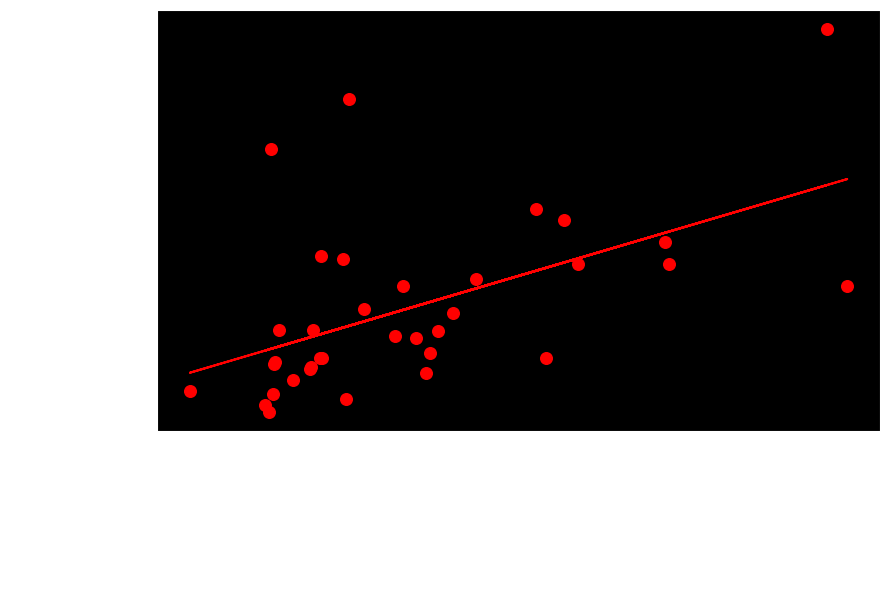

In [32]:
##plotting sd correlation
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)['Avg SD IKI'], 
            indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)['Avg SD IKI'], 
            s = 70, color = 'red')

z = np.polyfit(indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)['Avg SD IKI'], 
               indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)['Avg SD IKI'], 1)
p = np.poly1d(z)
plt.plot(indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)['Avg SD IKI'],
         p(indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)['Avg SD IKI']),
         color = 'red')

plt.xlabel("Mean SD IKI (Low)", fontsize = 30, labelpad=15)
plt.ylabel("Mean SD IKI (High)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
# plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig('SD_correlation_bysub', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

# GRAPHS
___

## Data Visualization
___

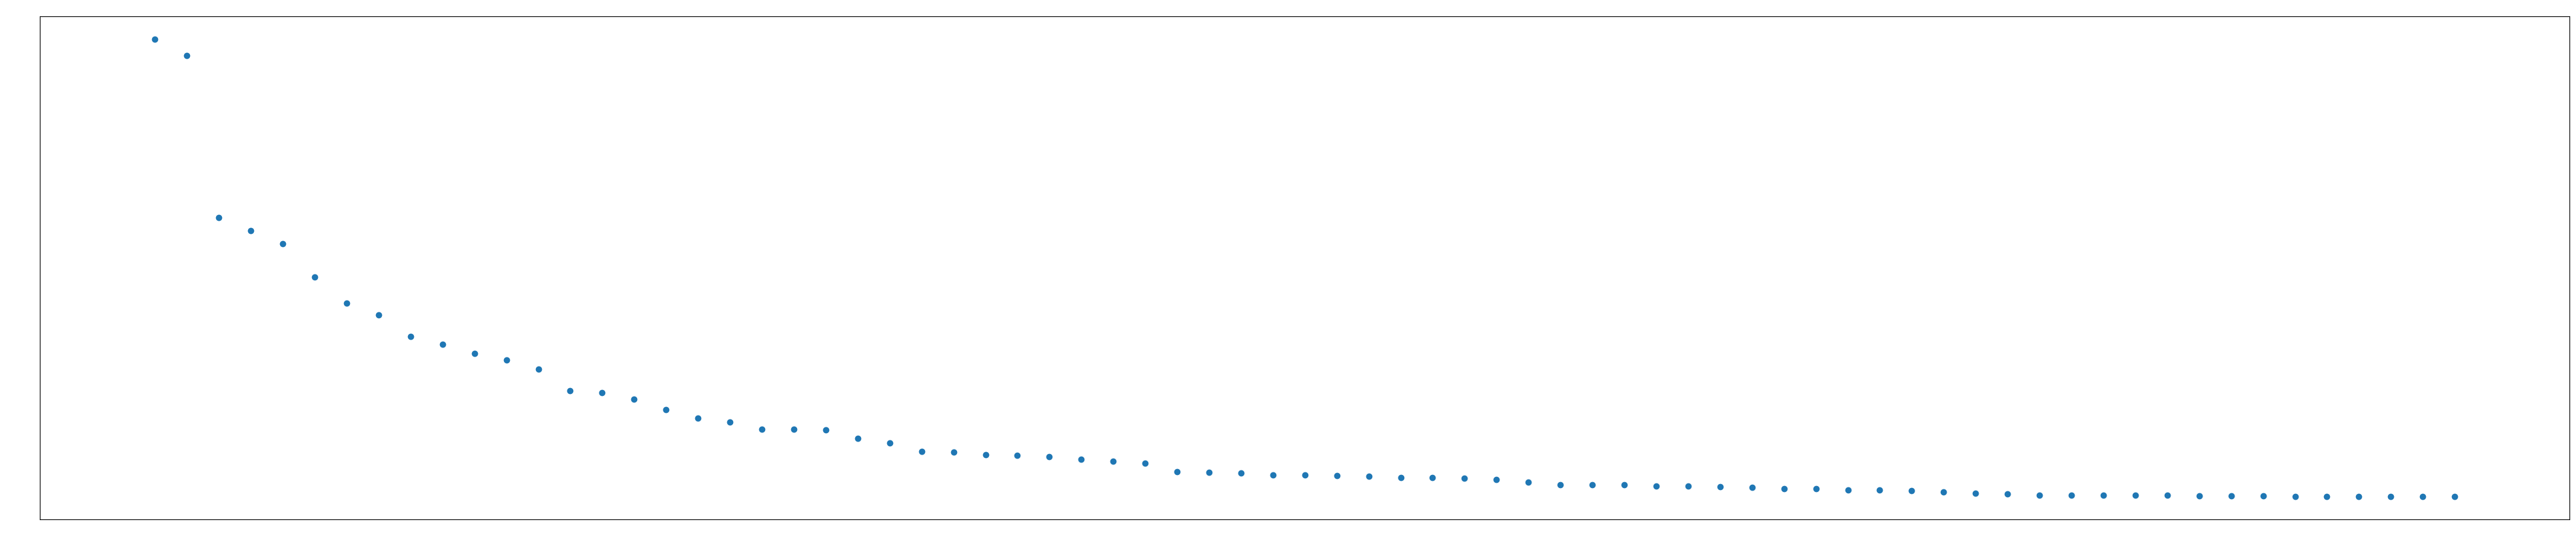

In [33]:
## bigram frequency distribution
plt.figure(figsize=(50, 10))
bg_freq = plt.scatter(typ.bg_freqs['Bigrams'], typ.bg_freqs['Frequency'])

plt.xlabel("Chosen Bigrams")
plt.ylabel("Bigram Freq.")
plt.title("")

plt.show()

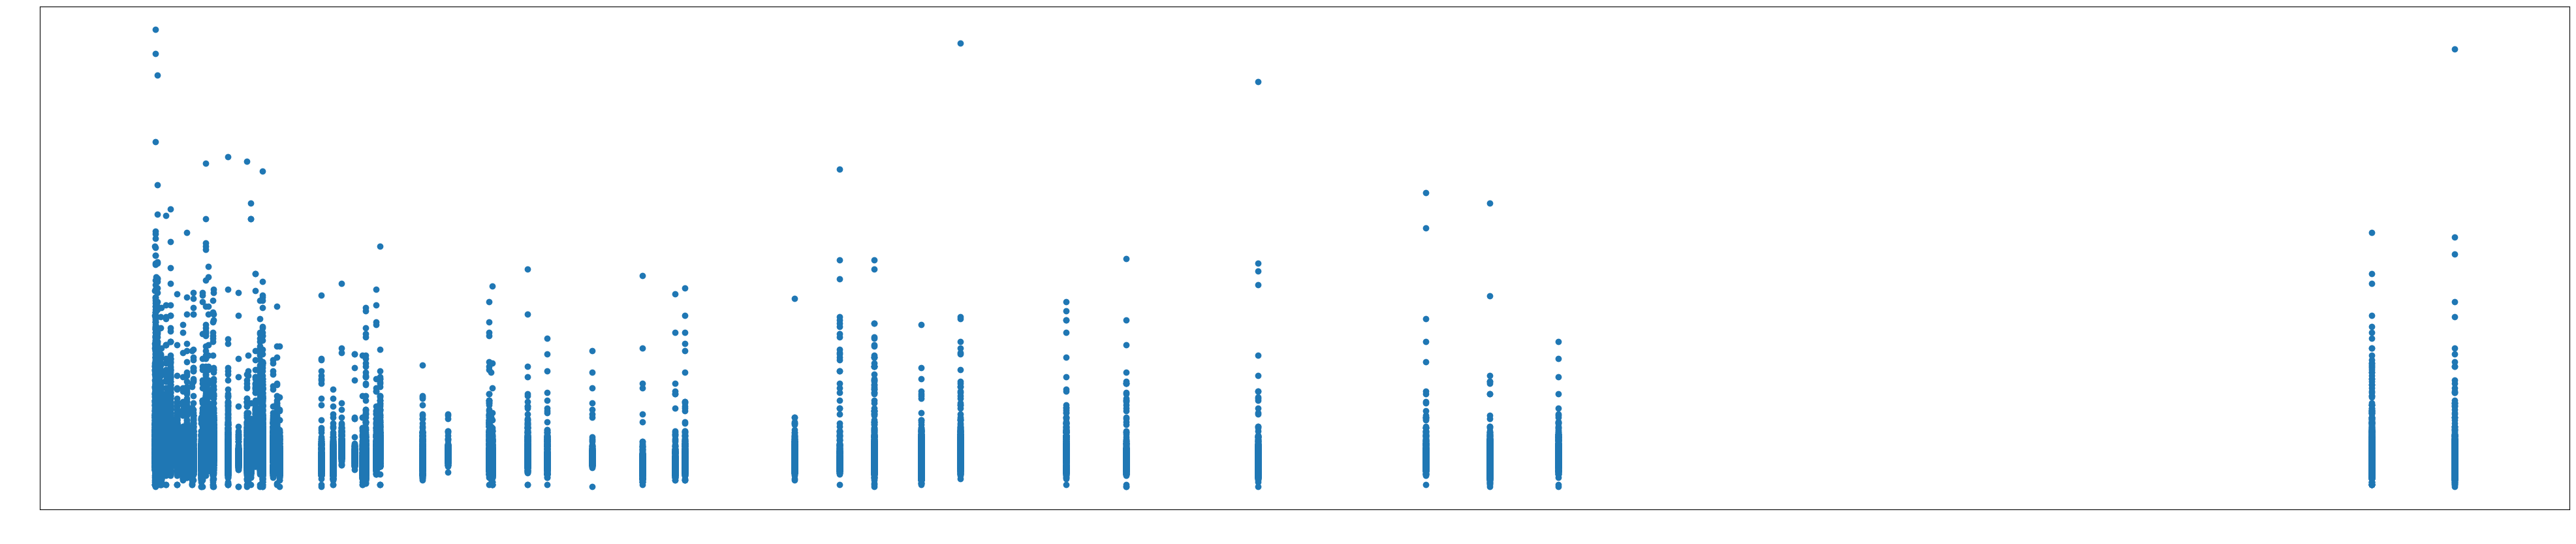

In [34]:
## IKI by Bigram Frequency
plt.figure(figsize=(50, 10))
bg_freq = plt.scatter(all_bigrams['bg_freq'], all_bigrams['IKI'])

plt.ylabel("IKI")
plt.xlabel("Bigram Freq.")
plt.title("")

plt.show()

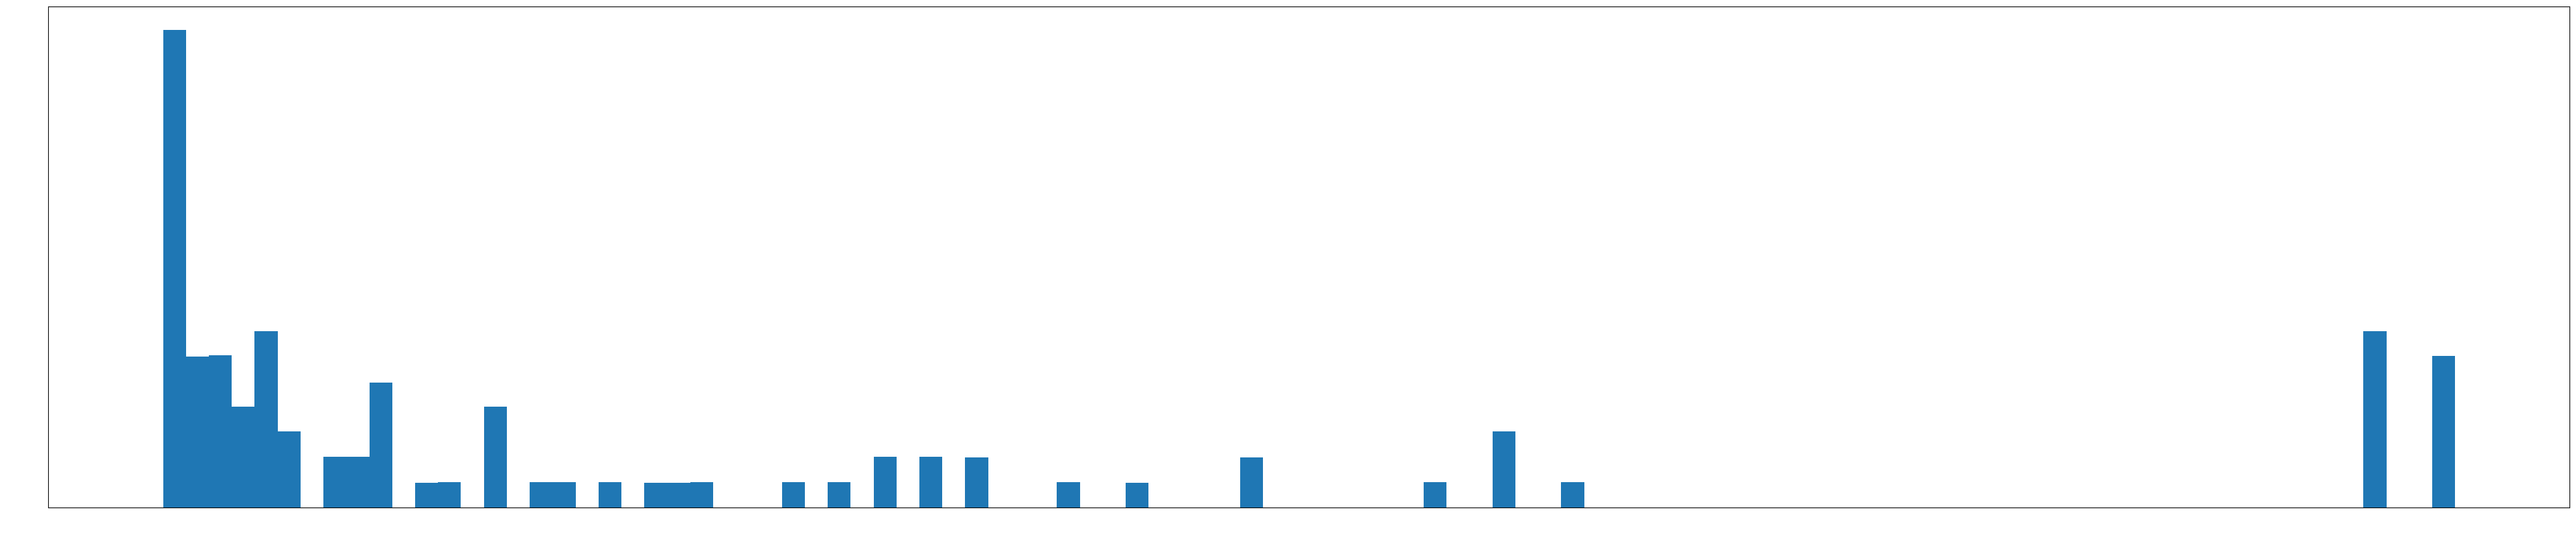

In [35]:
## Histogram of bigram frequencies
plt.figure(figsize=(50, 10))
bg_freq = plt.hist(all_bigrams['bg_freq'], bins = 100)

plt.xlabel("Chosen Bigrams")
plt.ylabel("Bigram Freq.")
plt.title("")

plt.show()

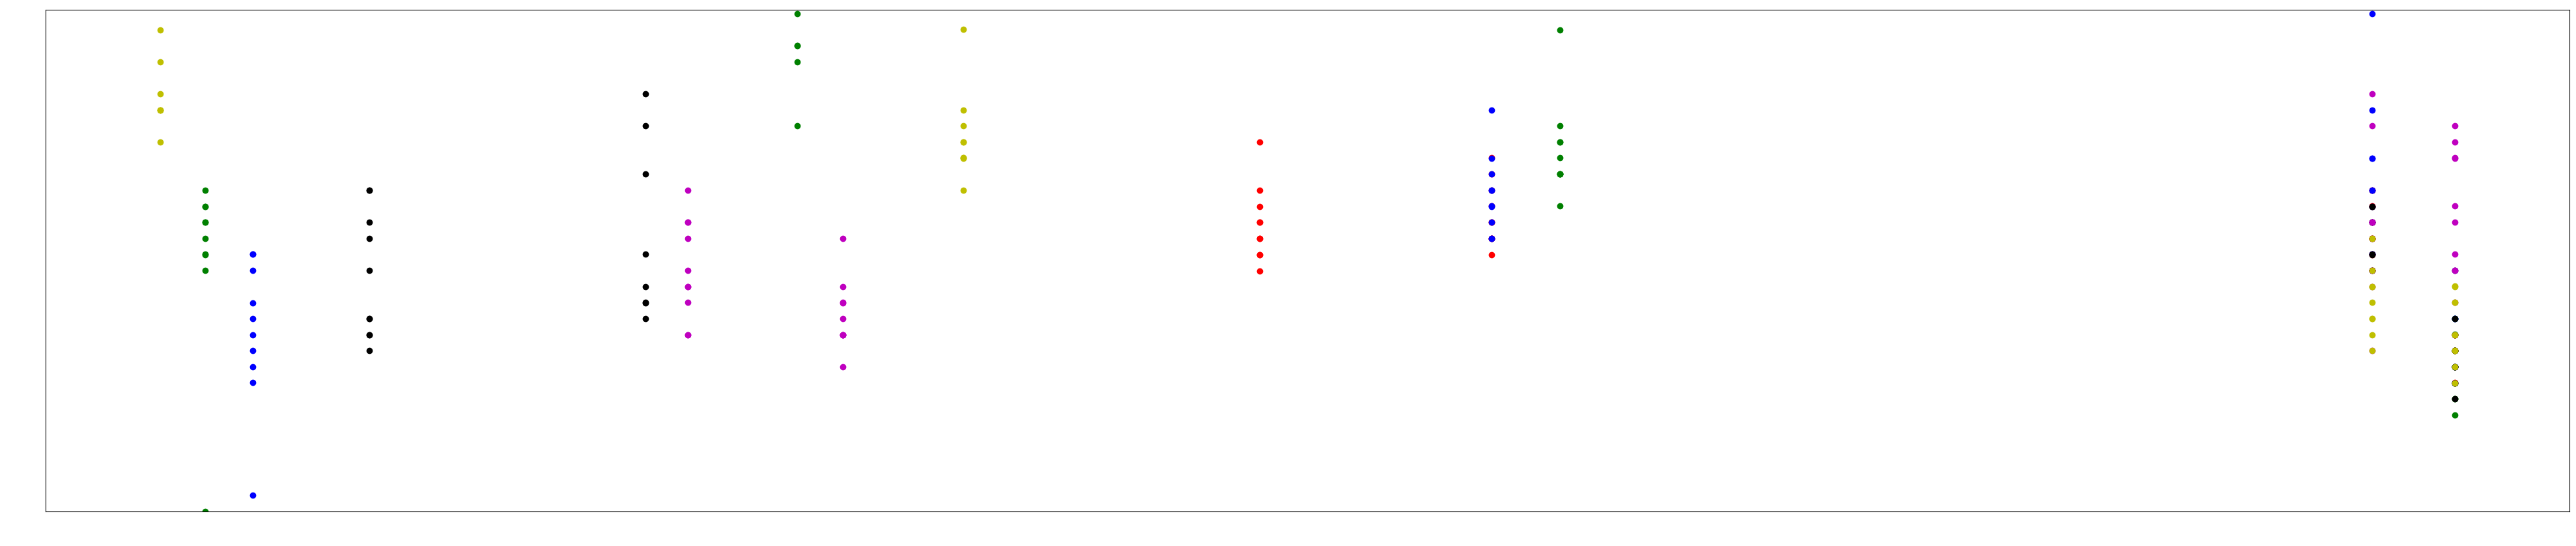

In [36]:
## IKI by Bigram Frequency
plt.figure(figsize=(50, 10))
# bg_freq = plt.scatter(all_bigrams[all_bigrams.sID == 's175']['bg_freq'], all_bigrams[all_bigrams.sID == 's175']['IKI'])

# sb.scatterplot(data = all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')], 
#                x = 'bg_freq', y = 'IKI')
    
    
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')]['IKI'], c='r')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'therm')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'therm')]['IKI'], c='b')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'think')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'think')]['IKI'], c='g')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'theme')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'theme')]['IKI'], c='k')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'tithe')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'tithe')]['IKI'], c='m')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'edthe')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'edthe')]['IKI'], c='y')

plt.ylabel("IKI")
plt.xlabel("Bigram Freq.")
plt.title("")
plt.ylim([0, 0.25])

plt.show()

In [37]:
## making data frames with for individual stats for each bigram
cvs = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg([variation])).reset_index()
for index, bg in enumerate(cvs['bigram']):
    if bg in list(typ.highbf):
        cvs.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        cvs.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        cvs.loc[index, 'bf_type'] = 'Low'     

sds = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['std'])).reset_index()
for index, bg in enumerate(sds['bigram']):
    if bg in list(typ.highbf):
        sds.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        sds.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        sds.loc[index, 'bf_type'] = 'Low' 

ikis = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['mean'])).reset_index()
for index, bg in enumerate(ikis['bigram']):
    if bg in list(typ.highbf):
        ikis.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        ikis.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        ikis.loc[index, 'bf_type'] = 'Low'

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(ikis)

## Mean IKI GRAPHS
___

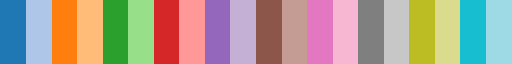

In [38]:
## changing back so save directory for figures
os.chdir(save_dir)

# plt.style.available
# plt.style.use('default')
plt.get_cmap('tab20')

### Creates unique range of colors dependent on number of lines plotted -- useful if you plot more than 20 participants in one graph
## Current color map has 20 unique colors
# color = cm.rainbow(np.linspace(0, 1, len(ID_list)))
# for i, c in zip(range(len(ID_list)), color):
#     plt.plot(x, [l[i] for l in D], '.-', linewidth = 2.5, ms = 20, c = c)

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

In [39]:
# Custom color palette function
# enmax_palette = ["#D81B60", "#1E88E5", "#FFC107", "#004D40"]
# color_codes_wanted = ['pink', 'blue', 'yellow', 'green']

# c = lambda x: enmax_palette[color_codes_wanted.index(x)]

# pal = {'p':"#D81B60",
#           'b':"#1E88E5",
#           'y':"#FFC107",
#           'g':"#004D40"}

# cbf = sb.color_palette(pal)
# x=np.random.randn(100)
# g = sns.distplot(x, color=c("green"))

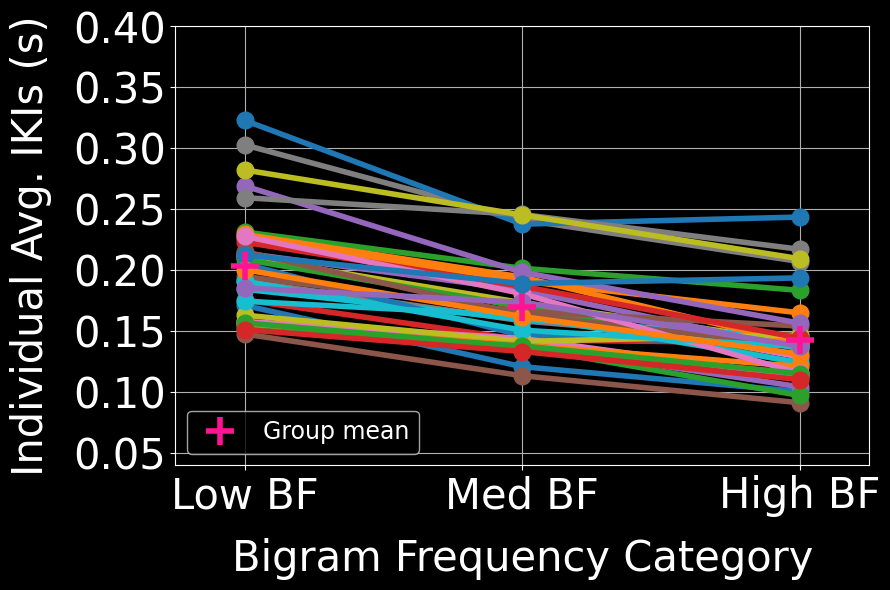

In [40]:
## individual IKI means by BF (correct trials only)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'bigram', typ.medbf)['Avg IKI'],
     indiv_means(corr_trials_bybg, 'bigram', typ.highbf)['Avg IKI'])
means = (np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.medbf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.highbf)['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor = 'black')

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.xlim([1.5, 6.5])
plt.ylim([0.04, 0.4])
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'), size=30)
plt.yticks(size=30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size=30)
plt.ylabel("Individual Avg. IKIs (s)", labelpad=15, size=30)
plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")
plt.grid(visible=None)

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

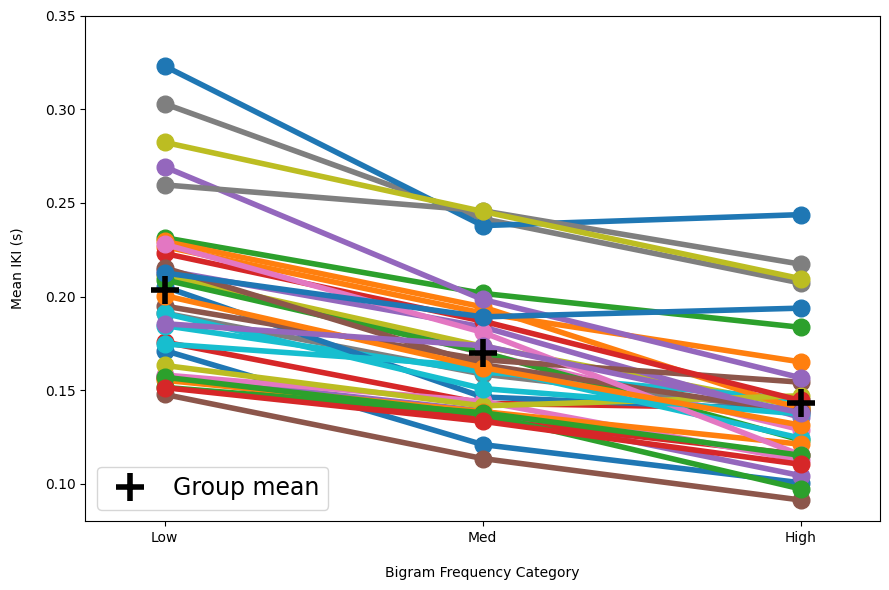

In [41]:
## individual IKI means by BF (correct trials only) PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'bigram', typ.medbf)['Avg IKI'],
     indiv_means(corr_trials_bybg, 'bigram', typ.highbf)['Avg IKI'])
means = (np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.medbf)['Avg IKI']),
         np.mean(indiv_means(corr_trials_bybg, 'bigram', typ.highbf)['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')
    
plt.xlim([1.5, 6.5])
plt.ylim([0.08, 0.35])
plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean IKI (s)", labelpad=15)
plt.title("")
plt.legend(fontsize = 17, loc="lower left")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig('indiv_mean_ikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

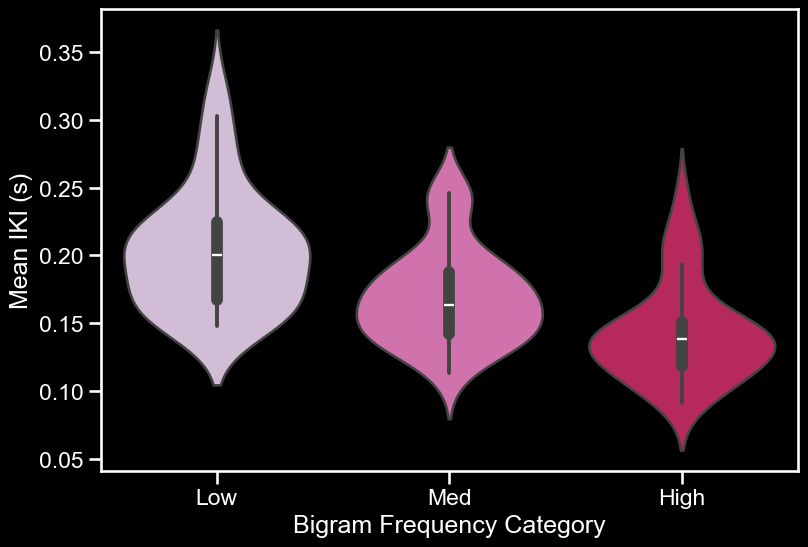

In [42]:
## bigram IKI means by BF (correct trials only)
sb.set(style="ticks", context="talk")
plt.style.use("dark_background")

data = {'Low': indiv_means(corr_trials_bybg, 'bigram', typ.lowbf)['Avg IKI'], 
        'Med': indiv_means(corr_trials_bybg, 'bigram', typ.medbf)['Avg IKI'],
        'High': indiv_means(corr_trials_bybg, 'bigram', typ.highbf)['Avg IKI']}
DF = pd.DataFrame(data)

# sb.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sb.violinplot(data=DF, palette='PuRd', ax=ax)
# sb.swarmplot(data=(DF.mean().to_frame().T), color='dimgrey', marker='o', size=8)
ax.set(xlabel='Bigram Frequency Category', ylabel='Mean IKI (s)')
# plot.set(title = 'Mean IKI by Bigram Frequency Category')
# plot.set(ylabel='Mean IKI (s)')
# plot.set(xlabel='Bigram Frequency Category')
# ax.set_ylim(-0.02,1)
plt.savefig('violin_meanikis_bf_corr.png', dpi=300)
plt.show()

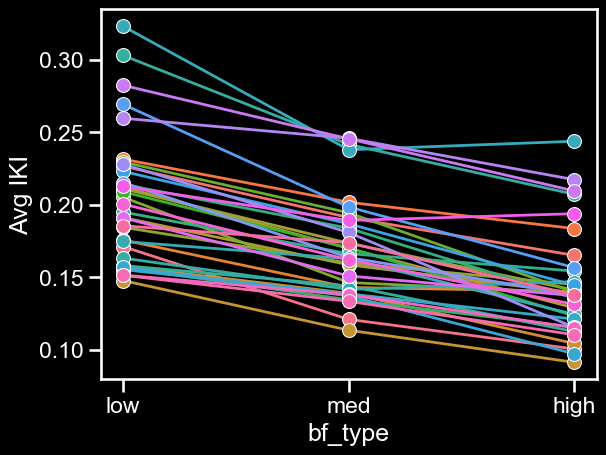

In [43]:
## seaborn version of individuals plot
data = pd.concat([indiv_means(corr_trials_bybg, 'bigram', typ.lowbf),
                  indiv_means(corr_trials_bybg, 'bigram', typ.medbf),
                  indiv_means(corr_trials_bybg, 'bigram', typ.highbf)])

ax = sb.lineplot(data=data, x='bf_type', y='Avg IKI', hue='sID', marker = 'o', markersize = 10, linewidth = 2)
ax.get_legend().set_visible(False)
plt.show()

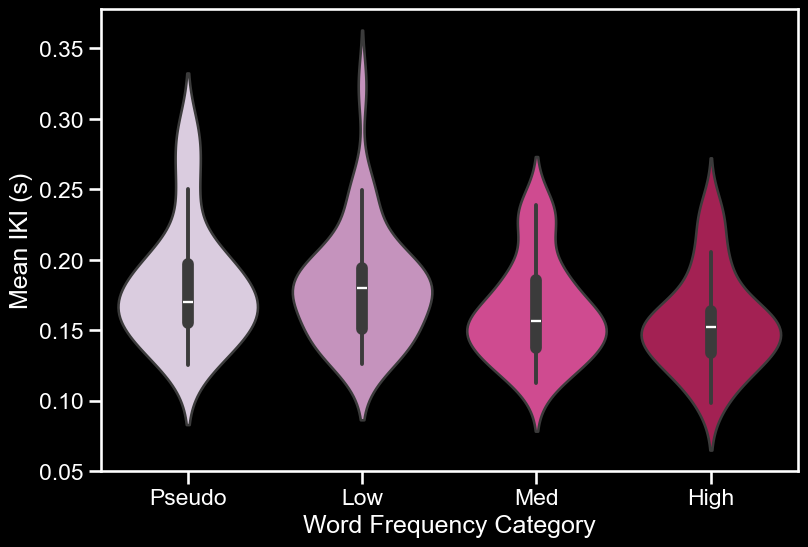

In [44]:
sb.set(style="ticks", context="talk")
plt.style.use("dark_background")

data = {'Pseudo' : indiv_means(corr_trials_bybg, 'string', typ.pseudo)['Avg IKI'],
        'Low': indiv_means(corr_trials_bybg, 'string', typ.lowwf)['Avg IKI'], 
        'Med': indiv_means(corr_trials_bybg, 'string', typ.medwf)['Avg IKI'],
        'High': indiv_means(corr_trials_bybg, 'string', typ.highwf)['Avg IKI']}
DF = pd.DataFrame(data)

# sb.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sb.violinplot(data=DF, palette='PuRd', ax=ax)
# sb.swarmplot(data=(DF.mean().to_frame().T), color='dimgrey', marker='o', size=8)
ax.set(xlabel='Word Frequency Category', ylabel='Mean IKI (s)')
# plot.set(title = 'Mean IKI by Bigram Frequency Category')
# plot.set(ylabel='Mean IKI (s)')
# plot.set(xlabel='Bigram Frequency Category')
# ax.set_ylim(-0.02,1)
plt.savefig('violin_meanikis_wf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

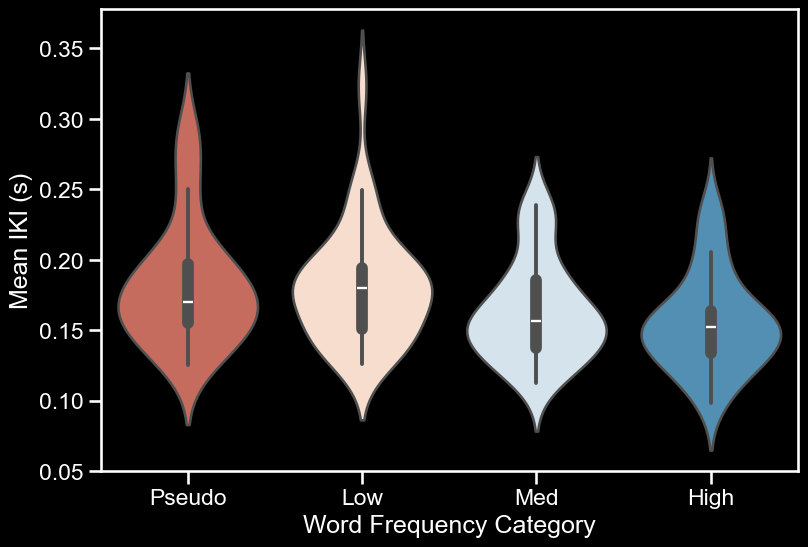

In [45]:
sb.set(style="ticks", context="talk")
plt.style.use("dark_background")

data = {'Pseudo' : indiv_means(corr_trials_bybg, 'string', typ.pseudo)['Avg IKI'],
        'Low': indiv_means(corr_trials_bybg, 'string', typ.lowwf)['Avg IKI'], 
        'Med': indiv_means(corr_trials_bybg, 'string', typ.medwf)['Avg IKI'],
        'High': indiv_means(corr_trials_bybg, 'string', typ.highwf)['Avg IKI']}
DF = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(9,6))
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sb.violinplot(data=DF, palette='RdBu', ax=ax)
# ax.set(title = 'Mean IKI by Word Frequency Category')
ax.set(ylabel='Mean IKI (s)')
ax.set(xlabel='Word Frequency Category')
# ax.set_ylim(-0.02,1)
plt.savefig('violin_meanikis_wf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

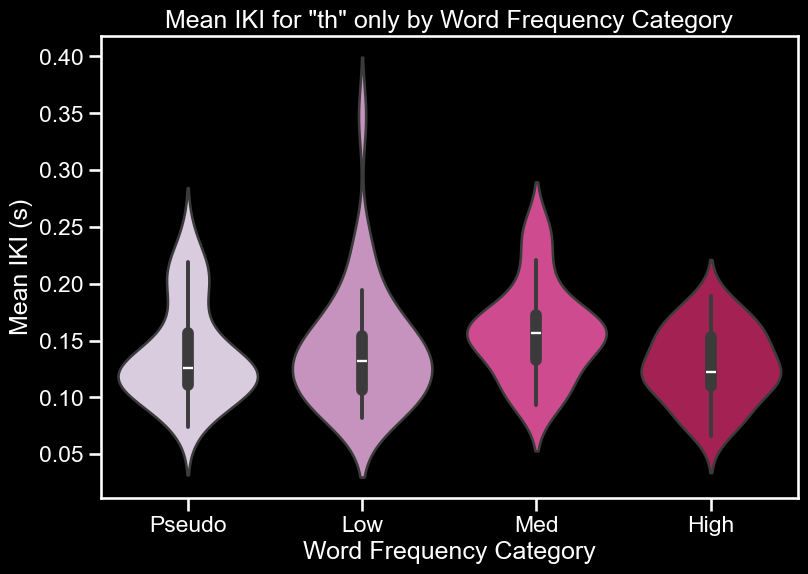

In [46]:
## Mean IKI for 'th' across WF (correct trials only)
# sb.set_style("ticks", rc=custom)
# sb.set_context('talk')
# plt.style.use("dark_background")

th_df = corr_trials_bybg[corr_trials_bybg['bigram'] == 'he']

data = {'Pseudo' : indiv_means(th_df, 'string', typ.pseudo)['Avg IKI'],
        'Low': indiv_means(th_df, 'string', typ.lowwf)['Avg IKI'], 
        'Med': indiv_means(th_df, 'string', typ.medwf)['Avg IKI'],
        'High': indiv_means(th_df, 'string', typ.highwf)['Avg IKI']}
DF = pd.DataFrame(data)

# sb.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sb.violinplot(data=DF, palette='PuRd', ax=ax)
ax.set(title = 'Mean IKI for "th" only by Word Frequency Category')
ax.set(ylabel='Mean IKI (s)')
ax.set(xlabel='Word Frequency Category')
# ax.set_ylim(-0.02,1)
plt.savefig('violin_meanikis_thbywf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

<Figure size 640x480 with 0 Axes>

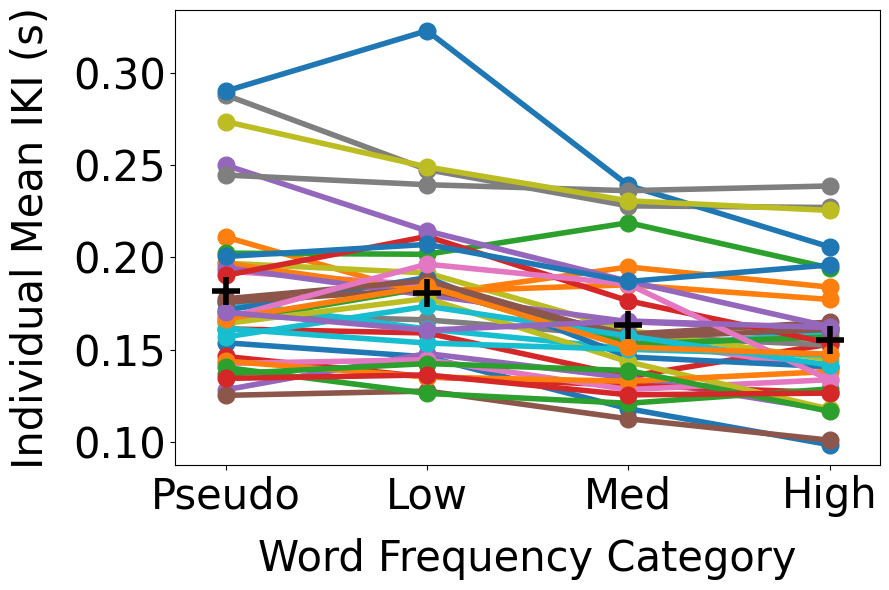

In [47]:
## individual IKI means by WF category
plt.rcParams.update(plt.rcParamsDefault)
plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (indiv_means(corr_trials_bybg, 'string', typ.pseudo)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'string', typ.lowwf)['Avg IKI'], 
     indiv_means(corr_trials_bybg, 'string', typ.medwf)['Avg IKI'],
    indiv_means(corr_trials_bybg, 'string', typ.highwf)['Avg IKI'])

means = (np.mean(indiv_means(corr_trials_bybg, 'string', typ.pseudo)['Avg IKI']), 
         np.mean(indiv_means(corr_trials_bybg, 'string', typ.lowwf)['Avg IKI']), 
         np.mean(indiv_means(corr_trials_bybg, 'string', typ.medwf)['Avg IKI']),
        np.mean(indiv_means(corr_trials_bybg, 'string', typ.highwf)['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize = 30)
plt.ylabel("Individual Mean IKI (s)", labelpad=15, fontsize = 30)
plt.title("")
# plt.legend(loc="best")

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

In [48]:
np.sqrt(len(corr_trials_bybg.IKI))

183.96738841436002

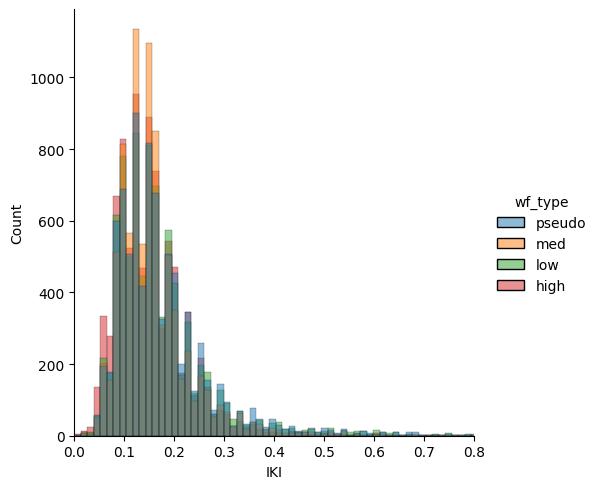

In [49]:
## histograms of mean IKI by WF
# sb.set(rc={"figure.figsize":(9, 6)})
sb.displot(corr_trials_bybg, x='IKI', hue='wf_type', bins=177)
plt.xlim(0, 0.8)
plt.show()

## CV GRAPHS
___

In [50]:
## making dataframe of cv values
cv_df = pd.concat(
    [indiv_avgcvs(all_bigrams, 'bigram', typ.highbf),
    indiv_avgcvs(all_bigrams, 'bigram', typ.medbf).rename(columns = {'Avg CV IKI': 'meanCV_med'})['meanCV_med'],
    indiv_avgcvs(all_bigrams, 'bigram', typ.lowbf).rename(columns = {'Avg CV IKI': 'meanCV_low'})['meanCV_low']], 
    axis = 1)
cv_df = cv_df.rename(columns = {cv_df.columns[1]: 'meanCV_high'})
# cv_df

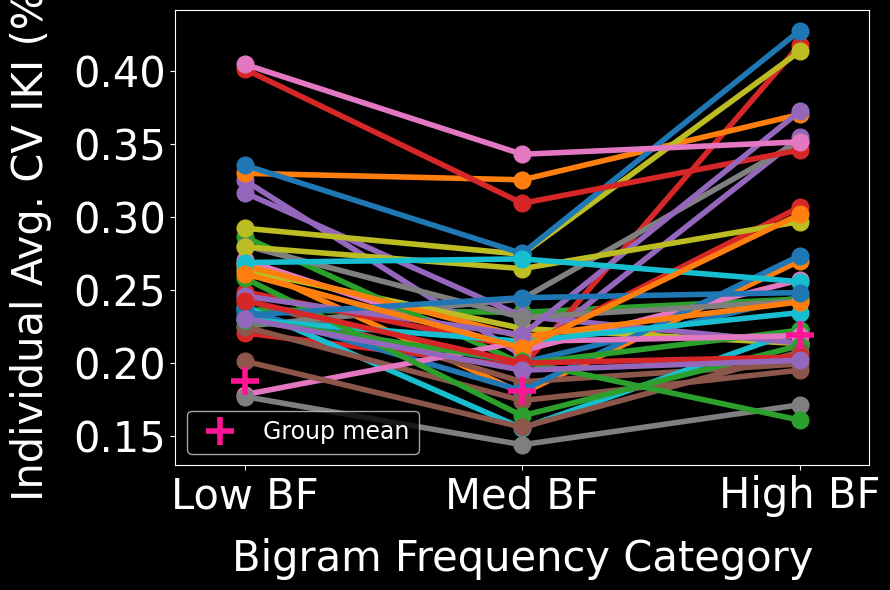

In [51]:
## Individual MEAN CV IKIs sorted by BF (correct trials)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)['Avg CV IKI'])
means = (np.mean(indiv_avgcvs(tight_bgs, 'bigram', typ.lowbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(tight_bgs, 'bigram', typ.medbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(tight_bgs, 'bigram', typ.highbf)['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor = 'black')

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

# plt.ylim([0.1, 0.5])
plt.xlim([1.5, 6.5])
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'), size = 30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size = 30)
plt.yticks(size=30)
plt.ylabel("Individual Avg. CV IKI (%)", labelpad=15, size = 30)
plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('cvikis_bybf_corr.png', dpi=300, transparent = True)
plt.show()

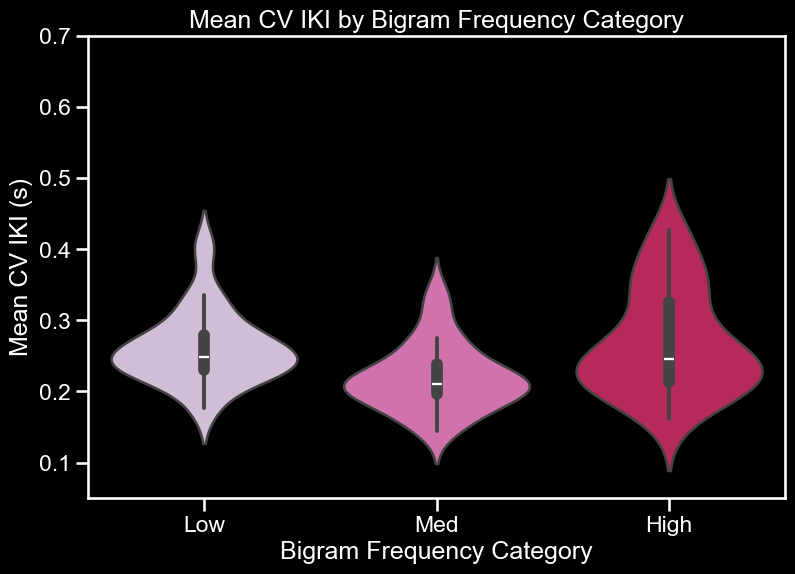

In [52]:
## mean CV IKIs by BF (correct trials only)
sb.set(style="ticks", context="talk")
plt.style.use("dark_background")

data = {'Low': indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)['Avg CV IKI'], 
        'Med': indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)['Avg CV IKI'],
        'High': indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)['Avg CV IKI']}
DF = pd.DataFrame(data)

# sb.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))

# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sb.violinplot(data=DF, palette='PuRd', ax=ax)
ax.set(title = 'Mean CV IKI by Bigram Frequency Category')
ax.set(ylabel='Mean CV IKI (s)')
ax.set(xlabel='Bigram Frequency Category')
ax.set_ylim(0.05, 0.7)

plt.savefig('violin_meancvs_bf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

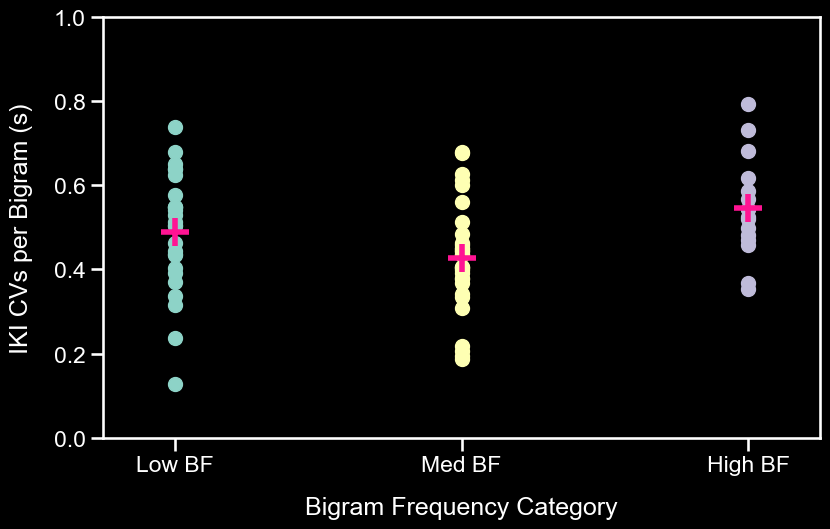

In [53]:
## bigram IKI CVs across individuals by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

# D = (bg_stats[bg_stats.bf_type == 'high']['Mean'],
#      bg_stats[bg_stats.bf_type == 'med']['Mean'],
#      bg_stats[bg_stats.bf_type == 'low']['Mean'])

D2 = list(bg_stats[bg_stats.bf_type == 'low']['CV'])
x2 = [2]*len(D2)

D4 = list(bg_stats[bg_stats.bf_type == 'med']['CV'])
x4 = [4]*len(D4)

D6 = list(bg_stats[bg_stats.bf_type == 'high']['CV'])
x6 = [6]*len(D6)

# mean1 = np.mean(bg_stats[bg_stats.bf_type == 'high']['Mean'])

means = (np.mean(bg_stats[bg_stats.bf_type == 'low']['CV']),
         np.mean(bg_stats[bg_stats.bf_type == 'med']['CV']),
         np.mean(bg_stats[bg_stats.bf_type == 'high']['CV']))
xmean = (2, 4, 6)
         
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x2, D2, '.', ms = 20)
ax.plot(x4, D4, '.', ms = 20)
ax.plot(x6, D6, '.', ms = 20)
    
ax.plot(xmean, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0, 1])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks([2, 4, 6], ['Low BF', 'Med BF', 'High BF'])
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("IKI CVs per Bigram (s)", labelpad=15)
plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

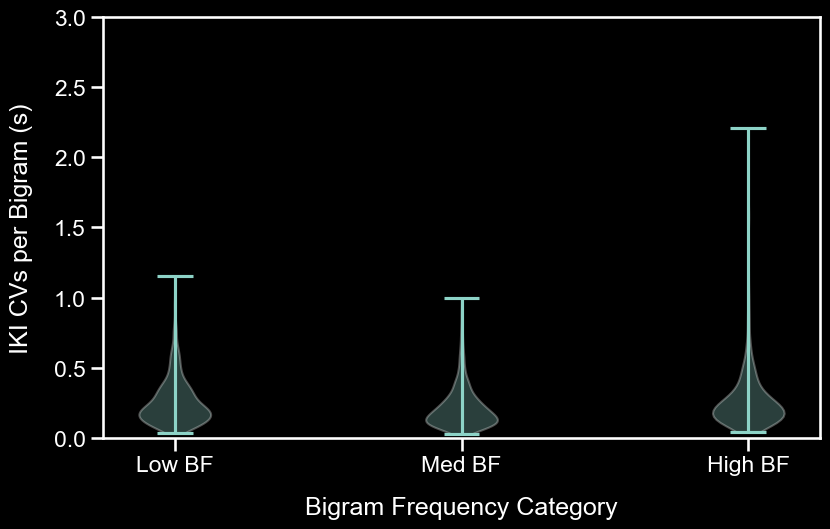

In [54]:
## all bigram IKI CVs for each individual by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

D2 = list(cvs[cvs.bf_type == 'Low']['variation'])
x2 = [2]*len(D2)


D4 = list(cvs[cvs.bf_type == 'Med']['variation'])
x4 = [4]*len(D4)

D6 = list(cvs[cvs.bf_type == 'High']['variation'])
x6 = [6]*len(D6)

means = (np.mean(cvs[cvs.bf_type == 'Low']['variation']),
         np.mean(cvs[cvs.bf_type == 'Med']['variation']),
         np.mean(cvs[cvs.bf_type == 'High']['variation']))
xmean = (2, 4, 6)
         
fig, ax = plt.subplots(figsize=(9, 6))

ax.violinplot([D2, D4, D6], [2, 4, 6])

# ax.plot(x2, D2, '.', ms = 20)
# ax.plot(x4, D4, '.', ms = 20)
# ax.plot(x6, D6, '.', ms = 20)
    
# ax.plot(xmean, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0, 3])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks([2, 4, 6], ['Low BF', 'Med BF', 'High BF'])
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("IKI CVs per Bigram (s)", labelpad=15)
plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

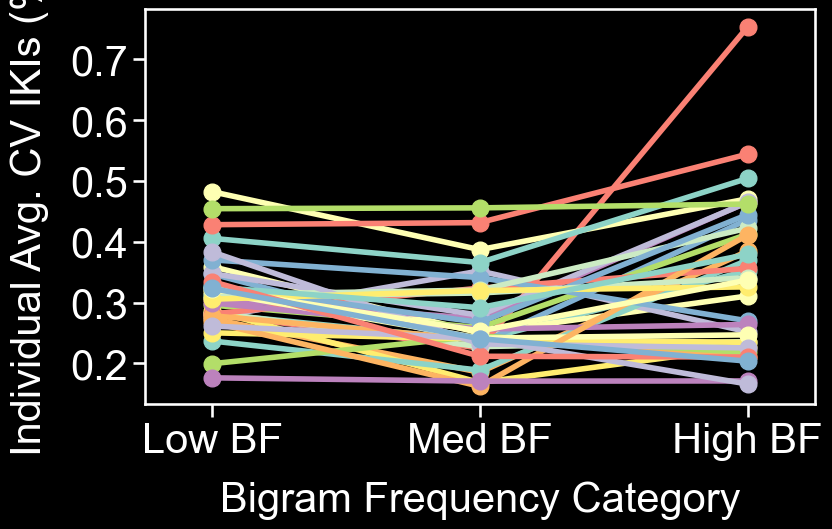

In [55]:
## Inividual MEAN CV IKIs by BF (all trials)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_avgcvs(all_bigrams, 'bigram', typ.lowbf)['Avg CV IKI'], 
     indiv_avgcvs(all_bigrams, 'bigram', typ.medbf)['Avg CV IKI'], 
     indiv_avgcvs(all_bigrams, 'bigram', typ.highbf)['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6), facecolor='black')

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 6.5])
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'), size=30)
plt.yticks(size=30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size=30)
plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15, size=30)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

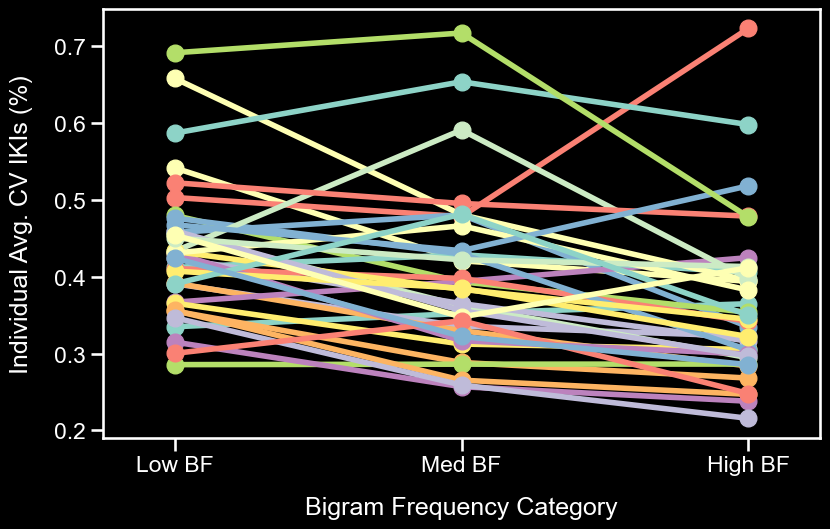

In [56]:
## Individual MEAN CV IKI by AVG BF category (correct trials only)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_avgcvs(corr_trials_bybg, 'string', typ.avg_lowbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'string', typ.avg_medbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'string', typ.avg_highbf)['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_cvikis_bybf.png', dpi=300, transparent = True)
plt.show()

In [57]:
# individual MEAN CV IKIs by AVG BF category (tight_bgs df)
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# x = [2, 4, 6]
# D = (indiv_avgcvs(tight_bgs, 'string', typ.avg_lowbf)['Avg CV IKI'], 
#      indiv_avgcvs(tight_bgs, 'string', typ.avg_medbf)['Avg CV IKI'], 
#      indiv_avgcvs(tight_bgs, 'string', typ.avg_highbf)['Avg CV IKI'])

# fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

# plt.xlim([1.5, 6.5])
# # plt.xticks(x, ('', '', ''))
# plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
# plt.xlabel("Average Bigram Frequency Category", labelpad=15)
# plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)
# plt.title("")
# # plt.legend(loc="best")

# ax.set_facecolor('black')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# fig.tight_layout()
# # plt.savefig('indiv_mean_ikis.png', dpi=300)
# plt.show()

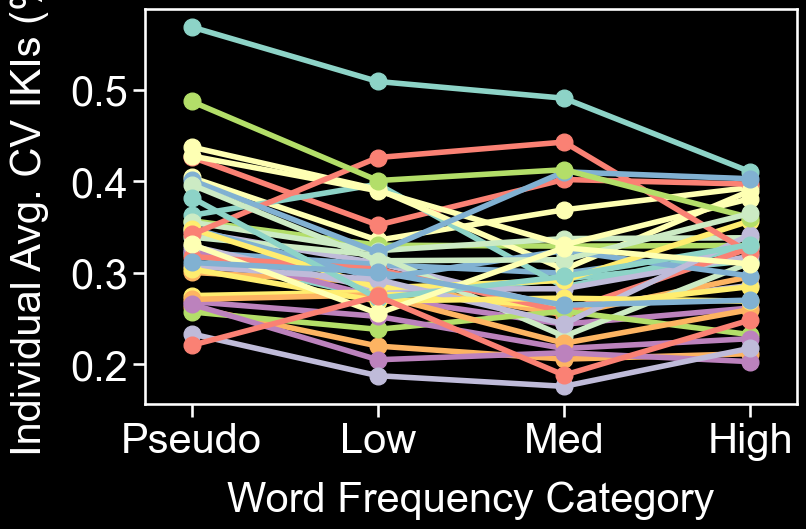

In [58]:
# individual avg CV IKI by WF category (can also change dataframe here)
x = [2, 4, 6, 8]
D = (indiv_avgcvs(tight_bgs, 'string', typ.pseudo)['Avg CV IKI'], 
     indiv_avgcvs(tight_bgs, 'string', typ.lowwf)['Avg CV IKI'], 
     indiv_avgcvs(tight_bgs, 'string', typ.medwf)['Avg CV IKI'],
     indiv_avgcvs(tight_bgs, 'string', typ.highwf)['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6), facecolor = 'black')

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), size=30)
plt.xlabel("Word Frequency Category", labelpad=15, size=30)

plt.yticks(size=30)
plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15, size=30)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

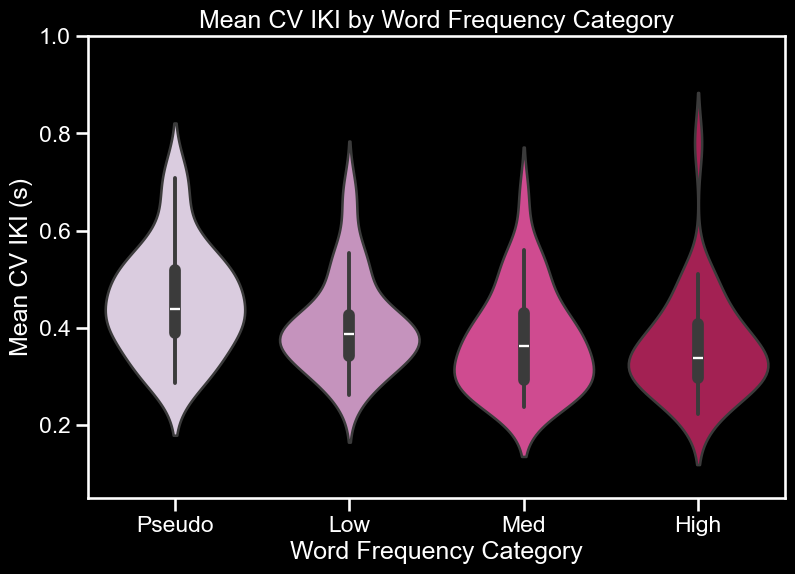

In [59]:
## mean CV IKI by WF (correct trials only)
data = {'Pseudo' : indiv_avgcvs(corr_trials_bybg, 'string', typ.pseudo)['Avg CV IKI'], 
        'Low': indiv_avgcvs(corr_trials_bybg, 'string', typ.lowwf)['Avg CV IKI'], 
        'Med' : indiv_avgcvs(corr_trials_bybg, 'string', typ.medwf)['Avg CV IKI'],
        'High' : indiv_avgcvs(corr_trials_bybg, 'string', typ.highwf)['Avg CV IKI']}
DF = pd.DataFrame(data)

# sb.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sb.violinplot(data=DF, palette='PuRd', ax=ax)
ax.set(title = 'Mean CV IKI by Word Frequency Category')
ax.set(ylabel='Mean CV IKI (s)')
ax.set(xlabel='Word Frequency Category')
ax.set_ylim(0.05, 1)

plt.savefig('violin_meancvs_wf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

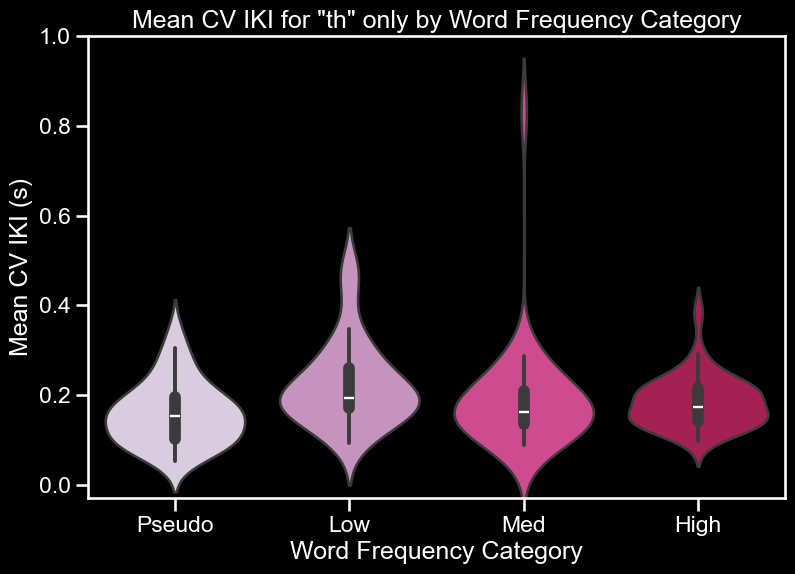

In [60]:
## Mean CV IKI for 'th' across WF (correct trials only)
th_df = corr_trials_bybg[corr_trials_bybg['bigram'] == 'th']

data = {'Pseudo' : indiv_avgcvs(th_df, 'string', typ.pseudo)['Avg CV IKI'], 
        'Low': indiv_avgcvs(th_df, 'string', typ.lowwf)['Avg CV IKI'], 
        'Med' : indiv_avgcvs(th_df, 'string', typ.medwf)['Avg CV IKI'],
        'High' : indiv_avgcvs(th_df, 'string', typ.highwf)['Avg CV IKI']}
DF = pd.DataFrame(data)

# sb.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sb.violinplot(data=DF, palette='PuRd', ax=ax)
ax.set(title = 'Mean CV IKI for "th" only by Word Frequency Category')
ax.set(ylabel='Mean CV IKI (s)')
ax.set(xlabel='Word Frequency Category')
ax.set_ylim(-0.03, 1)

plt.savefig('violin_meancvs_thbywf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

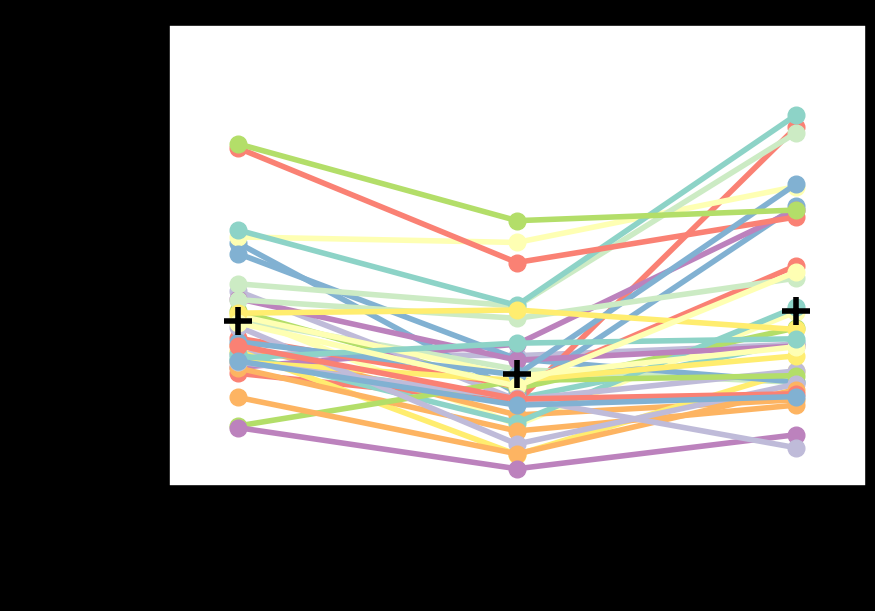

In [61]:
## using bigrams sorted by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)['Avg CV IKI'], 
     indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)['Avg CV IKI'])
means = (np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.medbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.13, 0.5])
plt.xticks(x, ('Low', 'Med', 'High'), size=30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size=30)

plt.yticks(size=30)
plt.ylabel("Mean CV IKI (%)", labelpad=15, size=30)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_cvikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

## SD GRAPHS
___

In [62]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     # print(typ.all_bigrams)
    
# repeats = ['ll', 'oo', 'pp', 'dd', 'kk']

# noreps

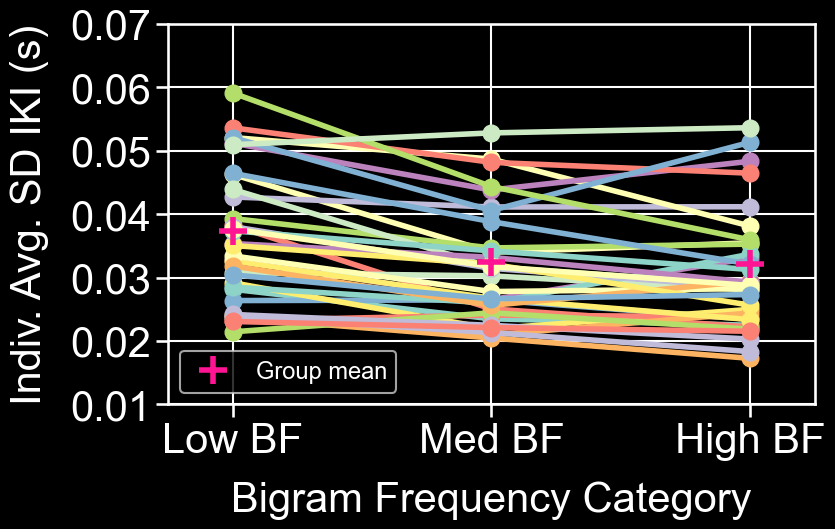

In [63]:
## individual MEAN SD IKI by BF (correct trials)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_avgsds(tight_bgs, 'bigram', lowbf_norep)['Avg SD IKI'], 
     indiv_avgsds(tight_bgs, 'bigram', medbf_norep)['Avg SD IKI'],
     indiv_avgsds(tight_bgs, 'bigram', typ.highbf)['Avg SD IKI'])
means = (np.mean(indiv_avgsds(tight_bgs, 'bigram', lowbf_norep)['Avg SD IKI']), 
         np.mean(indiv_avgsds(tight_bgs, 'bigram', medbf_norep)['Avg SD IKI']),
         np.mean(indiv_avgsds(tight_bgs, 'bigram', typ.highbf)['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor = 'black')
ax.set_facecolor('black')

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0.01, 0.07])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'), size=30)
plt.yticks(size = 30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size=30)
plt.ylabel("Indiv. Avg. SD IKI (s)", labelpad=15, size=30)
plt.grid(visible=None)

plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('meansds_bybf_corr.png', dpi=300, transparent = True)
plt.show()

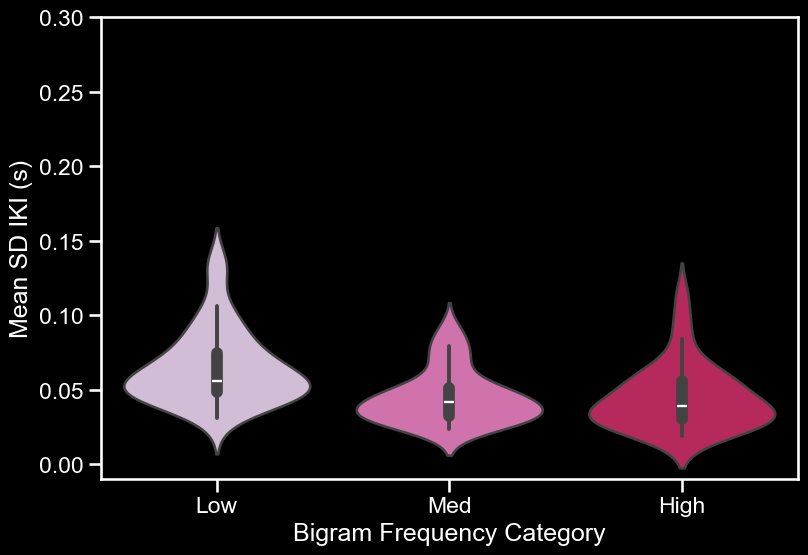

In [64]:
## mean CV IKIs by BF (correct trials only)
data = {'Low': indiv_avgsds(corr_trials_bybg, 'bigram', lowbf_norep)['Avg SD IKI'], 
        'Med': indiv_avgsds(corr_trials_bybg, 'bigram', medbf_norep)['Avg SD IKI'],
        'High': indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)['Avg SD IKI']}
DF = pd.DataFrame(data)

# sb.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sb.violinplot(data=DF, palette='PuRd', ax=ax)
# ax.set(title = 'Mean SD IKI by Bigram Frequency Category')
ax.set(ylabel='Mean SD IKI (s)')
ax.set(xlabel='Bigram Frequency Category')
ax.set_ylim(-0.01, 0.3)

plt.savefig('violin_meansds_bf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

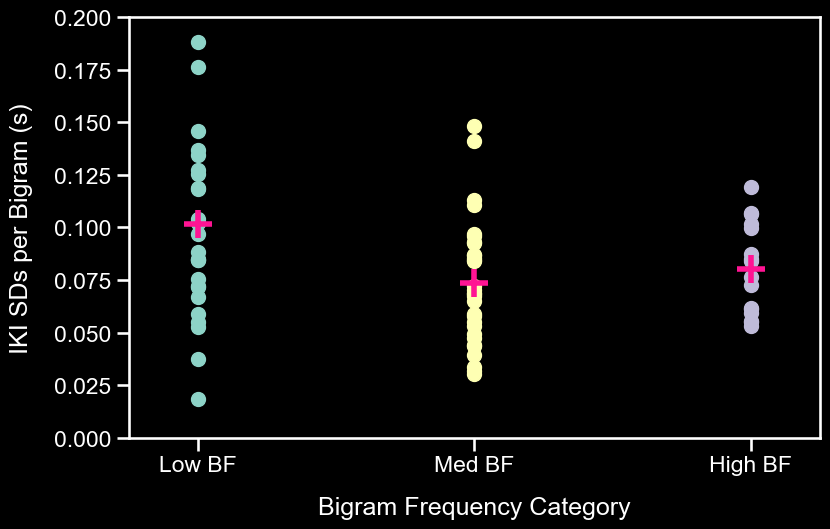

In [65]:
## bigram IKI SDs across individuals by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

# D = (bg_stats[bg_stats.bf_type == 'high']['Mean'],
#      bg_stats[bg_stats.bf_type == 'med']['Mean'],
#      bg_stats[bg_stats.bf_type == 'low']['Mean'])

D2 = list(bg_stats[bg_stats.bf_type == 'low']['SD'])
x2 = [2]*len(D2)

D4 = list(bg_stats[bg_stats.bf_type == 'med']['SD'])
x4 = [4]*len(D4)

D6 = list(bg_stats[bg_stats.bf_type == 'high']['SD'])
x6 = [6]*len(D6)

# mean1 = np.mean(bg_stats[bg_stats.bf_type == 'high']['Mean'])

means = (np.mean(bg_stats[bg_stats.bf_type == 'low']['SD']),
         np.mean(bg_stats[bg_stats.bf_type == 'med']['SD']),
         np.mean(bg_stats[bg_stats.bf_type == 'high']['SD']))
xmean = (2, 4, 6)
         
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x2, D2, '.', ms = 20)
ax.plot(x4, D4, '.', ms = 20)
ax.plot(x6, D6, '.', ms = 20)
    
ax.plot(xmean, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0, 0.2])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks([2, 4, 6], ['Low BF', 'Med BF', 'High BF'])
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("IKI SDs per Bigram (s)", labelpad=15)
plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

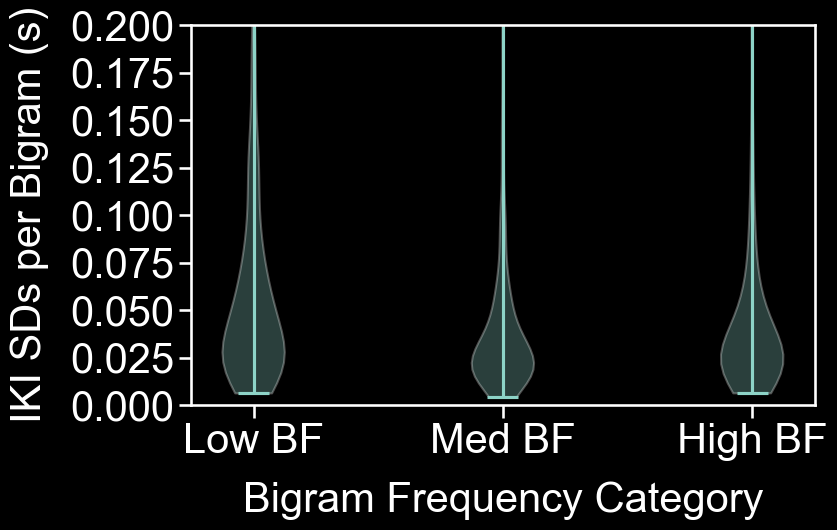

In [66]:
## all bigram IKI SDs for each individual by BF (correct trials only)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

# D2 = list(sds[sds.bf_type == 'Low']['std'])
# x2 = [2]*len(D2)

# D4 = list(sds[sds.bf_type == 'Med']['std'])
# x4 = [4]*len(D4)

# D6 = list(sds[sds.bf_type == 'High']['std'])
# x6 = [6]*len(D6)

# means = (np.mean(sds[sds.bf_type == 'Low']['std']),
#          np.mean(sds[sds.bf_type == 'Med']['std']),
#          np.mean(sds[sds.bf_type == 'High']['std']))
# xmean = (2, 4, 6)
         
fig, ax = plt.subplots(figsize=(9, 6), facecolor = 'black')

# ax.plot(x2, D2, '.', ms = 20)
# ax.plot(x4, D4, '.', ms = 20)
# ax.plot(x6, D6, '.', ms = 20)
    
# ax.plot(xmean, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

D = [list(sds[sds.bf_type == 'Low']['std']),
     list(sds[sds.bf_type == 'Med']['std']),
     list(sds[sds.bf_type == 'High']['std'])]
x = (2, 4, 6)

ax.violinplot(D, x)

plt.ylim([0, 0.2])
plt.xlim([1.5, 6.5])
plt.yticks(size=30)
plt.xticks([2, 4, 6], ['Low BF', 'Med BF', 'High BF'], size=30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size=30)
plt.ylabel("IKI SDs per Bigram (s)", labelpad=15, size=30)
plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

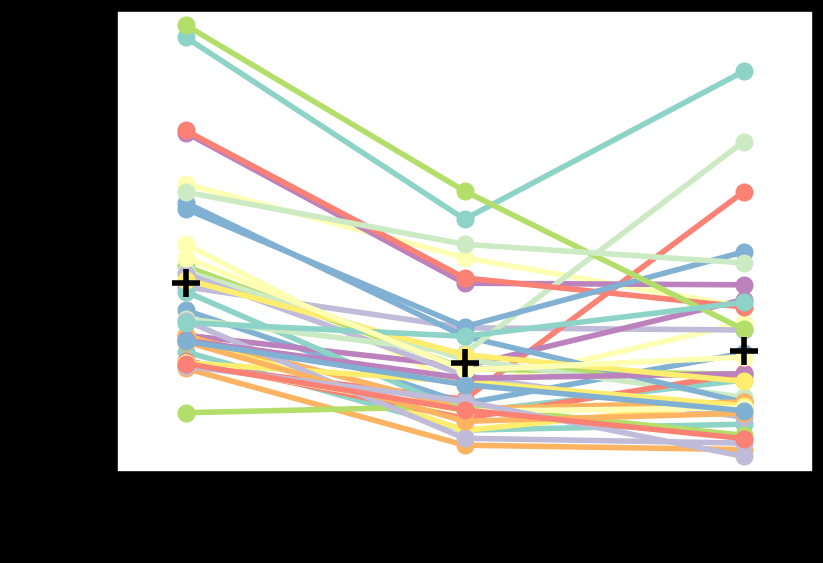

In [67]:
## individual MEAN SD IKI by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'bigram', typ.medbf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)['Avg SD IKI'])
means = (np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)['Avg SD IKI']), 
         np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.medbf)['Avg SD IKI']),
         np.mean(indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.015, 0.129])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean SD IKI (s)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_avgsds_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

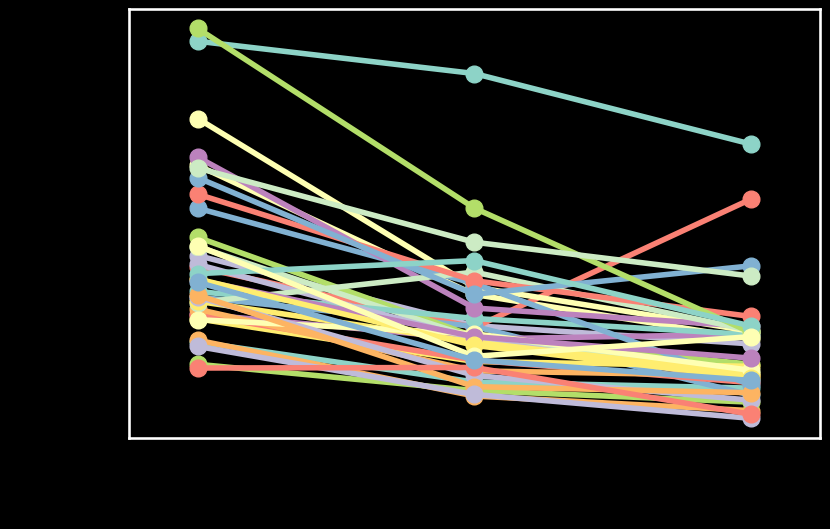

In [68]:
## individual MEAN SD IKI by AVG BF (correct trials)
plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_avgsds(corr_trials_bybg, 'string', typ.avg_lowbf)['Avg SD IKI'], 
     indiv_avgsds(corr_trials_bybg, 'string', typ.avg_medbf)['Avg SD IKI'],
     indiv_avgsds(corr_trials_bybg, 'string', typ.avg_highbf)['Avg SD IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Average Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Avg. STD IKI (s)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

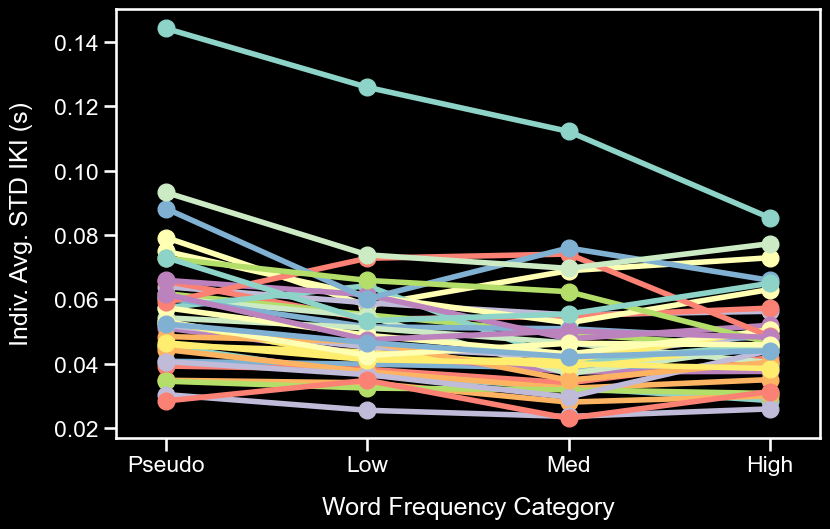

In [69]:
## individual MEAN SD IKI by WF (correct trials)
plt.rcParams['font.size'] = '30'
x = [2, 4, 6, 8]
D = (indiv_avgsds(tight_bgs, 'string', typ.pseudo)['Avg SD IKI'], 
     indiv_avgsds(tight_bgs, 'string', typ.lowwf)['Avg SD IKI'],
     indiv_avgsds(tight_bgs, 'string', typ.medwf)['Avg SD IKI'],
     indiv_avgsds(tight_bgs, 'string', typ.highwf)['Avg SD IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
plt.xlabel("Word Frequency Category", labelpad=15)
plt.ylabel("Indiv. Avg. STD IKI (s)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('indiv_avgsds.png', dpi=300)
plt.show()

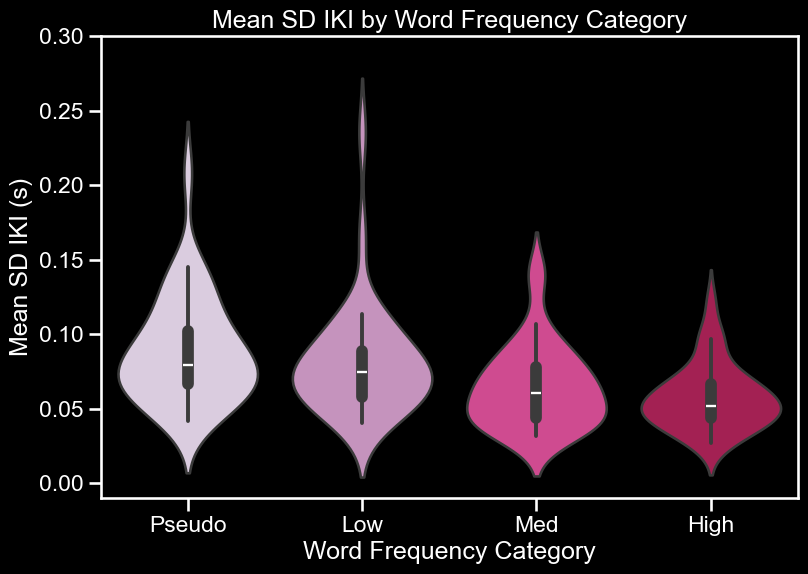

In [70]:
## mean CV IKI by WF (correct trials only)
data = {'Pseudo' : indiv_avgsds(corr_trials_bybg, 'string', typ.pseudo)['Avg SD IKI'], 
        'Low': indiv_avgsds(corr_trials_bybg, 'string', typ.lowwf)['Avg SD IKI'], 
        'Med' : indiv_avgsds(corr_trials_bybg, 'string', typ.medwf)['Avg SD IKI'],
        'High' : indiv_avgsds(corr_trials_bybg, 'string', typ.highwf)['Avg SD IKI']}
DF = pd.DataFrame(data)

# sb.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sb.violinplot(data=DF, palette='PuRd', ax=ax)
ax.set(title = 'Mean SD IKI by Word Frequency Category')
ax.set(ylabel='Mean SD IKI (s)')
ax.set(xlabel='Word Frequency Category')
ax.set_ylim(-0.01, 0.3)

plt.savefig('violin_meansds_wf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

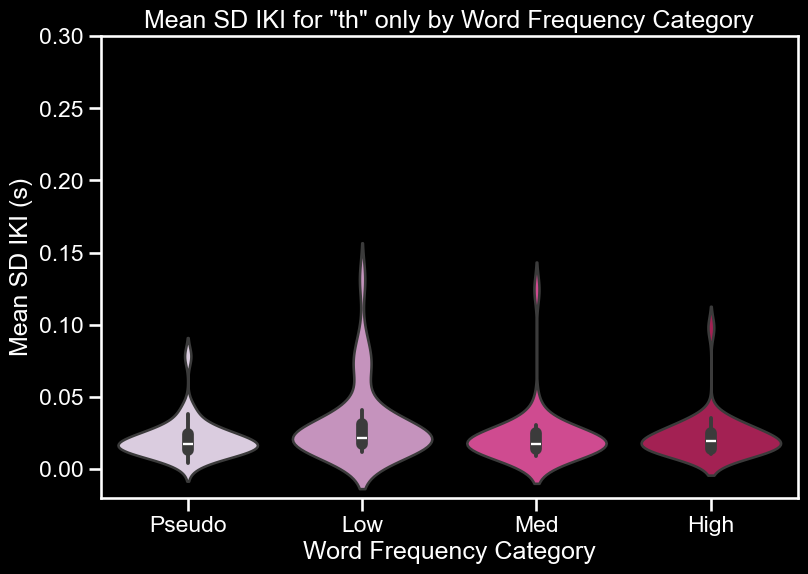

In [71]:
## mean CV IKI for 'th' by WF (correct trials only)
th_df = corr_trials_bybg[corr_trials_bybg['bigram'] == 'th']

data = {'Pseudo' : indiv_avgsds(th_df, 'string', typ.pseudo)['Avg SD IKI'], 
        'Low': indiv_avgsds(th_df, 'string', typ.lowwf)['Avg SD IKI'], 
        'Med' : indiv_avgsds(th_df, 'string', typ.medwf)['Avg SD IKI'],
        'High' : indiv_avgsds(th_df, 'string', typ.highwf)['Avg SD IKI']}
DF = pd.DataFrame(data)

# sb.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sb.violinplot(data=DF, palette='PuRd', ax=ax)
ax.set(title = 'Mean SD IKI for "th" only by Word Frequency Category')
ax.set(ylabel='Mean SD IKI (s)')
ax.set(xlabel='Word Frequency Category')
ax.set_ylim(-0.02, 0.30)

plt.savefig('violin_meansds_thbywf_corr.png', dpi=300)
plt.show()

## BG FREQ GRAPHS
___

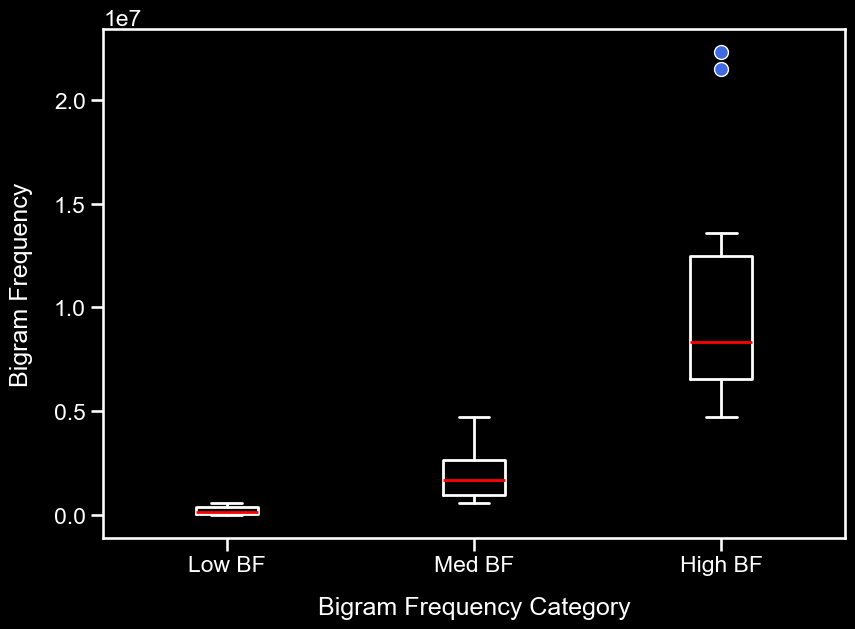

In [72]:
## plotting BF distribution of data set
high_bgs = typ.bg_freqs.loc[0:15]
med_bgs = typ.bg_freqs.loc[15:46]
low_bgs = typ.bg_freqs.loc[46:69]

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

boxprops = dict(linestyle='-', linewidth=2, color = 'white')
whiskerprops = dict(linewidth=2, color = 'white')
capprops = dict(linewidth=2, color = 'white')
flierprops = dict(markerfacecolor='royalblue', markersize=10)
medianprops = dict(linewidth=2, color='red')

ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
          flierprops=flierprops, medianprops=medianprops)

plt.xlim([1, 7])
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)

# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('bf.png', dpi=300)
plt.show()

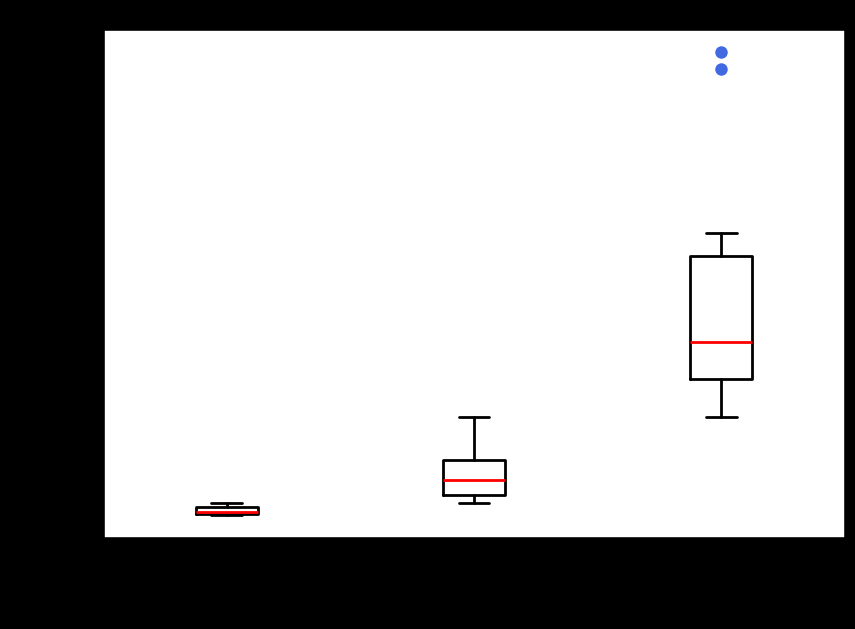

In [73]:
## plotting BF distribution of data set -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

boxprops = dict(linestyle='-', linewidth=2, color = 'black')
whiskerprops = dict(linewidth=2, color = 'black')
capprops = dict(linewidth=2, color = 'black')
flierprops = dict(markerfacecolor='royalblue', markersize=10)
medianprops = dict(linewidth=2, color='red')

ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
          flierprops=flierprops, medianprops=medianprops)

plt.xlim([1, 7])
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency (10 mil)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig('wf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

## ERROR GRAPHS
___

(0      6
1     21
2     10
3      9
4     13
5      2
6      6
7     25
8      2
9      5
10     2
11    38
12    17
13    16
14    33
15    15
16    11
17     6
18    13
19     4
20    25
21    11
22    11
23    10
24    14
25     4
26    25
27     1
28     8
29    21
30    10
31     3
32    18
33     8
34    12
Name: Total Error, dtype: int64, 0      6
1     13
2     19
3     10
4     12
5      3
6     10
7     20
8      2
9      3
10     2
11    39
12    22
13    28
14    32
15    10
16    14
17     6
18    13
19     4
20    31
21     6
22     5
23    26
24    12
25     4
26    19
27     3
28    16
29    16
30    18
31     4
32    14
33     2
34     5
Name: Total Error, dtype: int64, 0      5
1     11
2      9
3     30
4      7
5     12
6     14
7     13
8      1
9      2
10     6
11    17
12    10
13    18
14    13
15     5
16     1
17     7
18     8
19     2
20    32
21    10
22     2
23    28
24     5
25    22
26     5
27     0
28    17
29    12
30    12
31     6
32     6
33    

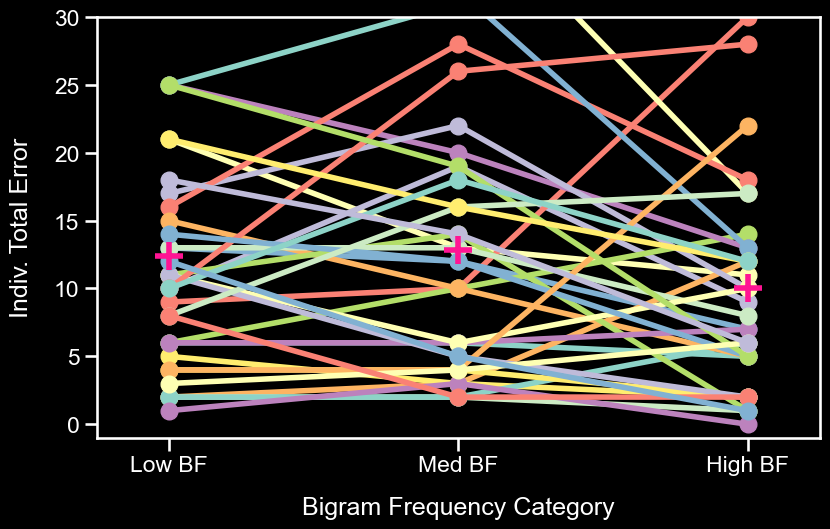

In [74]:
## Individual total trial error by bigram BF
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_error(incorr_bgs, 'bigram', typ.lowbf)['Total Error'], 
     indiv_error(incorr_bgs, 'bigram', typ.medbf)['Total Error'],
     indiv_error(incorr_bgs, 'bigram', typ.highbf)['Total Error'])

print(D)
means = (np.mean(indiv_error(incorr_bgs, 'bigram', typ.lowbf)['Total Error']), 
         np.mean(indiv_error(incorr_bgs, 'bigram', typ.medbf)['Total Error']),
         np.mean(indiv_error(incorr_bgs, 'bigram', typ.highbf)['Total Error']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([-1, 30])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Total Error", labelpad=15)

plt.title("")
# plt.legend(fontsize = 17, loc="best", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('meanerr_bybf.png', dpi=300)
plt.show()

In [75]:
## Individual total trial error by AVG BF
# plt.rcParams['font.size'] = '30'
# x = [2, 4, 6]
# D = (indiv_error(incorr_trials, 'string', typ.avg_lowbf)['Total Error'], 
#      indiv_error(incorr_trials, 'string', typ.avg_medbf)['Total Error'],
#      indiv_error(incorr_trials, 'string', typ.avg_highbf)['Total Error'])

# fig, ax = plt.subplots(figsize=(9, 6))

# ax.plot(x, D, '.-', linewidth = 2.5, ms = 20)

# plt.xlim([1.5, 6.5])
# # plt.xticks(x, ('', '', ''))
# plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
# plt.xlabel("Average Bigram Frequency Category", labelpad=15)
# plt.ylabel("Indiv. Total Error", labelpad=15)

# plt.title("")
# # plt.legend(loc="best")

# ax.set_facecolor('black')
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# fig.tight_layout()
# plt.savefig('indiv_avgsds.png', dpi=300)
# plt.show()

In [76]:
## Individual total trial error by WF
# plt.rcParams['font.size'] = '30'
# x = [2, 4, 6, 8]

# D = (indiv_error(incorr_trials, 'string', typ.pseudo)['Total Error'],
#      indiv_error(incorr_trials, 'string', typ.lowwf)['Total Error'],
#      indiv_error(incorr_trials, 'string', typ.medwf)['Total Error'],
#      indiv_error(incorr_trials, 'string', typ.highwf)['Total Error'])

# fig, ax = plt.subplots(figsize=(9, 6))

# print([len(x) for x in D])
# ax.plot(x, D, '.-', linewidth = 2.5, ms = 20)

# plt.xlim([1.5, 8.5])
# # plt.xticks(x, ('', '', ''))
# plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
# plt.xlabel("Word Frequency Category", labelpad=15)
# plt.ylabel("Indiv. Total Error", labelpad=15)

# plt.title("")
# # plt.legend(loc="best")

# ax.set_facecolor('black')
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# fig.tight_layout()
# # plt.savefig('indiv_avgsds.png', dpi=300)
# plt.show()

In [77]:
all_trials['trial_corr']

0       corr
1       corr
2       corr
3       corr
4       corr
        ... 
9115    corr
9116    corr
9117    corr
9118    corr
9119    corr
Name: trial_corr, Length: 9120, dtype: object

## Onset Delay

In [78]:
## finding indices of trials that occur after an error
err_indices = list(all_trials[all_trials['trial_corr'] == 'incorr'].index.values)
posterr_indices = list(map(lambda x: x + 1, err_indices))

## making dataframe of only post-error trial reaction times
all_rts = corr_trials[['sID', 'key_resp.rt.1', 'wf_type']]
posterr_rts = all_rts.filter(posterr_indices, axis=0)

## making dataframe of only post-success trial reaction times
all_indices = list(all_trials.index.values)
bad_indices = (err_indices + posterr_indices)
postsucc_indices = list(filter(lambda x: x not in set(bad_indices), all_indices))
postsucc_rts = all_rts.filter(postsucc_indices, axis=0)

In [79]:
## calculating onset delays WF group averages by subject
od = corr_trials[['sID', 'key_resp.rt.1', 'wf_type']]
od_avgs = od.groupby(['sID', 'wf_type']).mean().reset_index()
od_avgs = od_avgs.rename(columns={'key_resp.rt.1' : 'onset_delay'})

## running anova on onset delay averages across WF groups
od_anova = pg.rm_anova(od_avgs, 'onset_delay', 'wf_type', 'sID')
print(od_anova)
pg.pairwise_tukey(od_avgs, 'onset_delay', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3    102  92.958619  4.590914e-29  0.133272  0.651491


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  highwf   lowwf  0.749012  0.807421 -0.058409  0.035282 -1.655476  0.351371   
1  highwf   medwf  0.749012  0.781930 -0.032919  0.035282 -0.933006  0.787182   
2  highwf  pseudo  0.749012  0.902207 -0.153195  0.035282 -4.341963  0.000159   
3   lowwf   medwf  0.807421  0.781930  0.025491  0.035282  0.722470  0.887985   
4   lowwf  pseudo  0.807421  0.902207 -0.094786  0.035282 -2.686487  0.040064   
5   medwf  pseudo  0.781930  0.902207 -0.120276  0.035282 -3.408957  0.004711   

      cohen  
0 -0.421146  
1 -0.255861  
2 -0.974678  
3  0.185584  
4 -0.576669  
5 -0.771026

<Figure size 640x480 with 0 Axes>

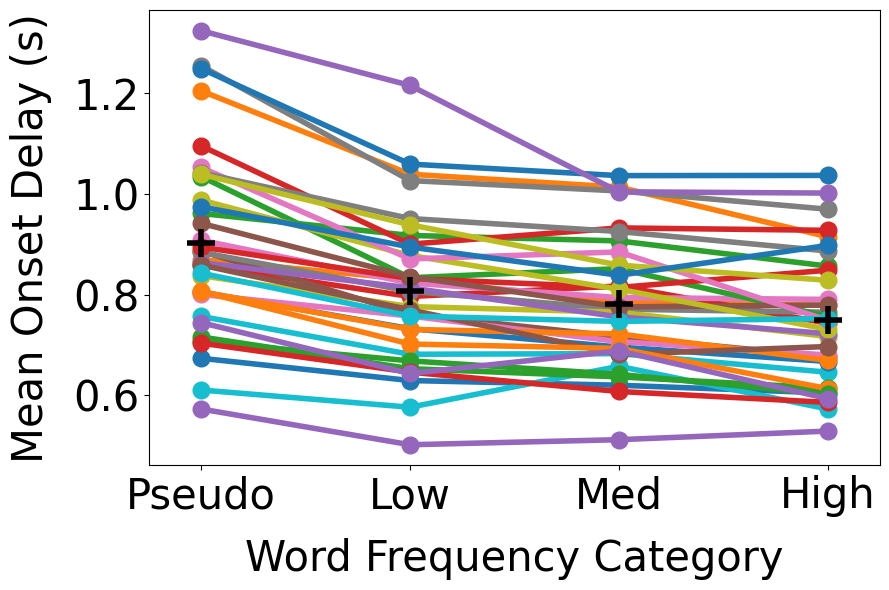

In [80]:
## plotting average onset delays by WF group
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (od_avgs[od_avgs['wf_type'] == 'pseudo']['onset_delay'],
    od_avgs[od_avgs['wf_type'] == 'lowwf']['onset_delay'],
    od_avgs[od_avgs['wf_type'] == 'medwf']['onset_delay'],
    od_avgs[od_avgs['wf_type'] == 'highwf']['onset_delay'])

means = (np.mean(od_avgs[od_avgs['wf_type'] == 'pseudo']['onset_delay']),
        np.mean(od_avgs[od_avgs['wf_type'] == 'lowwf']['onset_delay']),
        np.mean(od_avgs[od_avgs['wf_type'] == 'medwf']['onset_delay']),
        np.mean(od_avgs[od_avgs['wf_type'] == 'highwf']['onset_delay']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-1, 30])
plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Onset Delay (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meanod_bywf.png', dpi=300)
plt.show()

In [81]:
## defining function to calculate delta onset delay
    
def deltaod(dataframe):
    # DF = dataframe.query('string == @string')
    dataframe = dataframe.rename(columns = {'key_resp.rt.1':'onset_delay'})
    deltaods = pd.DataFrame(dataframe.groupby(['sID', 'string']).onset_delay.agg(['diff']))
    dataframe.insert(len(dataframe.columns), 'delta_od', deltaods)
    return dataframe

def indiv_meandeltaod(dataframe, sort_type):
    # DF = dataframe[dataframe['wf_type'] == sort_type]
    DF = dataframe[dataframe.string.isin(sort_type)]
    DF = deltaod(DF)
    mean_deltaods = DF.groupby(['sID']).delta_od.agg(['mean']).reset_index()
    mean_deltaods = mean_deltaods.rename(columns={'mean' : 'mean_deltaod'})
    return mean_deltaods

In [82]:
## anova on delta onset delay comparisons across WF

deltaod_anova = pg.rm_anova(deltaod(corr_trials), 'onset_delay', 'wf_type', 'sID')
print(deltaod_anova)
pg.pairwise_tukey(deltaod(corr_trials), 'onset_delay', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3    102  92.958619  4.590914e-29  0.133272  0.651491


A       B   mean(A)   mean(B)      diff        se          T  \
0  highwf   lowwf  0.752405  0.808314 -0.055908  0.006535  -8.555750   
1  highwf   medwf  0.752405  0.782391 -0.029985  0.006522  -4.597520   
2  highwf  pseudo  0.752405  0.903127 -0.150721  0.006535 -23.062329   
3   lowwf   medwf  0.808314  0.782391  0.025923  0.006564   3.949564   
4   lowwf  pseudo  0.808314  0.903127 -0.094813  0.006577 -14.416336   
5   medwf  pseudo  0.782391  0.903127 -0.120736  0.006564 -18.392776   

        p-tukey     cohen  
0  2.574163e-12 -0.282528  
1  2.572192e-05 -0.157602  
2  2.574163e-12 -0.673718  
3  4.582293e-04  0.128598  
4  2.574163e-12 -0.405460  
5  2.574163e-12 -0.531390

<Figure size 640x480 with 0 Axes>

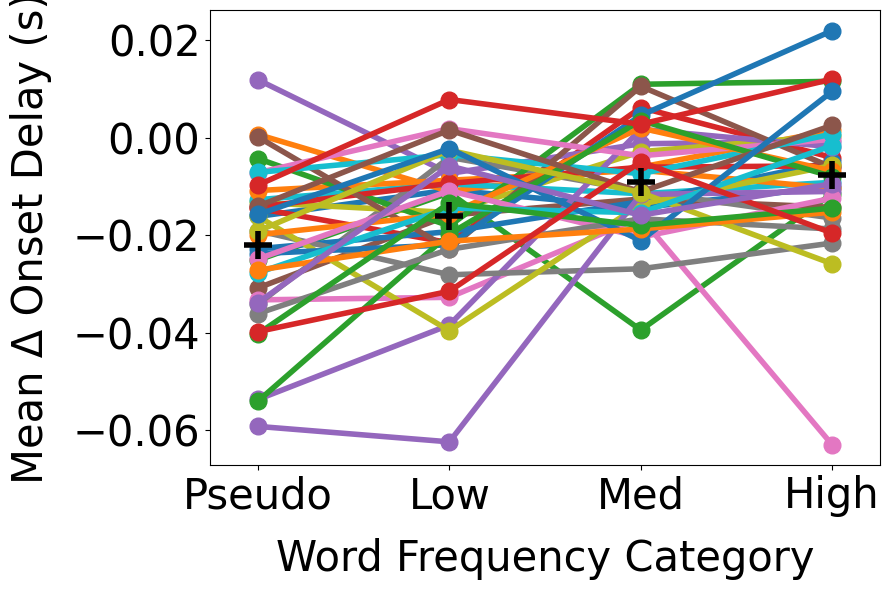

In [83]:
## plotting mean delta onset delays across WF
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')
# plt.rcParams['font.size'] = '30']

x = [2, 4, 6, 8]
D = (indiv_meandeltaod(corr_trials, typ.pseudo)['mean_deltaod'],
    indiv_meandeltaod(corr_trials, typ.lowwf)['mean_deltaod'],
    indiv_meandeltaod(corr_trials, typ.medwf)['mean_deltaod'],
    indiv_meandeltaod(corr_trials, typ.highwf)['mean_deltaod'])

means = (np.mean(indiv_meandeltaod(corr_trials, typ.pseudo)['mean_deltaod']),
        np.mean(indiv_meandeltaod(corr_trials, typ.lowwf)['mean_deltaod']),
        np.mean(indiv_meandeltaod(corr_trials, typ.medwf)['mean_deltaod']),
        np.mean(indiv_meandeltaod(corr_trials, typ.highwf)['mean_deltaod']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-1, 30])
plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize = 30)
plt.ylabel("Mean Δ Onset Delay (s)", labelpad=15, fontsize = 30)

plt.title("")

fig.tight_layout()
plt.savefig(save_dir + '/meandeltaod_bywf.png', dpi=300)
plt.show()

In [84]:
pseudo_only = corr_trials[corr_trials['wf_type'] == 'pseudo'].rename(columns = {'key_resp.rt.1':'onset_delay'})
pseudo_ods = pseudo_only.groupby(['sID', 'rep_num']).onset_delay.agg(['mean']).reset_index()

<Figure size 640x480 with 0 Axes>

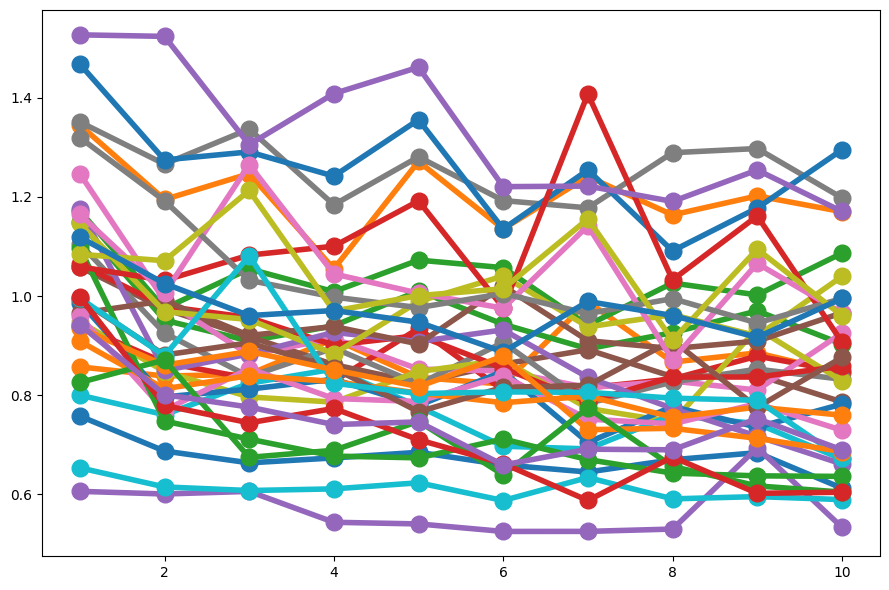

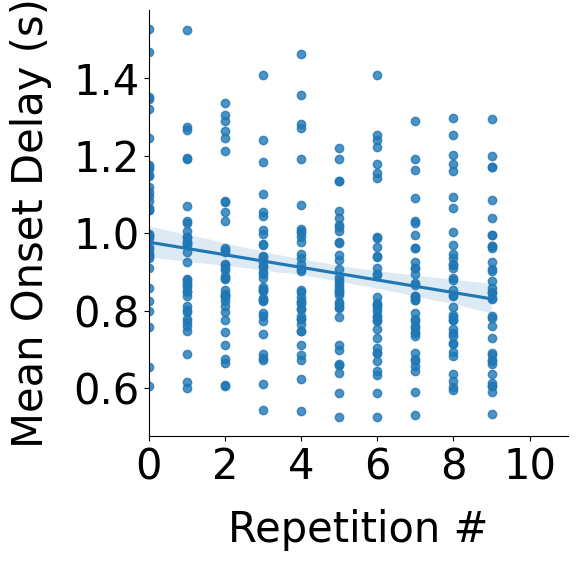

In [85]:
## plot pseudo ods over trials across individuals
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = list(range(1,11))
D = (pseudo_ods[pseudo_ods['rep_num'] == 0]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 1]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 2]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 3]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 4]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 5]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 6]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 7]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 8]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 9]['mean'])

# means = (np.mean(od_avgs[od_avgs['wf_type'] == 'pseudo']['key_resp.rt.1']),
#         np.mean(od_avgs[od_avgs['wf_type'] == 'lowwf']['key_resp.rt.1']),
#         np.mean(od_avgs[od_avgs['wf_type'] == 'medwf']['key_resp.rt.1']),
#         np.mean(od_avgs[od_avgs['wf_type'] == 'highwf']['key_resp.rt.1']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
sb.lmplot(x="rep_num", y="mean", data=pseudo_ods)
# ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([0.6, 0.65])
plt.xlim([0, 11])
plt.xticks(fontsize=30)
plt.xlabel("Repetition #", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Onset Delay (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meanod_byrep.png', dpi=300)
plt.show()

In [86]:
## pearson correlation for 
print(pearsonr(pseudo_ods['mean'], pseudo_ods['rep_num']))

PearsonRResult(statistic=-0.2368427652218771, pvalue=7.500835006049274e-06)


## Repetition Effects

In [87]:
## last rep - first rep IKI (effect of repetition on speed)
first_rep = corr_trials_bybg[corr_trials_bybg['rep_num'] == 0].reset_index(drop=True)
first_rep = first_rep.sort_values(by=['sID', 'string', 'bigram_loc'])
last_rep = corr_trials_bybg[corr_trials_bybg['rep_num'] == 9].reset_index(drop=True)
last_rep = last_rep.sort_values(by=['sID', 'string', 'bigram_loc'])

rep_effect = pd.concat([first_rep, last_rep])
rep_effect

iki_anova = pg.rm_anova(rep_effect, 'IKI', 'rep_num', 'sID')
print(iki_anova)

pg.pairwise_tukey(rep_effect, 'IKI', 'rep_num', effsize='cohen')

    Source  ddof1  ddof2          F     p-unc       ng2  eps
0  rep_num      1     34  34.653743  0.000001  0.071384  1.0


A  B   mean(A)   mean(B)      diff        se         T       p-tukey  \
0  0  9  0.182288  0.160205  0.022083  0.002489  8.872669  4.679590e-13   

      cohen  
0  0.219589

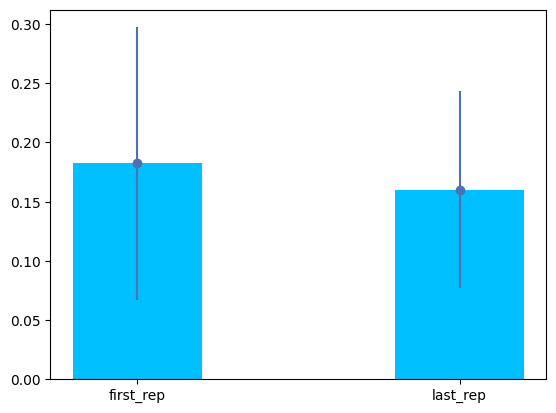

In [88]:
## plotting overall bg repetition effect
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = ('first_rep', 'last_rep')
D = (first_rep.IKI.mean(), last_rep.IKI.mean())
sds = (first_rep.IKI.std(), last_rep.IKI.std())

plt.bar(x, D, color = 'deepskyblue', width = 0.4)
plt.errorbar(x, D, yerr=sds, fmt="o", color="b")

plt.show()

In [89]:
## repetition effect of high freq bgs
highbf_firstrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 0) & (corr_trials_bybg['bf_type'] == 'high')].reset_index()
highbf_firstrep = highbf_firstrep.sort_values(by=['sID', 'string', 'bigram_loc'])
highbf_lastrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 9) & (corr_trials_bybg['bf_type'] == 'high')].reset_index()
highbf_lastrep = highbf_lastrep.sort_values(by=['sID', 'string', 'bigram_loc'])

highbf_diffs = (highbf_lastrep.IKI - highbf_firstrep.IKI)

## repetition effect of low freq bgs
lowbf_firstrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 0) & (corr_trials_bybg['bf_type'] == 'low')].reset_index()
lowbf_firstrep = lowbf_firstrep.sort_values(by=['sID', 'string', 'bigram_loc'])
lowbf_lastrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 9) & (corr_trials_bybg['bf_type'] == 'low')].reset_index()
lowbf_lastrep = lowbf_lastrep.sort_values(by=['sID', 'string', 'bigram_loc'])

lowbf_diffs = (lowbf_lastrep.IKI - lowbf_firstrep.IKI)

pg.ttest(highbf_diffs, lowbf_diffs)

T          dof alternative     p-val         CI95%  cohen-d  \
T-test  3.939055  1436.031595   two-sided  0.000086  [0.01, 0.04]  0.18346   

           BF10     power  
T-test  107.539  0.984788

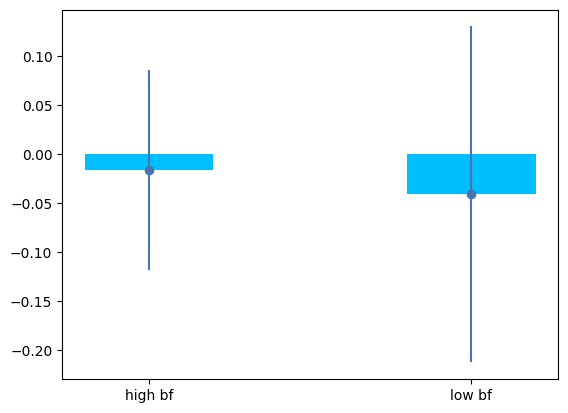

In [90]:
## plotting repetition effect on high vs low freq bgs
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = ('high bf', 'low bf')
D = (highbf_diffs.mean(), lowbf_diffs.mean())
sds = (highbf_diffs.std(), lowbf_diffs.std())

plt.bar(x, D, color = 'deepskyblue', width = 0.4)
plt.errorbar(x, D, yerr=sds, fmt="o", color="b")

plt.show()

In [91]:
## repetition effect of high freq wfs
highwf_firstrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 0) & (corr_trials_bybg['wf_type'] == 'high')].reset_index()
highwf_firstrep = highwf_firstrep.sort_values(by=['sID', 'string', 'bigram_loc'])
highwf_lastrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 9) & (corr_trials_bybg['wf_type'] == 'high')].reset_index()
highwf_lastrep = highwf_lastrep.sort_values(by=['sID', 'string', 'bigram_loc'])

highwf_diffs = (highwf_lastrep.IKI - highwf_firstrep.IKI).reset_index(drop=True)

## repetition effect of low freq wfs
lowwf_firstrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 0) & (corr_trials_bybg['wf_type'] == 'low')].reset_index()
lowwf_firstrep = lowwf_firstrep.sort_values(by=['sID', 'string', 'bigram_loc'])
lowwf_lastrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 9) & (corr_trials_bybg['wf_type'] == 'low')].reset_index()
lowwf_lastrep = lowwf_lastrep.sort_values(by=['sID', 'string', 'bigram_loc'])

lowwf_diffs = (lowwf_lastrep.IKI - lowwf_firstrep.IKI).reset_index(drop=True)

pg.ttest(highwf_diffs, lowwf_diffs)

T          dof alternative     p-val         CI95%   cohen-d  \
T-test  3.090798  1418.419672   two-sided  0.002035  [0.01, 0.03]  0.153064   

         BF10     power  
T-test  6.216  0.873664

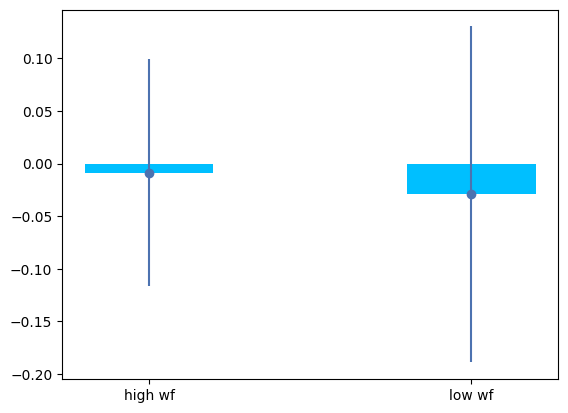

In [92]:
## plotting repetition effect on high vs low freq wfs
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = ('high wf', 'low wf')
D = (highwf_diffs.mean(), lowwf_diffs.mean())
sds = (highwf_diffs.std(), lowwf_diffs.std())

plt.bar(x, D, color = 'deepskyblue', width = 0.4)
plt.errorbar(x, D, yerr=sds, fmt="o", color="b")

plt.show()

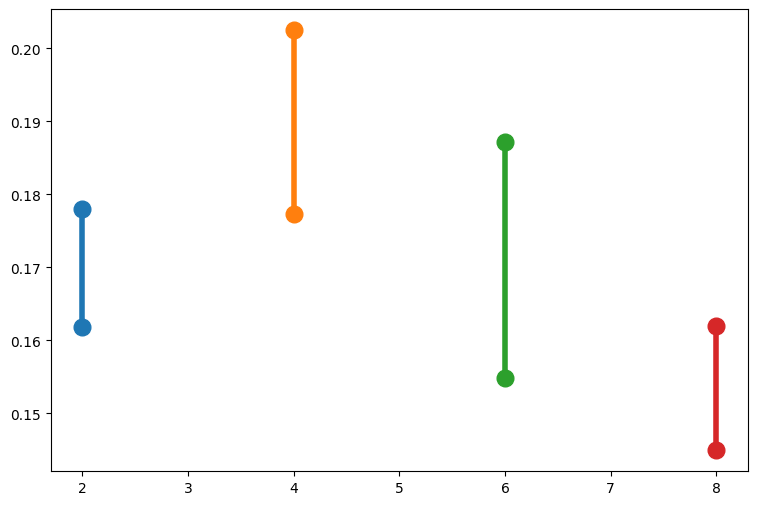

In [93]:
first_reps = corr_trials_bybg[corr_trials_bybg['rep_num'] == 0].sort_values(by=['sID', 'string', 'bigram_loc'])
last_reps = corr_trials_bybg[corr_trials_bybg['rep_num'] == 9].sort_values(by=['sID', 'string', 'bigram_loc'])

x = [(2, 4, 6, 8), (2, 4, 6, 8)]
D = (first_reps.groupby('bigram_loc').IKI.mean(),
     last_reps.groupby('bigram_loc').IKI.mean())

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
plt.show()

## Bigram-Word Interaction
___

In [94]:
## prints number of repetitions of each bigram within the string bank
rep_df = pd.DataFrame()
for bigram in typ.all_bigrams:
    rep_num = 0
    for string in typ.all_strings:
        if bigram in string:
            rep_num = rep_num + 1
    # print(bigram, rep_num)

In [95]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'edthe' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sb.set(rc={"figure.figsize":(8, 4)})
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sb.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("cornflowerblue")
    pc.set_edgecolor("cornflowerblue")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('he', 'eo', 'on', 'nd'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig('heond_dist.png', dpi=300, transparent = True)

In [96]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'think' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sb.set(rc={"figure.figsize":(8, 4)})
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sb.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("tomato")
    pc.set_edgecolor("tomato")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('th', 'hi', 'in', 'nk'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig('think_dist.png', dpi=300, transparent = True)

In [97]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'theme' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sb.set(rc={"figure.figsize":(8, 4)})
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sb.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("goldenrod")
    pc.set_edgecolor("goldenrod")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('th', 'he', 'em', 'me'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig('theme_dist.png', dpi=300, transparent = True)

In [98]:
## distribution of a bigram's IKIs for each word it occurs in (correct trials, one individual)    
strings_with_onesub = pd.DataFrame()
for string in typ.all_strings:
    bigram = 'th' ## edit bigram of interest here
    if bigram in string:
         strings_with_onesub[string] = corr_trials_bybg[(corr_trials_bybg.sID == 's180') ## edit sID here 
                                              & (corr_trials_bybg.bigram == bigram) 
                                              & (corr_trials_bybg.string == string)]['IKI'].reset_index(drop = True)
strings_with_onesub

sb.set(rc={"figure.figsize":(8, 4)})
sb.violinplot(data=strings_with_onesub)

<Axes: xlabel='Bigram within word', ylabel='IKI (s)'>

In [99]:
## distribution of a bigram's IKIs for each word it occurs in (correct trials, all individuals)
strings_with = pd.DataFrame()

for string in typ.all_strings:
        bigram = 'he' ## edit bigram of interest here
        if bigram in string:
                temp = corr_trials_bybg[(corr_trials_bybg.bigram == bigram) 
                                        & (corr_trials_bybg.string == string)]['IKI'].reset_index(drop = True)
                strings_with[string] = temp

strings_with

sb.set(rc={"figure.figsize":(8, 4)})
sb.violinplot(data=strings_with)

<Axes: xlabel='Bigram within word', ylabel='IKI (s)'>

In [100]:
## distribution of a bigram's ~INDIVIDUAL MEAN~ IKIs for each word it occurs in (correct trials, all individuals)
strings_with = pd.DataFrame()
for index, ID in enumerate(ID_list):
    strings_with.loc[index, 'sID'] = ID
    for string in typ.all_strings:
        bigram = 're' ## edit bigram of interest here
        if bigram in string:
             strings_with.loc[index, string] = corr_trials_bybg[(corr_trials_bybg.sID == ID) 
                                                  & (corr_trials_bybg.bigram == bigram) 
                                                  & (corr_trials_bybg.string == string)]['IKI'].mean()

strings_with

sb.set(rc={"figure.figsize":(8, 4)})
sb.violinplot(data=strings_with)

<Axes: xlabel='Bigram within word', ylabel='IKI (s)'>

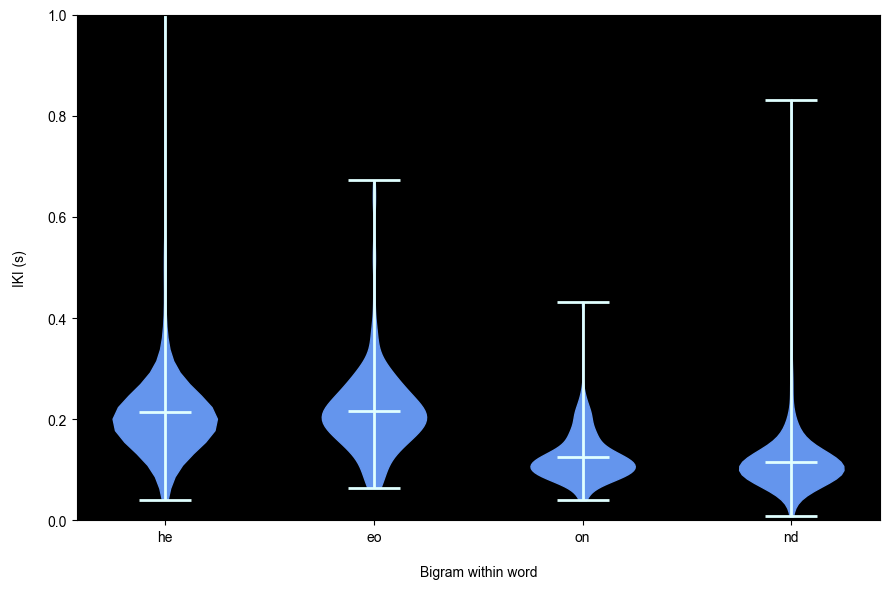

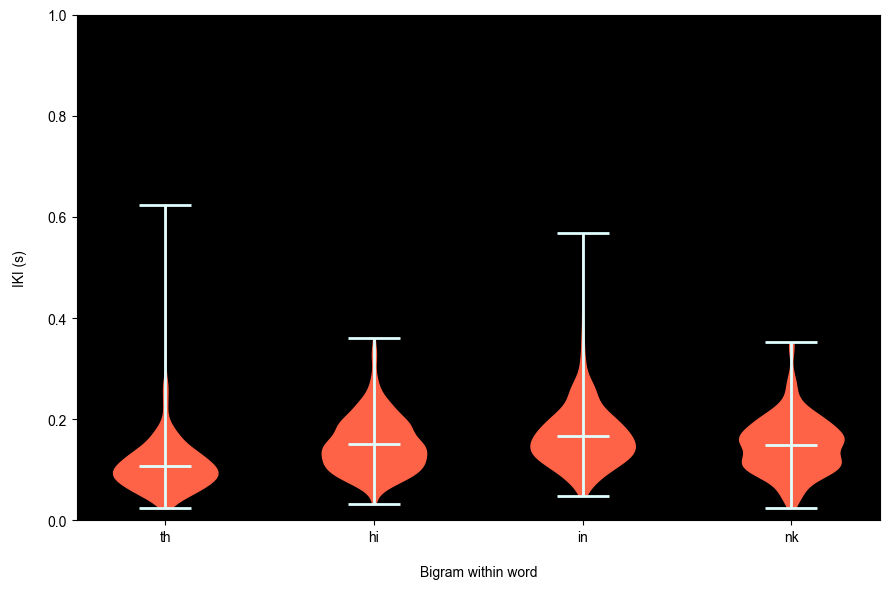

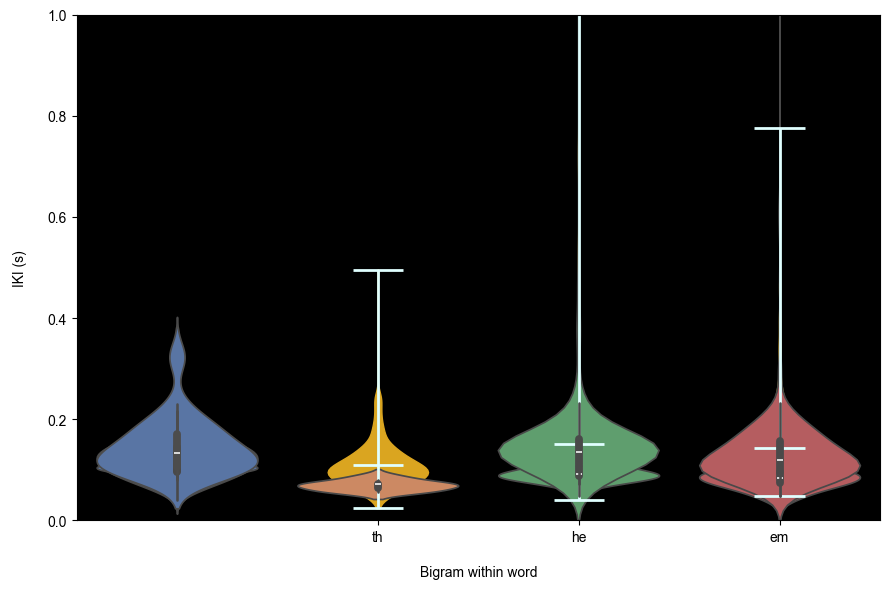

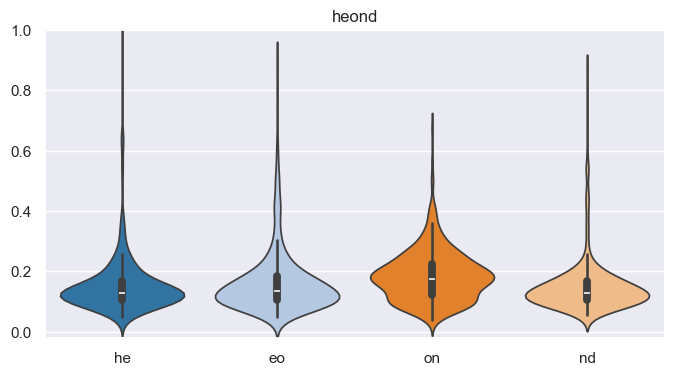

In [101]:
string = 'heond' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sb.set(rc={"figure.figsize":(8, 4)})
fig, ax = plt.subplots()
# sb.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sb.violinplot(data=DF, palette='tab20', ax=ax).set(title = string)
ax.set_ylim(-0.02,1)
plt.show()

In [102]:
## plot showing iki distributions for bigrams in each word (correct trials, all individuals)
fig, axs = plt.subplots(8, 3, figsize=(25, 25))
fig.subplots_adjust(hspace=0.3)
#axs.set_ylim([0,2])

for y, freq in enumerate(typ.avgbf_types):
    for x, string in enumerate(freq):
        DF = corr_trials[corr_trials.string == string]
        DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
        bgs = typ.bi_byword(string)
        DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})
        sb.violinplot(data=DF, ax=axs[x,y]).set(title = string)
        axs[x,y].set_ylim([-0.1,1])
        

In [103]:
## plot showing iki distributions for bigrams in each word for one participant (correct trials)

fig, axs = plt.subplots(8, 3, figsize=(25, 25))
fig.subplots_adjust(hspace=0.3)

for y, freq in enumerate(typ.avgbf_types):
    for x, string in enumerate(freq):
        DF = corr_trials[(corr_trials.string == string)
                        & (corr_trials.sID == 's175')] ## change ID here
        DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
        bgs = typ.bi_byword(string)
        DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})
        sb.violinplot(data=DF, ax=axs[x,y]).set(title = string)
        axs[x,y].set_ylim([-0.1,1])

In [104]:
def wf_order_effects(bigram, first_wf, second_wf):
    b2b = pd.DataFrame()
    for sID in ID_list:
        DF = pd.DataFrame(corr_trials_bybg[(corr_trials_bybg['sID'] == sID) 
                          & (corr_trials_bybg['bigram'] == bigram)]).reset_index(drop=True)
        for index, data in enumerate(DF):
            if DF.loc[index, 'trial_num'] == DF.loc[index+1, 'trial_num'] - 1:
                if DF.loc[index, 'wf_type'] == first_wf and DF.loc[index+1, 'wf_type'] == second_wf:
                    # temp1 = pd.DataFrame(DF.loc[index]).T.reset_index(drop = True)
                    temp2 = pd.DataFrame(DF.loc[index+1]).T.reset_index(drop = True)
                    b2b = pd.concat([b2b, temp2])
    return b2b

In [105]:
wf_order_effects('th', 'high', 'pseudo')

sID bigram_num trial_num rep_num bigram_loc bigram resp_bigram       IKI  \
0  s182        126        31       1          2     th          th  0.080062   
0  s189        206        51       0          2     th          th  0.136012   
0  s189        327        81       1          2     th          th  0.119986   
0  s240         50        12       0          2     th          th  0.096007   
0  s304        201        50       2          2     th          th  0.120032   

  string resp_string     bg_freq bf_type meanbf_type wf_type trial_corr  \
0  edthe       edthe  22288309.0    high        high  pseudo        NaN   
0  edthe       edthe  22288309.0    high        high  pseudo        NaN   
0  edthe       edthe  22288309.0    high        high  pseudo        NaN   
0  edthe       edthe  22288309.0    high        high  pseudo       corr   
0  edthe       edthe  22288309.0    high        high  pseudo       corr   

  bg_corr  
0     NaN  
0     NaN  
0     NaN  
0    corr  
0    corr

In [106]:
def b2b_diff(wf1, wf2):
    DF = pd.concat([wf_order_effects('th', wf1, wf2), wf_order_effects('he', wf1, wf2)]) 
    ## only 'th' and 'he' are represnted across all WF groups
    diffs = pd.DataFrame(DF.IKI.diff()).reset_index(drop = True)
    diffs = diffs.iloc[1::2, :]
    diffs['comparison'] = (wf1 + ' to ' + wf2)
    return diffs

b2b_diff('high', 'pseudo')

IKI      comparison
1   0.05595  high to pseudo
3 -0.023979  high to pseudo
5  0.015922  high to pseudo
7 -0.048206  high to pseudo

In [107]:
## anova for high to pseudo and high to high order effects on 'th' and 'he'
diffs = pd.concat([b2b_diff('pseudo', 'high'), 
                   b2b_diff('pseudo', 'med'), 
                   b2b_diff('pseudo', 'low'), 
                   b2b_diff('pseudo', 'pseudo')], ignore_index=True)
diffs['IKI'] = diffs['IKI'].astype('float64')

oe_anova = pg.anova(dv='IKI', data=diffs, between='comparison')
print(oe_anova)

       Source  ddof1  ddof2         F    p-unc       np2
0  comparison      3     18  0.242541  0.86551  0.038853


## Delta IKI

In [108]:
# def indiv_cvs_bybg(string, bigram):
#     DF = tight_bgs.query('string == @string and bigram == @bigram')
#     cvs = pd.DataFrame(DF.groupby('sID').IKI.agg([variation]))
#     return cvs

## defining functions that calculate indivdual IKI means and Avg. CVS by word and bigram groupings

# def indiv_means(dataframe, str_or_bg, sort_type): ## str_or_bg can be 'string' or 'bigram'
#     if str_or_bg == 'string':
#         DF = dataframe[dataframe.string.isin(sort_type)]
#     elif str_or_bg == 'bigram':
#         DF = dataframe[dataframe.bigram.isin(sort_type)]
#     means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg IKI'})
#     # means.columns = ['Avg IKI']
#     return means

# all_bigrams

# # def deltaiki(dataframe,):

# def deltaiki_bybg(dataframe, string, bigram):
#     DF = dataframe.query('string == @string and bigram == @bigram')
#     deltaikis = pd.DataFrame(DF.groupby('sID').IKI.agg(['diff'])).abs()
#     DF.insert(7, 'delta_iki', deltaikis)
#     # deltaikis.insert(0, 'sID', DF['sID'])
#     # for ID in ID_list:
#     #     deltaikis
#     # return DF.get_group('s210')
#     # return DF[DF.sID == 's209']
#     return DF
#     # return deltaikis
    
# # def indiv_deltaiki_bybg(dataframe, string, bigram):
# #     # DF = 
# #     DF = deltaiki_bybg(dataframe, string, bigram)
# #     DF = DF[DF.sID == sID].reset_index().drop(0)
# #     return DF

# # indiv_deltaiki_bybg('s209', all_bigrams, 'there', 'th')

# def deltaod(dataframe):
#     # DF = dataframe.query('string == @string')
#     dataframe = dataframe.rename(columns = {'key_resp.rt.1':'onset_delay'})
#     deltaods = pd.DataFrame(dataframe.groupby(['sID', 'string']).onset_delay.agg(['diff']))
#     dataframe.insert(len(dataframe.columns), 'delta_od', deltaods)
#     return dataframe

# def indiv_meandeltaod(dataframe, sort_type):
#     DF = dataframe[dataframe['wf_type'] == sort_type]
#     DF = deltaod(DF)
#     mean_deltaods = DF.groupby(['sID']).delta_od.agg(['mean']).reset_index()
#     return mean_deltaods

# def indiv_avgcvs(dataframe, str_or_bg, sort_type):
#     if str_or_bg == 'string':
#         DF = dataframe[dataframe.string.isin(sort_type)]
#     else:
#         DF = dataframe[dataframe.bigram.isin(sort_type)]
#     cvs = DF.groupby(['sID', str_or_bg]).IKI.agg([variation])
#     avg_cvs = pd.DataFrame(cvs.groupby('sID').variation.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg CV IKI'})
#     # avg_cvs.columns = ['Avg CV IKI']
#     return avg_cvs

# def indiv_deltaikis(dataframe, str_or_bg, sort_type):
#     if str_or_bg == 'string':
#         DF = dataframe[dataframe.string.isin(sort_type)]
#     else:
#         DF = dataframe[dataframe.bigram.isin(sort_type)]
#     deltas = pd.DataFrame(DF.groupby(['sID', str_or_bg]).IKI.agg(['diff'])).abs().reset_index(drop=True)
#     deltas = deltas.rename(columns={'diff':'deltaiki'})
#     return deltas


def deltaiki(dataframe):
    # dataframe = dataframe.rename(columns = {'key_resp.rt.1':'onset_delay'})
    deltaikis = pd.DataFrame(dataframe.groupby(['sID', 'string', 'bigram']).IKI.agg(['diff']))
    deltaikis.fillna(0, inplace=True)
    if 'delta_iki' in dataframe.columns:
        dataframe.replace(dataframe['delta_iki'], deltaikis)
    else:
        dataframe.insert(len(dataframe.columns), 'delta_iki', deltaikis)
    return dataframe

def indiv_meandeltaiki(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    else:
        print('use "string" or "bigram"')
    DF = deltaiki(DF)
    mean_deltaikis = DF.groupby(['sID']).delta_iki.agg(['mean']).reset_index()
    mean_deltaikis = mean_deltaikis.rename(columns={'mean' : 'mean_deltaiki'})
    return mean_deltaikis

In [109]:
test = deltaiki(corr_trials_bybg)
# test[test['rep_num'] == 0].sort_values(['trial_num'])
test[(test['sID'] == 's254') & (test['string'] == 'there') & (test['bigram'] == 'th')]

sID  bigram_num  trial_num  rep_num  bigram_loc bigram resp_bigram  \
20668  s254         110         29        0           0     th          th   
20680  s254         122         32        1           0     th          th   
20844  s254         298         76        2           0     th          th   
20884  s254         338         86        3           0     th          th   
20924  s254         390         99        4           0     th          th   
21020  s254         488        124        5           0     th          th   
21092  s254         570        145        6           0     th          th   
21224  s254         716        181        7           0     th          th   
21364  s254         865        219        8           0     th          th   

            IKI string resp_string     bg_freq bf_type meanbf_type wf_type  \
20668  0.184101  there       there  22288309.0    high        high    high   
20680  0.248133  there       there  22288309.0    high        high    high   
20844  0.152131  there       there  22288309.0    high        high    high   
20884  0.135969  there       there  22288309.0    high        high    high   
20924  0.128088  there       there  22288309.0    high        high    high   
21020  0.144111  there       there  22288309.0    high        high    high   
21092  0.184144  there       there  22288309.0    high        high    high   
21224  0.192128  there       there  22288309.0    high        high    high   
21364  0.136103  there       there  22288309.0    high        high    high   

      trial_corr bg_corr  delta_iki  
20668       corr    corr   0.000000  
20680       corr    corr   0.064032  
20844       corr    corr  -0.096002  
20884       corr    corr  -0.016162  
20924       corr    corr  -0.007881  
21020       corr    corr   0.016022  
21092       corr    corr   0.040034  
21224       corr    corr   0.007984  
21364       corr    corr  -0.056025

In [110]:
## anova on delta iki comparisons across WF
deltaiki_anova = pg.rm_anova(deltaiki(corr_trials_bybg.drop(9779)), 'delta_iki', 'wf_type', 'sID')
print(deltaiki_anova)
pg.pairwise_tukey(deltaiki(corr_trials_bybg.drop(9779)), 'delta_iki', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F     p-unc       ng2       eps
0  wf_type      3    102  10.749603  0.000003  0.130879  0.782043


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low -0.000607 -0.003303  0.002696  0.001314  2.052159  0.169109   
1  high     med -0.000607 -0.001668  0.001060  0.001311  0.808824  0.850331   
2  high  pseudo -0.000607 -0.003257  0.002649  0.001314  2.016851  0.181697   
3   low     med -0.003303 -0.001668 -0.001635  0.001319 -1.239424  0.601687   
4   low  pseudo -0.003303 -0.003257 -0.000046  0.001322 -0.034900  0.999985   
5   med  pseudo -0.001668 -0.003257  0.001589  0.001319  1.204346  0.624068   

      cohen  
0  0.033529  
1  0.014936  
2  0.031418  
3 -0.018816  
4 -0.000469  
5  0.017541

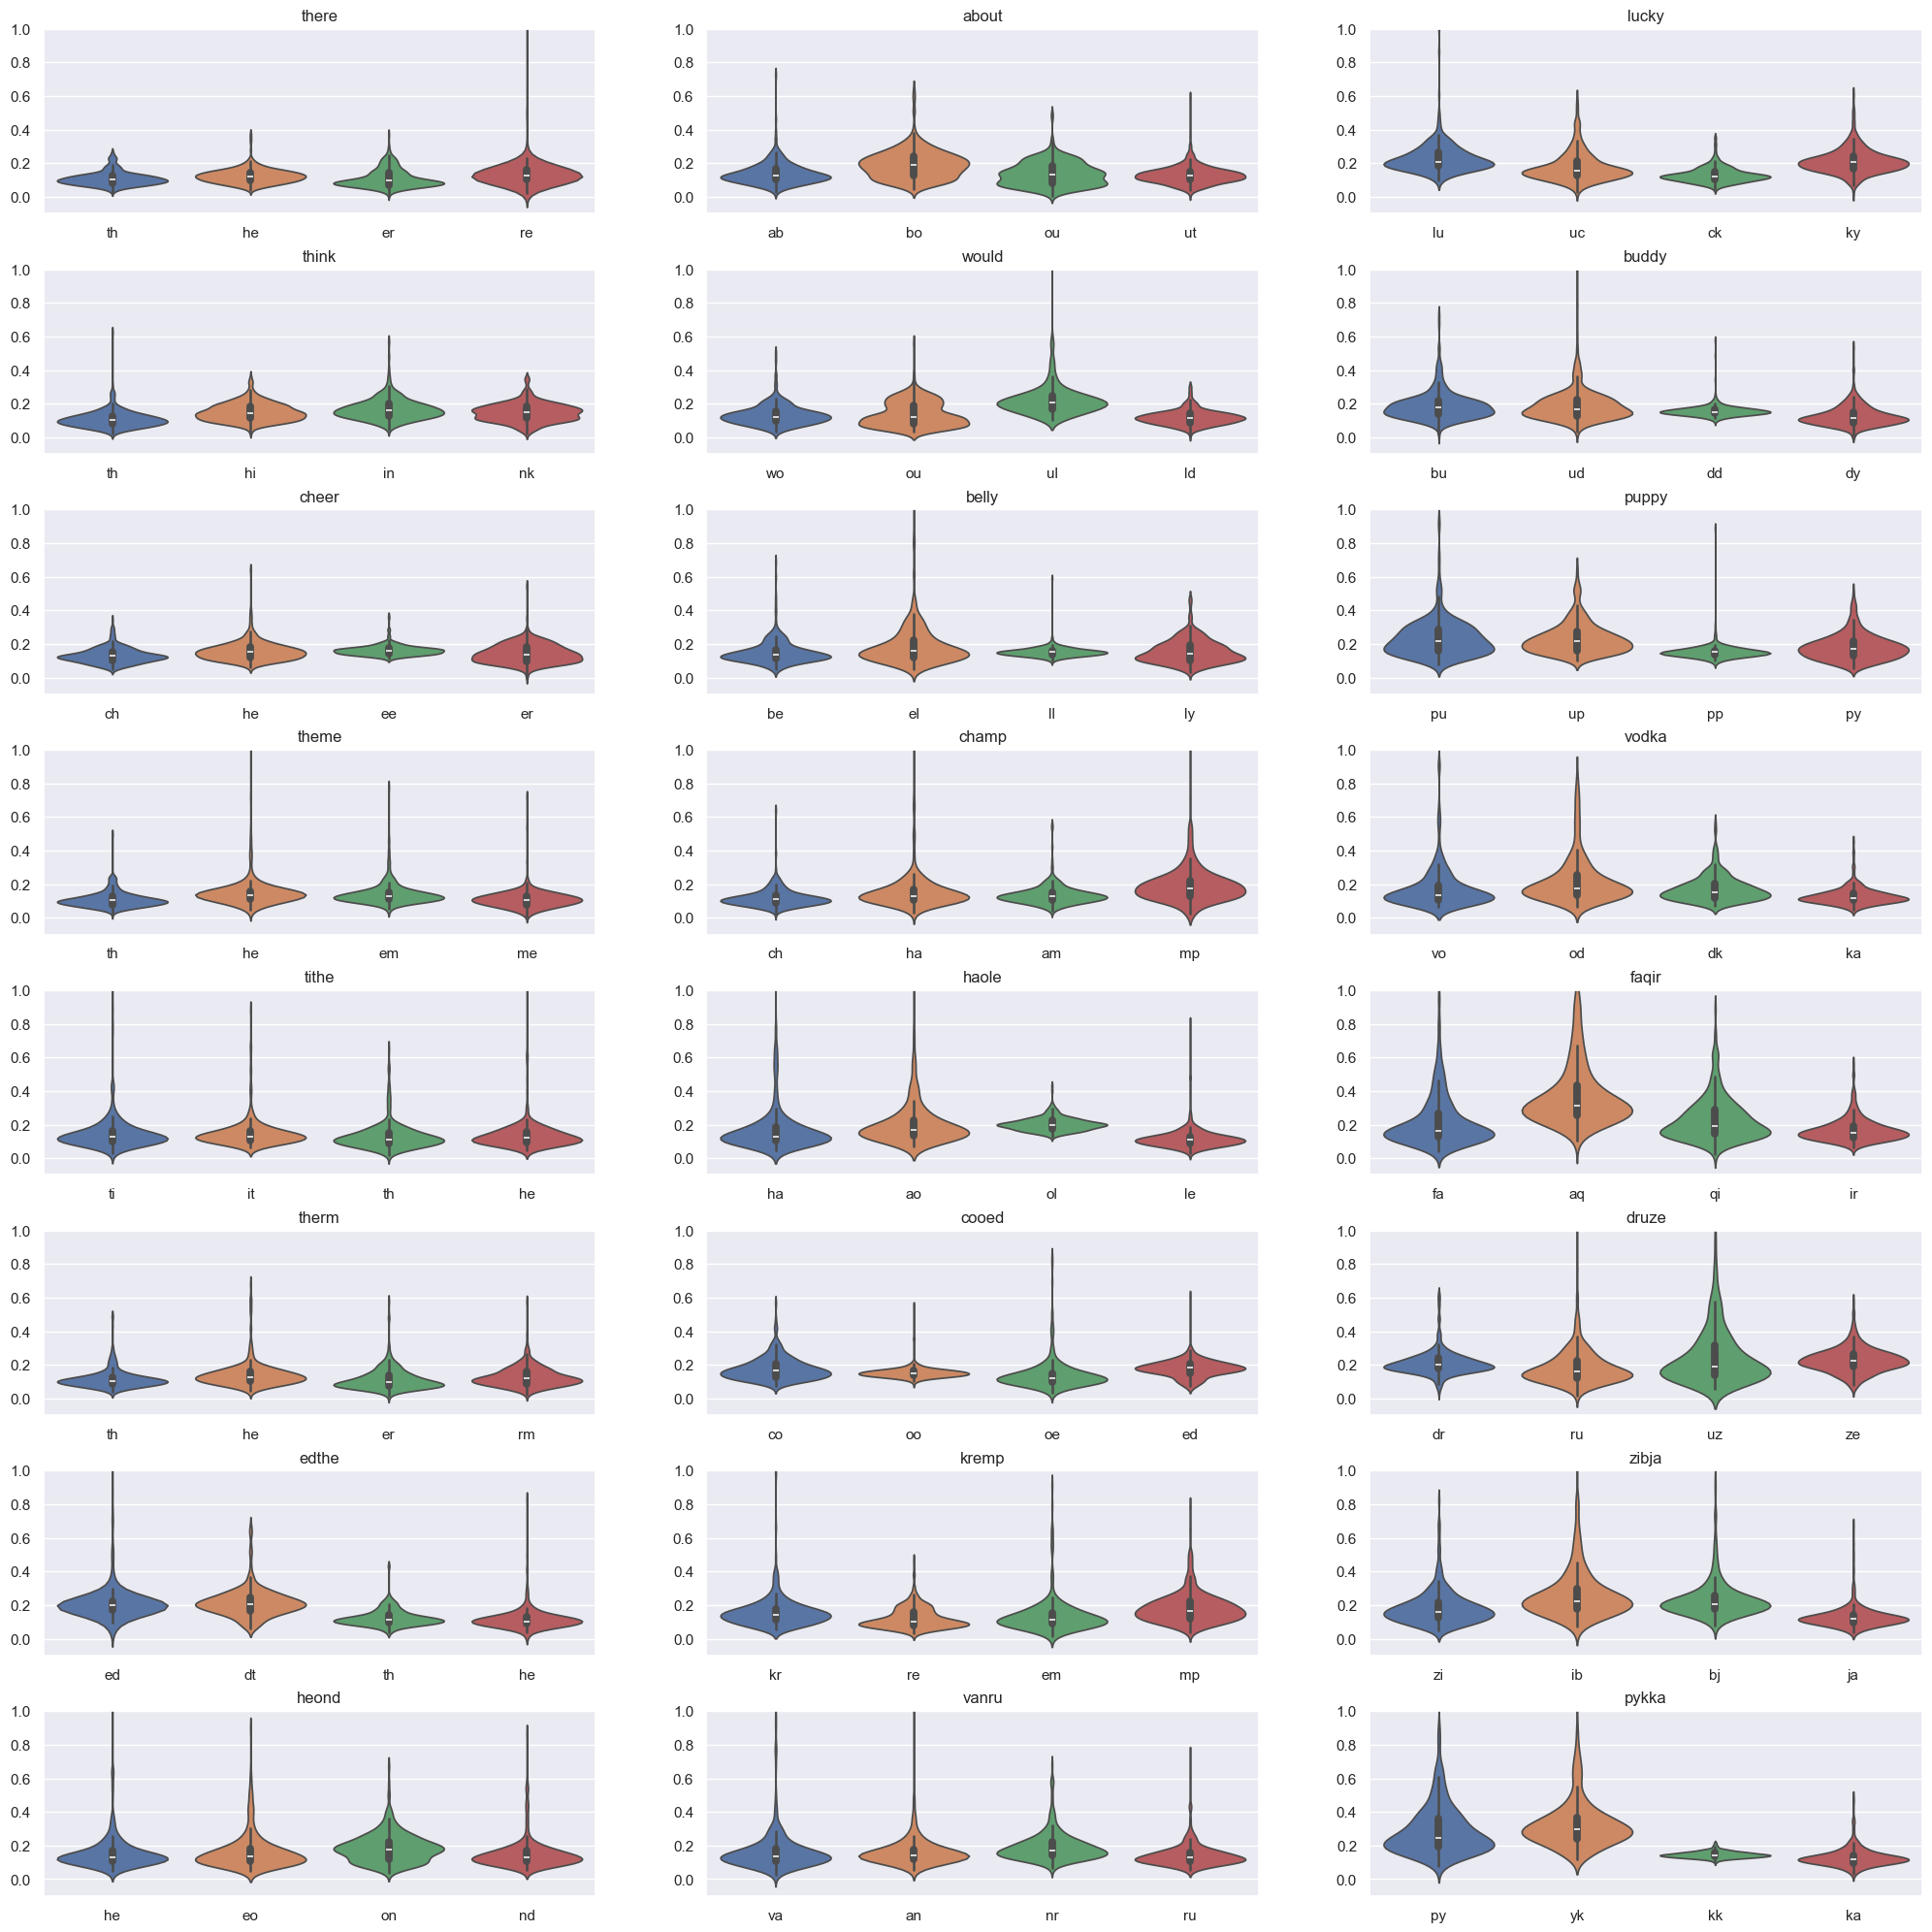

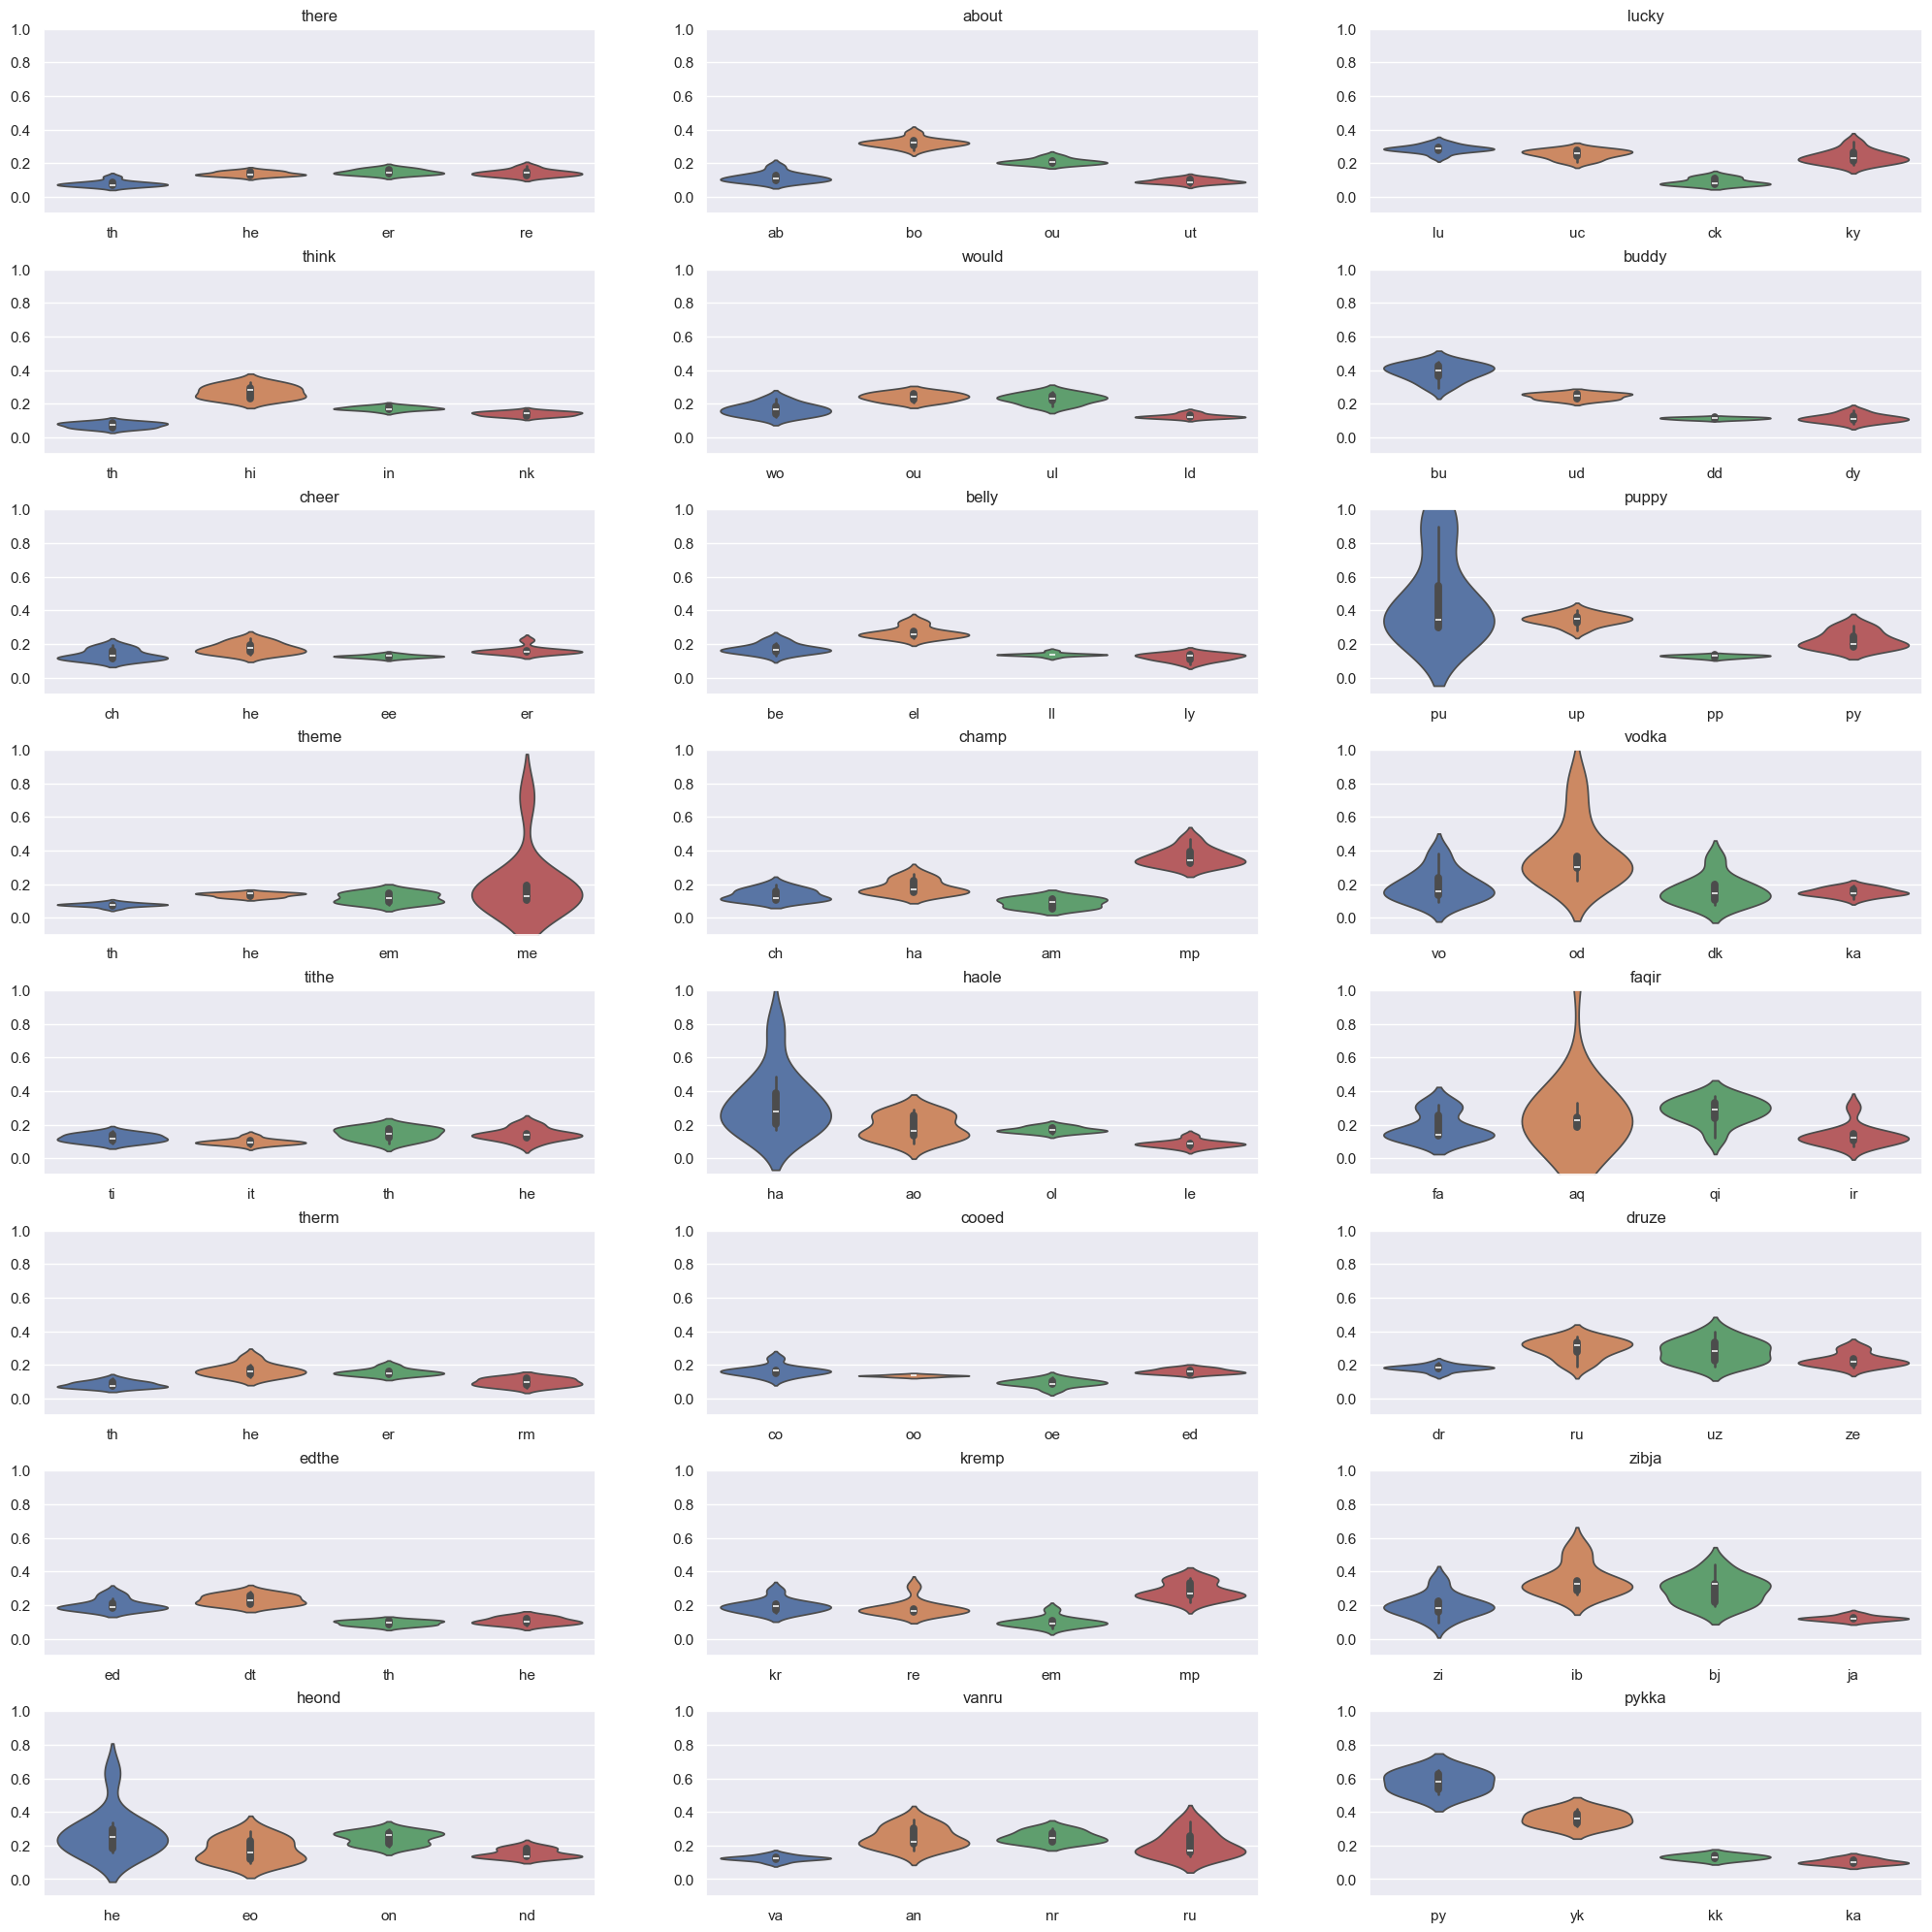

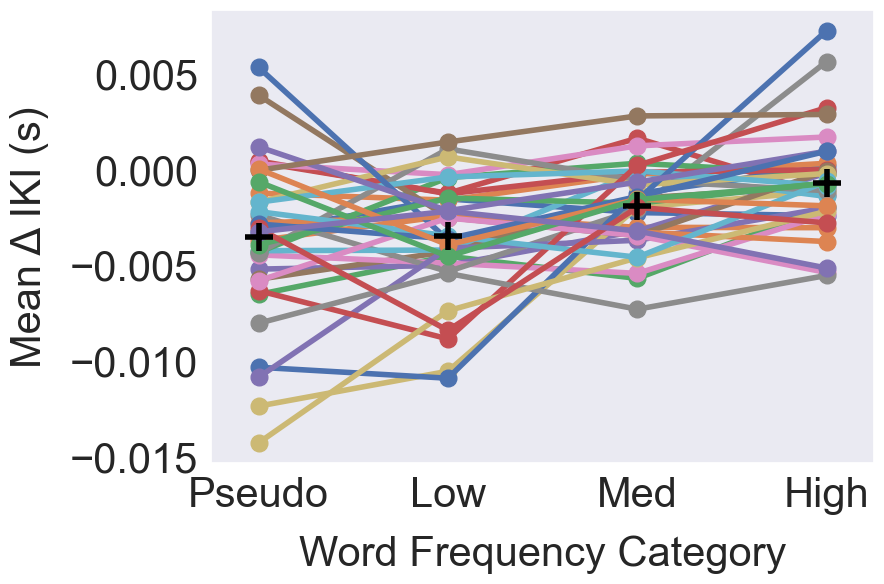

In [111]:
## plotting mean delta iki by WF group
# plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (indiv_meandeltaiki(corr_trials_bybg, 'string', typ.pseudo)['mean_deltaiki'],
    indiv_meandeltaiki(corr_trials_bybg, 'string', typ.lowwf)['mean_deltaiki'],
    indiv_meandeltaiki(corr_trials_bybg, 'string', typ.medwf)['mean_deltaiki'],
    indiv_meandeltaiki(corr_trials_bybg, 'string', typ.highwf)['mean_deltaiki'])

means = (np.mean(indiv_meandeltaiki(corr_trials_bybg, 'string', typ.pseudo)['mean_deltaiki']),
        np.mean(indiv_meandeltaiki(corr_trials_bybg, 'string', typ.lowwf)['mean_deltaiki']),
        np.mean(indiv_meandeltaiki(corr_trials_bybg, 'string', typ.medwf)['mean_deltaiki']),
        np.mean(indiv_meandeltaiki(corr_trials_bybg, 'string', typ.highwf)['mean_deltaiki']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-0.129, 0.06])
plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Δ IKI (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meandeltaiki_bywf.png', dpi=300)
plt.show()

In [112]:
pseudo_strings = corr_trials_bybg[corr_trials_bybg['wf_type'] == 'pseudo']
pseudo_ikis = pseudo_strings.groupby(['sID', 'rep_num']).IKI.agg(['mean']).reset_index()

<Figure size 640x480 with 0 Axes>

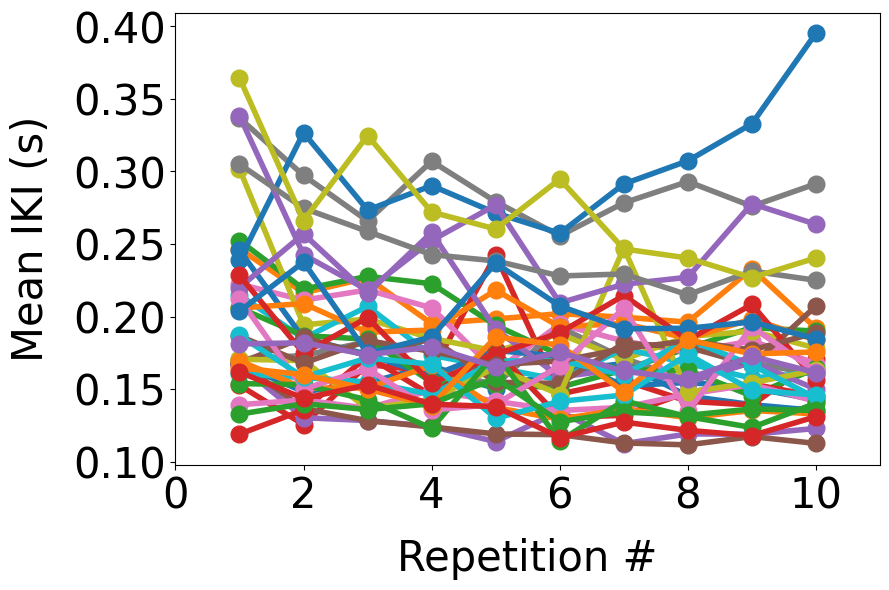

In [113]:
## plot pseudo ods over trials across individuals
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = list(range(1,11))
D = (pseudo_ikis[pseudo_ikis['rep_num'] == 0]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 1]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 2]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 3]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 4]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 5]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 6]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 7]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 8]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 9]['mean'])

# means = (np.mean(od_avgs[od_avgs['wf_type'] == 'pseudo']['key_resp.rt.1']),
#         np.mean(od_avgs[od_avgs['wf_type'] == 'lowwf']['key_resp.rt.1']),
#         np.mean(od_avgs[od_avgs['wf_type'] == 'medwf']['key_resp.rt.1']),
#         np.mean(od_avgs[od_avgs['wf_type'] == 'highwf']['key_resp.rt.1']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
# ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([0.6, 0.65])
plt.xlim([0, 11])
plt.xticks(fontsize=30)
plt.xlabel("Repetition #", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean IKI (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meaniki_byrep.png', dpi=300)
plt.show()

In [114]:
def total_deltaiki(dataframe):
    DF = dataframe[dataframe['rep_num'].isin([0,9])]
    total_delta = pd.DataFrame(DF.groupby(['sID', 'string', 'bigram']).IKI.agg(['diff']))
    total_delta.fillna(0, inplace=True)
    if 'totaldelta_iki' in dataframe.columns:
        dataframe.replace(dataframe['totaldelta_iki'], total_delta)
    else:
        dataframe.insert(len(dataframe.columns), 'totaldelta_iki', total_delta)
    return dataframe

In [115]:
## calculating the total difference in IKI across all repetitions

totals = total_deltaiki(corr_trials_bybg)
last_trials = totals[totals['rep_num'] == 9]
mean_totaldeltas = last_trials.groupby(['sID', 'wf_type']).totaldelta_iki.agg(['mean']).reset_index()
mean_totaldeltas = mean_totaldeltas.rename(columns={'mean':'mean_totaldeltaiki'})

In [116]:
test_totaldeltas = last_trials.groupby(['sID', 'bf_type']).totaldelta_iki.agg(['mean']).reset_index()
test_totaldeltas = test_totaldeltas.rename(columns={'mean':'mean_totaldeltaiki'})
# test_totaldeltas

totaldelta_anova = pg.rm_anova(test_totaldeltas, 'mean_totaldeltaiki', 'bf_type', 'sID')
print(totaldelta_anova)
pg.pairwise_tukey(test_totaldeltas, 'mean_totaldeltaiki', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  bf_type      2     68  17.371639  8.047980e-07  0.170085  0.791035


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low -0.018015 -0.040916  0.022901  0.006199  3.694470  0.001031   
1  high  med -0.018015 -0.015006 -0.003009  0.006199 -0.485421  0.878376   
2   low  med -0.040916 -0.015006 -0.025910  0.006199 -4.179890  0.000181   

      cohen  
0  0.801120  
1 -0.134605  
2 -0.979036

In [117]:
totaldelta_anova = pg.rm_anova(mean_totaldeltas, 'mean_totaldeltaiki', 'wf_type', 'sID')
print(totaldelta_anova)
pg.pairwise_tukey(mean_totaldeltas, 'mean_totaldeltaiki', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F     p-unc       ng2       eps
0  wf_type      3    102  10.352276  0.000005  0.130419  0.820742


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low -0.008330 -0.032893  0.024563  0.006704  3.663955  0.001992   
1  high     med -0.008330 -0.016209  0.007879  0.006704  1.175280  0.643455   
2  high  pseudo -0.008330 -0.032989  0.024659  0.006704  3.678281  0.001895   
3   low     med -0.032893 -0.016209 -0.016684  0.006704 -2.488676  0.066205   
4   low  pseudo -0.032893 -0.032989  0.000096  0.006704  0.014326  0.999999   
5   med  pseudo -0.016209 -0.032989  0.016780  0.006704  2.503002  0.063922   

      cohen  
0  0.961924  
1  0.340045  
2  0.798468  
3 -0.670450  
4  0.002984  
5  0.552933

In [118]:
totaldelta_anova = pg.rm_anova(mean_totaldeltas, 'mean_totaldeltaiki', 'wf_type', 'sID')
print(totaldelta_anova)
pg.pairwise_tukey(mean_totaldeltas, 'mean_totaldeltaiki', 'wf_type', effsize='cohen')

/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


    Source  ddof1  ddof2          F     p-unc       ng2       eps
0  wf_type      3    102  10.352276  0.000005  0.130419  0.820742


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low -0.008330 -0.032893  0.024563  0.006704  3.663955  0.001992   
1  high     med -0.008330 -0.016209  0.007879  0.006704  1.175280  0.643455   
2  high  pseudo -0.008330 -0.032989  0.024659  0.006704  3.678281  0.001895   
3   low     med -0.032893 -0.016209 -0.016684  0.006704 -2.488676  0.066205   
4   low  pseudo -0.032893 -0.032989  0.000096  0.006704  0.014326  0.999999   
5   med  pseudo -0.016209 -0.032989  0.016780  0.006704  2.503002  0.063922   

      cohen  
0  0.961924  
1  0.340045  
2  0.798468  
3 -0.670450  
4  0.002984  
5  0.552933

<Figure size 640x480 with 0 Axes>

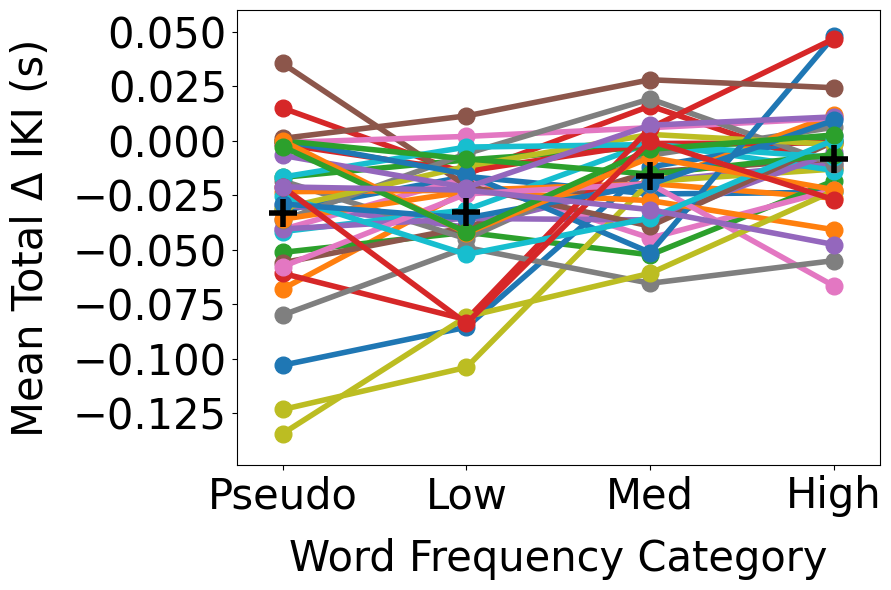

In [119]:
## plot pseudo ods over trials across individuals
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (mean_totaldeltas[mean_totaldeltas['wf_type'] == 'pseudo']['mean_totaldeltaiki'],
    mean_totaldeltas[mean_totaldeltas['wf_type'] == 'low']['mean_totaldeltaiki'],
    mean_totaldeltas[mean_totaldeltas['wf_type'] == 'med']['mean_totaldeltaiki'],
    mean_totaldeltas[mean_totaldeltas['wf_type'] == 'high']['mean_totaldeltaiki'])

means = (np.mean(mean_totaldeltas[mean_totaldeltas['wf_type'] == 'pseudo']['mean_totaldeltaiki']),
        np.mean(mean_totaldeltas[mean_totaldeltas['wf_type'] == 'low']['mean_totaldeltaiki']),
        np.mean(mean_totaldeltas[mean_totaldeltas['wf_type'] == 'med']['mean_totaldeltaiki']),
        np.mean(mean_totaldeltas[mean_totaldeltas['wf_type'] == 'high']['mean_totaldeltaiki']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

plt.ylim([-0.149, 0.060])
plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Total Δ IKI (s)", labelpad=15, fontsize=30)

plt.title("")

fig.tight_layout()
plt.savefig(save_dir + '/totaldeltaiki_bywf.png', dpi=300)
plt.show()

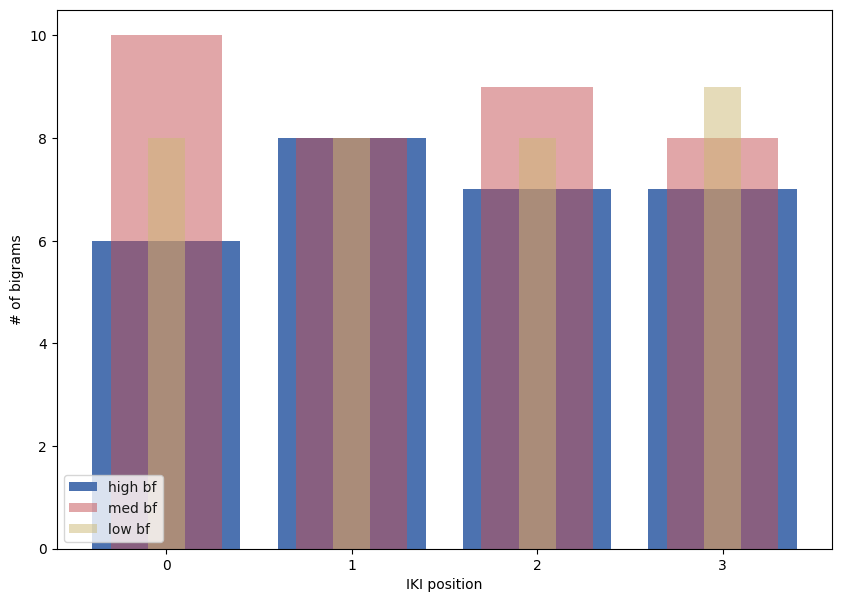

In [120]:
## plot showing distribution of bigram frequency types across each position in the string
locs = [0, 1, 2, 3]
type_list = ['high', 'med', 'low']
        
high = [6, 8, 7, 7]
med = [10, 8, 9, 8]
low = [8, 8, 8, 9]

plt.figure(figsize=(10, 7))
indices = np.arange(len(high))
width = 0.8

plt.bar(indices, high, width=width, 
        color='b', label='high bf')
plt.bar(indices, med, 
        width=0.75*width, color='r', alpha=0.5, label='med bf')
plt.bar(indices, low, 
        width=0.25*width, color='y', alpha=0.5, label='low bf')

plt.xticks([0, 1, 2, 3])
plt.xlabel("IKI position")
plt.ylabel("# of bigrams")

plt.legend(loc = 'lower left', labelcolor = 'k')

plt.show()

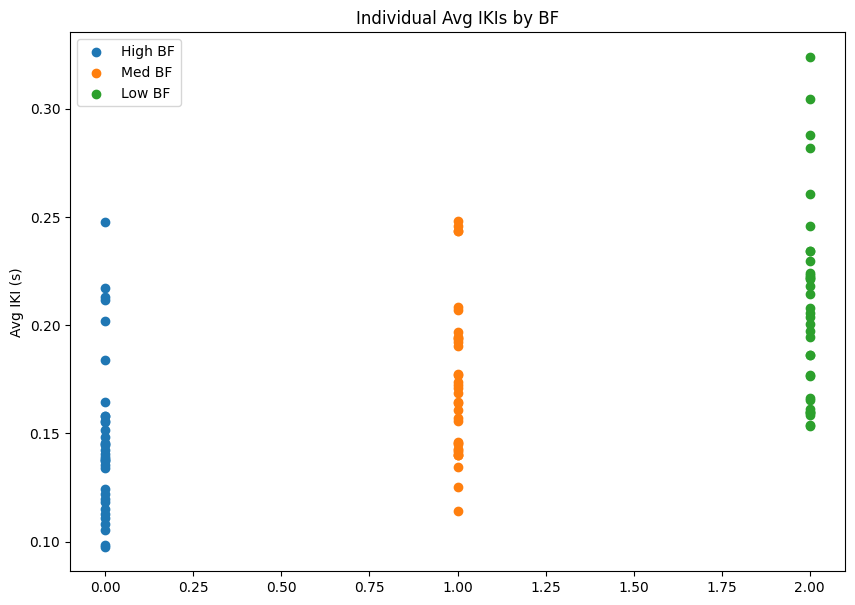

In [121]:
## Raster plot of indiv. MEAN IKI by BF

plt.figure(figsize=(10, 7))
highbf_scatter = plt.scatter([0] * len(indiv_means(all_bigrams, 'bigram', typ.highbf)['Avg IKI']), 
                              indiv_means(all_bigrams, 'bigram', typ.highbf)['Avg IKI'], 
                              label='High BF')
medbf_scatter = plt.scatter([1] * len(indiv_means(all_bigrams, 'bigram', typ.medbf)['Avg IKI']), 
                              indiv_means(all_bigrams, 'bigram', typ.medbf)['Avg IKI'], 
                              label='Med BF')
Lowbf_scatter = plt.scatter([2] * len(indiv_means(all_bigrams, 'bigram', typ.lowbf)['Avg IKI']), 
                              indiv_means(all_bigrams, 'bigram', typ.lowbf)['Avg IKI'], 
                              label='Low BF')

plt.xlabel("")
plt.ylabel("Avg IKI (s)")
plt.title("Individual Avg IKIs by BF")
plt.legend(loc= "best")

plt.show()

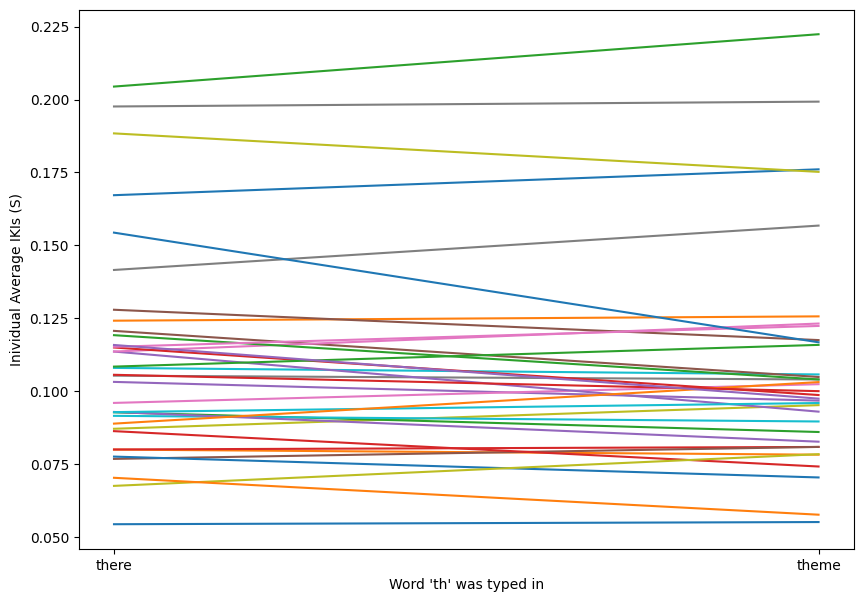

In [122]:
## plot comparing indidivuals' average IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

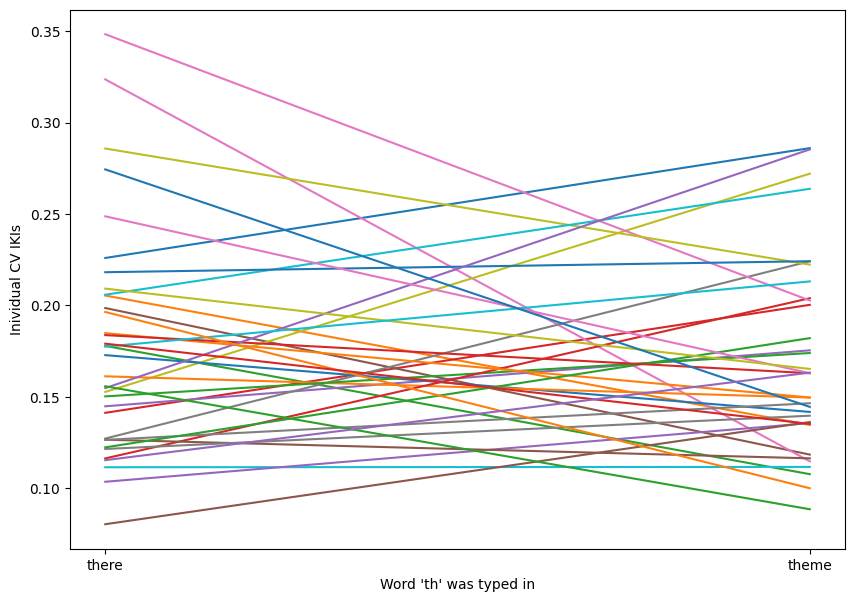

In [123]:
## plot comparing indidivuals' CV IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

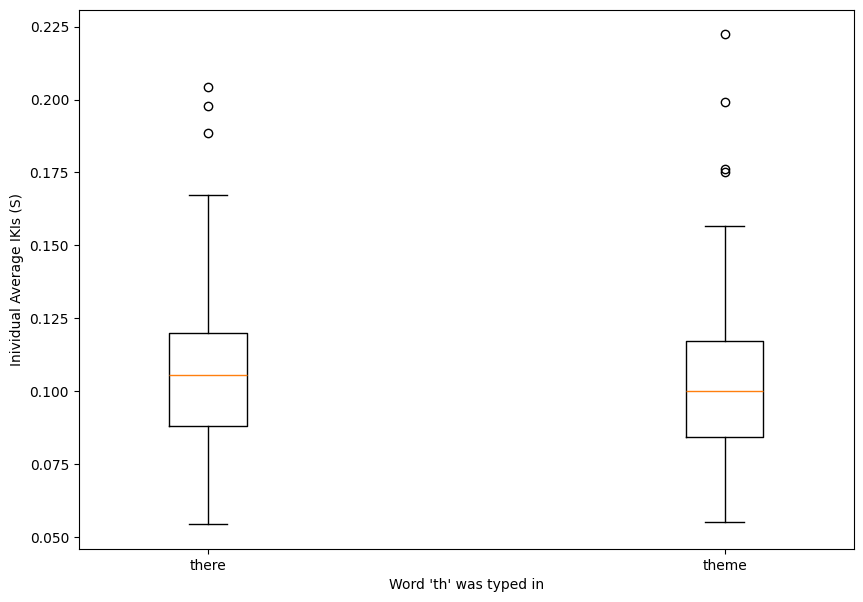

In [124]:
## box plot comparing indidivuals' average IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

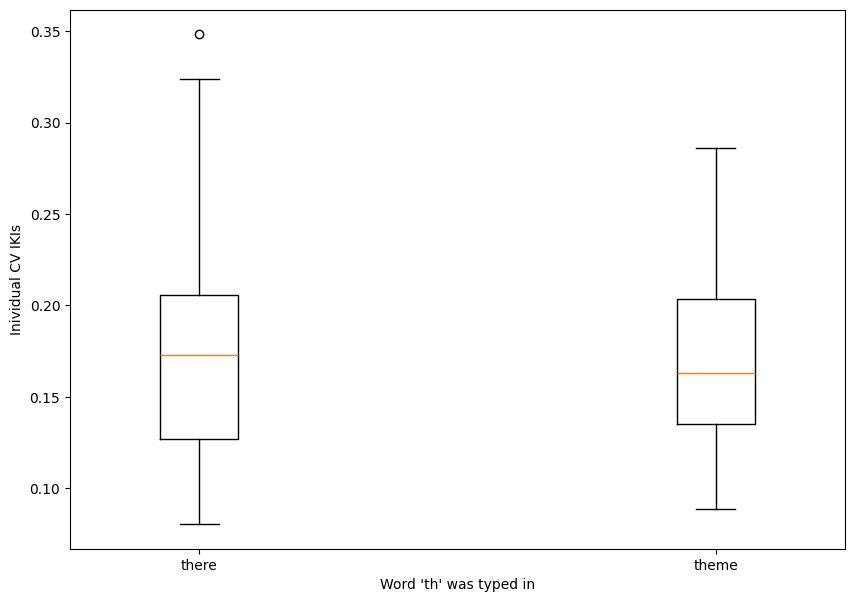

In [125]:
## box plot comparing indidivuals' CV IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

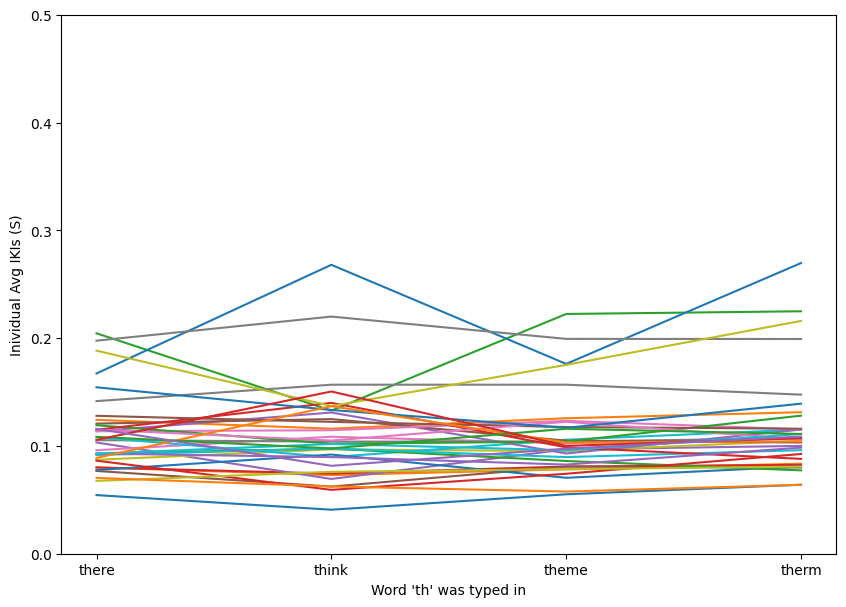

In [126]:
x = [2, 4, 6, 8]
D = (indiv_means_bybg('there', 'th')['mean'], indiv_means_bybg('think', 'th')['mean'], 
     indiv_means_bybg('theme', 'th')['mean'], indiv_means_bybg('therm', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Avg IKIs (S)")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

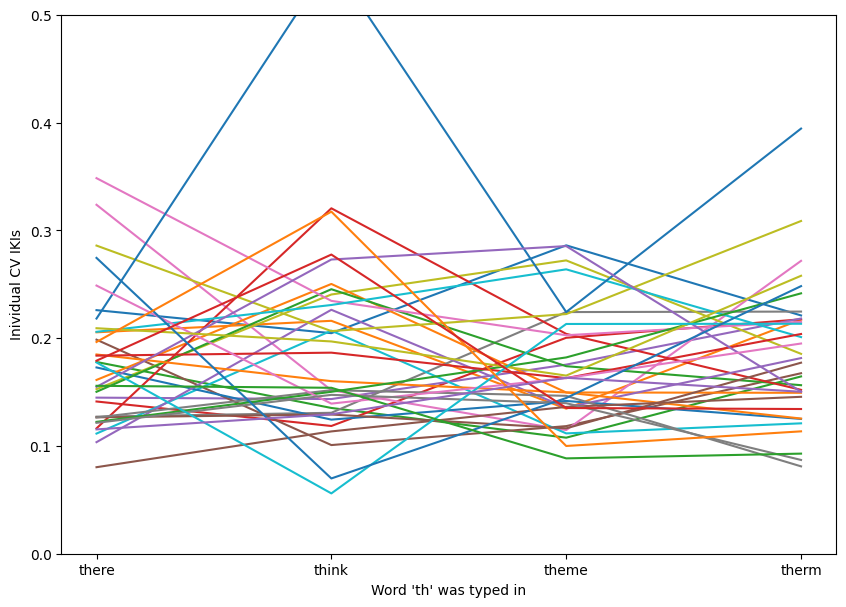

In [127]:
x = [2, 4, 6, 8]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('think', 'th')['variation'], 
     indiv_cvs_bybg('theme', 'th')['variation'], indiv_cvs_bybg('therm', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

## Not Useful Graphs - Variables by Word and Word Type (WF and Avg. BF)
___

In [128]:
# ## creating dataframe from 'cv_byword' function that is easy to plot
# cv_word = 'druze' # change this for which ever word you want to plot
# cv_byword_df = (pd.DataFrame(typ.cv_byword(cv_word, corr_rts)).drop(0)).reset_index(drop = True)

# ## plotting digraph latency variations by word (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(cv_byword_df, color='red', label=cv_word)
# # medwf_plot = plt.plot(cv_byword_df, color='red', label='There')

# ## Set general font size
# plt.rcParams['font.size'] = '25'

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Word")
# plt.legend(loc="best")

# plt.show()

In [129]:
# ## plotting digraph latency variations by wf_type (includes error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(typ.avg_cv(typ.highwf, all_rts), color='red', label='High WF')
# medwf_plot = plt.plot(typ.avg_cv(typ.medwf, all_rts), color='blue', label='Medium WF')
# lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, all_rts), color='green', label='Low WF')
# pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, all_rts), color='orange', label='Pseudo')

# ## Set tick font size
# # for label in (ax.get_xticklabels() + ax.get_yticklabels()):
# #     label.set_fontsize(25)

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Interval position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 1])
# plt.title("Average CV of Interkey Interval by Word Frequency (w/ error)", pad=30)
# plt.legend(loc="best")

# # plt.savefig('ian_iki.png')

# plt.show()

In [130]:
# ## plotting digraph latency variations by wf_type (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(typ.avg_cv(typ.highwf, corr_rts), color='red', label='High WF')
# medwf_plot = plt.plot(typ.avg_cv(typ.medwf, corr_rts), color='blue', label='Medium WF')
# lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, corr_rts), color='green', label='Low WF')
# pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, corr_rts), color='orange', label='Pseudo')


# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by wf_type (w/out error)")
# plt.legend(loc="best")

# plt.show()

In [131]:
# ## plotting digraph latency variations by Avg. BF type (includes error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highbf_plot = plt.plot(typ.avg_cv(typ.avg_highbf, all_rts), color='red', label='High bigram freq.')
# medbf_plot = plt.plot(typ.avg_cv(typ.avg_medbf, all_rts), color='blue', label='Medium bigram freq.')
# lowbf_plot = plt.plot(typ.avg_cv(typ.avg_lowbf, all_rts), color='green', label='Low bigram freq.')

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Avg. BF Type (w/ error)")
# plt.legend(loc="best")

# plt.show()

In [132]:
# ## plotting digraph latency variations by Avg. BF type (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highbf_plot = plt.plot(typ.avg_cv(typ.avg_highbf, corr_rts), color='red', label='High bigram freq.')
# medbf_plot = plt.plot(typ.avg_cv(typ.avg_medbf, corr_rts), color='blue', label='Medium bigram freq.')
# lowbf_plot = plt.plot(typ.avg_cv(typ.avg_lowbf, corr_rts), color='green', label='Low bigram freq.')


# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Avg. BF Type (w/out error)")
# plt.legend(loc="best")

# plt.show()

In [133]:
# ## 4-quadrant plot showing CV IKI distribution for IKI position in the string by WF (includes error, for all words not grouped)

# figure, axs = plt.subplots(2, 2, figsize=(20, 14))
# figure.suptitle('CV IKI Distribution by WF w/ error', y=0.95)

# axs[0, 0].boxplot((typ.cv_all(typ.highwf, all_rts).loc[:, 1:4]))
# axs[0, 0].set_title("High WF")
# axs[0, 0].set_ylim([-0.01, 1.5])
# axs[0, 1].boxplot((typ.cv_all(typ.medwf, all_rts).loc[:, 1:4]))
# axs[0, 1].set_title("Med WF")
# axs[0, 1].set_ylim([-0.01, 1.5])
# axs[1, 0].boxplot((typ.cv_all(typ.lowwf, all_rts).loc[:, 1:4]))
# axs[1, 0].set_title("Low WF")
# axs[1, 0].set_ylim([-0.01, 1.5])
# axs[1, 1].boxplot((typ.cv_all(typ.pseudo, all_rts).loc[:, 1:4]))
# axs[1, 1].set_title("Pseudo")
# axs[1, 1].set_ylim([-0.01, 1.5])

# for ax in axs.flat:
#     ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

# ## Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [134]:
# ## 4-quadrant plot showing CV IKI distribution of IKI position in the string by Avg. BF (includes error, for all words not grouped)

# figure, axs = plt.subplots(2, 2, figsize=(20, 14))
# figure.suptitle('CV IKI Distribution by Avg. BF w/ error', y=0.95)

# axs[0, 0].boxplot((typ.cv_all(typ.avg_highbf, all_rts).loc[:, 1:4]))
# axs[0, 0].set_title("High BF")
# axs[0, 0].set_ylim([-0.01, 1.5])
# axs[0, 1].boxplot((typ.cv_all(typ.avg_medbf, all_rts).loc[:, 1:4]))
# axs[0, 1].set_title("Med BF")
# axs[0, 1].set_ylim([-0.01, 1.5])
# axs[1, 0].boxplot((typ.cv_all(typ.avg_lowbf, all_rts).loc[:, 1:4]))
# axs[1, 0].set_title("Low BF")
# axs[1, 0].set_ylim([-0.01, 1.5])

# for ax in axs.flat:
#     ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

# ## Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

# WIP
___

In [135]:
## running wilcoxon rank-sum test between IKI and CV IKI
# ranksums(indiv_means(tight_bgs, 'bigram', typ.highbf)['Avg IKI'], 
#          indiv_avgcvs(tight_bgs, 'bigram', typ.highbf)['Avg CV IKI'])

# ranksums(indiv_means(all_bigrams, 'bigram', typ.highbf)['Avg IKI'],
#          indiv_avgcvs(all_bigrams, 'bigram', typ.highbf)['Avg CV IKI'])

In [136]:
# def delta_iki(bigram, string):
#     all_deltas = []
#     for sub in ID_list:
#         sub_df = tight_bgs[(tight_bgs.sID == sub) & (tight_bgs.bigram == bigram) & (tight_bgs.string == string)]
#         deltas = [sub]
#         for trial in range(0, len(sub_df) - 1):
#             deltas.append(sub_df.loc[trial + 1, 'IKI'] - sub_df.loc[trial, 'IKI']) ## depends on column position
#         all_deltas.append(deltas)
#     all_deltas = pd.DataFrame(all_deltas)
#     all_deltas = all_deltas.transpose()
#     return all_deltas

In [137]:
# def iki_change_bysub(bigram, string):
#     all_subs = pd.DataFrame()
#     for sub in ID_list:
#         sub_df = tight_bgs[(tight_bgs.sID == sub) & (tight_bgs.bigram == bigram) & (tight_bgs.string == string)]
#         ikis = sub_df['IKI'].tolist()
#         while len(ikis) != 10:
#             ikis.append(np.nan)
#         all_subs[sub] = ikis
#     return all_subs
        
# iki_change_bysub('pu', 'puppy')

In [138]:
##plotting IKI accross repetitions for each individual

# df = iki_change_bysub('pu', 'puppy')

# df.plot(figsize=(10, 7))

# # plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
# plt.xlabel("Repetition #")
# plt.ylabel("IKI (s)")
# # plt.ylim([0, 0.8])
# plt.title("")
# plt.legend().remove()

# plt.show()

In [139]:
## plotting average IKI for a particular bigram in a particular word across repetitions (for correct trials only)

# plt.figure(figsize=(10, 7))
# for bg in typ.lowbf:
#     by_bg = corr_trials_bybg[corr_trials_bybg.bigram == bg]
#     rep_ikis = []
#     for n in range(0, 9):
#         all_reps = by_bg[by_bg['rep #'] == n]
#         avg_iki_byrep = all_reps['IKI'].mean()
#         rep_ikis.append(avg_iki_byrep)

#         plt.plot(rep_ikis)

#         # plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
#         plt.xlabel("Repetition #")
#         plt.ylabel("Avg IKI (s)")
#         # plt.ylim([0, 0.8])
#         plt.title("")
#         # plt.legend().remove()

# plt.show()

In [140]:
# yk_df = delta_iki('dk', 'vodka')[1:]

# yk_df.plot(figsize=(10, 7))

# # plt.xticks(ticks = (1, 2, 3, 4, 5 ,6 ,7, 8), labels=('1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9'))
# plt.xlabel("Inter-repetition position")
# plt.ylabel("Delta IKI (s)")
# # plt.ylim([0, 0.8])
# plt.title("")
# plt.legend(loc="best")

# plt.show()

In [141]:
# def indiv_means_bgonly(bigram):
#     means = pd.DataFrame()
#     DF = tight_bgs[tight_bgs['bigram'] == bigram]
#     for sID in ID_list:
#         indiv = DF[DF['sID'] == sID]
#         means = means.append({'ID':sID, 'bigram':bigram, 'Avg IKI':(indiv['IKI']).mean()}, ignore_index=True)
#     return means

# def indiv_cvs_bgonly(bigram):
#     cvs = pd.DataFrame()
#     DF = tight_bgs[tight_bgs['bigram'] == bigram]
#     for sID in ID_list:
#         indiv = DF[DF['sID'] == sID]
#         cvs = cvs.append({'ID':sID, 'bigram':bigram, 'CV IKI':variation(indiv['IKI'])}, ignore_index=True)
#     return cvs

In [142]:
# all_indiv_means = pd.DataFrame()
# for bigram in typ.bg_freqs['Bigrams']:
#     all_indiv_means = all_indiv_means.append(indiv_means_bgonly(bigram), ignore_index=True).dropna(axis = 0)

# all_indiv_cvs = pd.DataFrame()
# for bigram in typ.bg_freqs['Bigrams']:
#     all_indiv_cvs = all_indiv_cvs.append(indiv_cvs_bgonly(bigram), ignore_index=True).dropna(axis = 0)

In [143]:
## plot of individual avg iki values by bigram

# fig, ax = plt.subplots(figsize=(50, 30))

# for bigram in typ.bg_freqs['Bigrams']:
#     for sub in ID_list:
#         bg_df = all_indiv_means[all_indiv_means.ID == sub]
#     # bg_df = all_indiv_means[all_indiv_means.ID == 83]
#         ax.plot(bg_df['bigram'], bg_df['Avg IKI'])

# plt.xlabel("Chosen Bigrams by Bigram Freq.")
# plt.ylabel("Avg Individual IKI (s)")
# plt.title("")
# plt.xticks(np.arange(70), bg_df['bigram'])
# # plt.legend(loc= "best")
# plt.ylim([0, 0.4])
# # plt.ylim([0.04775, 0.04825])

# plt.show()

In [144]:
## plot of individual cv iki values by bigram

# fig, ax = plt.subplots(figsize=(50, 30))

# for bigram in typ.bg_freqs['Bigrams']:
#     for sub in ID_list:
#         bg_df = all_indiv_cvs[all_indiv_cvs.ID == sub]
#     # bg_df = all_indiv_means[all_indiv_means.ID == 83]
#         ax.plot(bg_df['bigram'], bg_df['CV IKI'])

# plt.xlabel("Chosen Bigrams by Bigram Freq.")
# plt.ylabel("Avg Individual IKI (s)")
# plt.title("")
# plt.xticks(np.arange(70), bg_df['bigram'])
# # plt.legend(loc= "best")
# plt.ylim([0, 1])
# # plt.ylim([0.04775, 0.04825])

# plt.show()

In [145]:
# th_means = pd.concat([indiv_means_bybg('there', 'th'), indiv_means_bybg('think', 'th'), indiv_means_bybg('theme', 'th'), indiv_means_bybg('therm', 'th')]
#                      , ignore_index=True)
# print(th_means)

# # print(AnovaRM(data=th_means, depvar='Avg IKI', subject='ID', within=['String']).fit())

In [146]:
# th_cvs = pd.concat([indiv_cvs('there', 'th'), indiv_cvs('think', 'th'), indiv_cvs('theme', 'th'), indiv_cvs('therm', 'th')]
#                      , ignore_index=True)

# print(AnovaRM(data=th_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())

In [147]:
# th_position_means = pd.concat([indiv_means('therm', 'th'), indiv_means('tithe', 'th')], ignore_index=True)

# print(AnovaRM(data=th_position_means, depvar='Avg IKI', subject='ID', within=['String']).fit()) 

In [148]:
# th_position_cvs = pd.concat([indiv_cvs('therm', 'th'), indiv_cvs('tithe', 'th')], ignore_index=True)

# print(AnovaRM(data=th_position_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())

In [149]:
# th_wf_means = pd.concat([indiv_means('tithe', 'th'), indiv_means('edthe', 'th')], ignore_index=True)

# print(AnovaRM(data=th_wf_means, depvar='Avg IKI', subject='ID', within=['String']).fit())

In [150]:
# th_wf_cvs = pd.concat([indiv_cvs('tithe', 'th'), indiv_cvs('edthe', 'th')], ignore_index=True)

# print(AnovaRM(data=th_wf_cvs, depvar='CV IKI', subject='ID', within=['String']).fit())

# MRS Correlation
___

In [151]:
## importing GABA quanitification .csv
## data table is edited to exclude certain data point prior to import
GABA_quant = pd.read_csv(r'/Users/rubi/'
                        'Desktop/Github/typingexp/typing_task_analysis/Typ_GABA_quant_filtered.csv')
GABA_quant_nofilt = pd.read_csv(r'/Users/rubi/'
                        'Desktop/Github/typingexp/typing_task_analysis/Typ_GABA_quant.csv')

GABA_sIDs = GABA_quant.sID.unique() ## making list of sIDs with GABA data

In [152]:
## filtering corr_bgs to only have subjects with GABA data
GABA_corr_bgs = corr_bgs[corr_bgs.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
GABA_corr_trials = corr_trials[corr_trials.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
GABA_od_avgs = od_avgs[od_avgs.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
GABA_totaldeltaiki = mean_totaldeltas[mean_totaldeltas.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
allmean_GABA_totaldeltaiki = pd.DataFrame(GABA_totaldeltaiki.groupby('sID').mean_totaldeltaiki.agg('mean')).reset_index()

In [153]:
## calculating mean and sd iki across all bigram categories for GABA subjects only  
GABA_means = pd.DataFrame(GABA_corr_bgs.groupby('sID').IKI.agg(['mean'])).reset_index().rename(columns = {'mean':'all_mean_iki'})
GABA_sds = pd.DataFrame(GABA_corr_bgs.groupby('sID').IKI.agg(['std'])).reset_index().rename(columns = {'std':'all_sd_iki'})

In [154]:
## making filtered dataframes for the voxels of interest
# GABA_Rthal = GABA_df[(GABA_df.voxel == 'R_thal')].sort_values('sID').reset_index(drop=True)
# GABA_Lthal = GABA_df[(GABA_df.voxel == 'L_thal')].sort_values('sID').reset_index(drop=True)
# GABA_RLthal = pd.concat([GABA_Rthal, GABA_Lthal])

# GABA_RM1 = GABA_df[(GABA_df.voxel == 'R_M1')].sort_values('sID').reset_index(drop=True)
# GABA_LM1 = GABA_df[(GABA_df.voxel == 'L_M1')].sort_values('sID').reset_index(drop=True)
# GABA_RLM1 = pd.concat([GABA_RM1, GABA_LM1])

# # l_voxs = pd.concat([GABA_Lthal, GABA_LM1]).reset_index(drop=True)
# # r_voxs = pd.concat([GABA_Rthal, GABA_RM1]).reset_index(drop=True)

In [155]:
GABA_quant_nofilt.groupby('voxel').mean(numeric_only=True).reset_index()

voxel  A1_GABA_Cr  A2_GABA_Cr  Mean_GABA_Cr     A1_FE     A2_FE   Mean_FE
0    L_M1    0.111644    0.110879      0.111262  4.132595  4.407106  4.269851
1  L_thal    0.456624    0.203133      0.329878  5.871319  8.587859  7.229589
2    R_M1    0.112062    0.114306      0.113184  4.327749  4.377127  4.352438
3  R_thal    8.925350    0.135939      4.530645  9.024096  8.474899  8.749498
4     occ    0.105488    0.103158      0.104323  3.261017  3.230083  3.245550

In [156]:
A1_meanGABA = GABA_quant_nofilt.groupby(['voxel']).A1_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'A1_meanGABA'})
A2_meanGABA = GABA_quant_nofilt.groupby(['voxel']).A2_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'A2_meanGABA'})
both_meanGABA = GABA_quant_nofilt.groupby(['voxel']).Mean_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'both_meanGABA'})
A1_FE = GABA_quant_nofilt.groupby(['voxel']).A1_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'A1_meanFE'})
A2_FE = GABA_quant_nofilt.groupby(['voxel']).A2_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'A2_meanFE'})
both_FE = GABA_quant_nofilt.groupby(['voxel']).Mean_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'both_meanFE'})

by_voxel = pd.concat([A1_meanGABA, 
                      A2_meanGABA['A2_meanGABA'], 
                      both_meanGABA['both_meanGABA'], 
                      A1_FE['A1_meanFE'], 
                      A2_FE['A2_meanFE'], 
                      both_FE['both_meanFE']], 
                      axis = 1)

L_thal_shims = {'A1_shims' : [17.6, 21.5, 19, 29, 17.4, 16.9, 20.6, 23.4, 22, 19.9], 
                'A2_ shims' : [float('nan'), 21.2, 18.8, 28.9, float('nan'), 16.8, 21.4, 22.4, 22, 20]}
Lthal_shims = pd.DataFrame(L_thal_shims).reset_index(drop = True)

only_Lthal = GABA_quant_nofilt[GABA_quant_nofilt.voxel == 'L_thal'].reset_index(drop = True)
only_Lthal = pd.concat([only_Lthal, Lthal_shims], axis = 1)
only_Lthal = only_Lthal.drop(['voxel', 'A1_GABA_Cr', 'A2_GABA_Cr', 'Mean_GABA_Cr'], axis='columns')


R_thal_shims = {'A1_shims' : [18.9, 21.7, 18.3, 30.2, 18.1, 17.8, 19.1, 20.1, 24.3, 21.5],
                'A2_ shims' : [float('nan'), 20.7, 18.4, 31.2, float('nan'), 17.7, 19.8, 19.8, 23.1, 22]}
Rthal_shims = pd.DataFrame(R_thal_shims).reset_index(drop = True)
only_Rthal = GABA_quant_nofilt[GABA_quant_nofilt.voxel == 'R_thal'].reset_index(drop = True)
only_Rthal = pd.concat([only_Rthal, Rthal_shims], axis = 1)
only_Rthal = only_Rthal.drop(['voxel', 'A1_GABA_Cr', 'A2_GABA_Cr', 'Mean_GABA_Cr'], axis='columns')

only_Rthal

# A1_meanGABA = only_thal.groupby(['sID']).A1_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'A1_meanGABA'})
# A2_meanGABA = only_thal.groupby(['sID']).A2_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'A2_meanGABA'})
# both_meanGABA = only_thal.groupby(['sID']).Mean_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'both_meanGABA'})
# A1_FE = GABA_quant_nofilt.groupby(['sID']).A1_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'A1_meanFE'})
# A2_FE = GABA_quant_nofilt.groupby(['sID']).A2_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'A2_meanFE'})
# both_FE = GABA_quant_nofilt.groupby(['sID']).Mean_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'both_meanFE'})

# by_sID = pd.concat([A1_meanGABA, 
#                       A2_meanGABA['A2_meanGABA'], 
#                       both_meanGABA['both_meanGABA'], 
#                       A1_FE['A1_meanFE'], 
#                       A2_FE['A2_meanFE'], 
#                       both_FE['both_meanFE']], 
#                       axis = 1)

sID      A1_FE      A2_FE    Mean_FE  A1_shims  A2_ shims
0   s09  19.649431  13.136471  16.392951      18.9        NaN
1   s20   7.422911   5.925922   6.674416      21.7       20.7
2  s209   6.425226   4.457108   5.441167      18.3       18.4
3  s261   9.712004   8.336442   9.024223      30.2       31.2
4  s262  11.025388   6.907043   8.966216      18.1        NaN
5  s263   5.019050   4.072551   4.545801      17.8       17.7
6  s276   9.413257  10.374434   9.893846      19.1       19.8
7  s278  15.417160  12.515338  13.966249      20.1       19.8
8  s279   4.092185   6.446441   5.269313      24.3       23.1
9  s282   2.064344  12.577245   7.320795      21.5       22.0

In [157]:
## making summary df with all relevant info
GABA_df = pd.concat([pd.DataFrame(GABA_sIDs),
                     indiv_means(GABA_corr_bgs, 'bigram', typ.lowbf)['Avg IKI'],
                     indiv_means(GABA_corr_bgs, 'bigram', typ.medbf)['Avg IKI'],
                     indiv_means(GABA_corr_bgs, 'bigram', typ.highbf)['Avg IKI'],
                     indiv_means(GABA_corr_bgs, 'bigram', list(typ.all_bigrams))['Avg IKI'],
                     GABA_means['all_mean_iki'],
                     indiv_avgsds(GABA_corr_bgs, 'bigram', typ.lowbf)['Avg SD IKI'],
                     indiv_avgsds(GABA_corr_bgs, 'bigram', typ.medbf)['Avg SD IKI'],
                     indiv_avgsds(GABA_corr_bgs, 'bigram', typ.highbf)['Avg SD IKI'],
                     indiv_avgsds(GABA_corr_bgs, 'bigram', list(typ.all_bigrams))['Avg SD IKI'],
                     GABA_sds['all_sd_iki'],
                     GABA_od_avgs[GABA_od_avgs['wf_type'] == 'pseudo']['onset_delay'].reset_index(drop=True),
                     GABA_od_avgs[GABA_od_avgs['wf_type'] == 'lowwf']['onset_delay'].reset_index(drop=True),
                     GABA_od_avgs[GABA_od_avgs['wf_type'] == 'medwf']['onset_delay'].reset_index(drop=True),
                     GABA_od_avgs[GABA_od_avgs['wf_type'] == 'medwf']['onset_delay'].reset_index(drop=True),
                     indiv_meandeltaod(GABA_corr_trials, typ.pseudo)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, typ.lowwf)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, typ.medwf)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, typ.highwf)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, list(typ.all_bigrams))['mean_deltaod'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.pseudo)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.lowwf)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.medwf)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.highwf)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', list(typ.all_bigrams))['mean_deltaiki'],
                     GABA_totaldeltaiki[GABA_totaldeltaiki['wf_type'] == 'pseudo']['mean_totaldeltaiki'].reset_index(drop=True),
                     GABA_totaldeltaiki[GABA_totaldeltaiki['wf_type'] == 'low']['mean_totaldeltaiki'].reset_index(drop=True),
                     GABA_totaldeltaiki[GABA_totaldeltaiki['wf_type'] == 'med']['mean_totaldeltaiki'].reset_index(drop=True),
                     GABA_totaldeltaiki[GABA_totaldeltaiki['wf_type'] == 'high']['mean_totaldeltaiki'].reset_index(drop=True),
                     allmean_GABA_totaldeltaiki['mean_totaldeltaiki'].reset_index(drop=True),
                     GABA_quant[(GABA_quant.voxel == 'R_thal')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'L_thal')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'R_M1')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'L_M1')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr']],
                     axis=1).reset_index(drop=True)

labels = ['sID', 
          'low_mean_iki',
          'med_mean_iki',
          'high_mean_iki',
          'all_avg_mean_iki',
          'all_mean_iki',
          'low_sd_iki', 
          'med_sd_iki', 
          'high_sd_iki', 
          'all_avg_sd_iki',
          'all_sd_iki',
          'pseudo_od',
          'low_od',
          'med_od',
          'high_od',
          'pseudo_deltaod',
          'low_deltaod',
          'med_deltaod',
          'high_deltaod',
          'all_deltaod',
          'pseudo_deltaiki',
          'low_deltaiki',
          'med_deltaiki',
          'high_deltaiki',
          'all_deltaiki',
          'pseudo_totaldeltaiki',
          'low_totaldeltaiki',
          'med_totaldeltaiki',
          'high_totaldeltaiki',
          'all_totaldeltaiki',
          'R_thal_GABA', 
          'L_thal_GABA', 
          'R_M1_GABA', 
          'L_M1_GABA']
GABA_df.columns = labels

## adding column with difference between low and high sd iki
GABA_df['delta_sd_iki'] = GABA_df['low_sd_iki'] - GABA_df['high_sd_iki']
# GABA_df = GABA_df.drop(list(range(10,17)))
GABA_df

# print(np.std(GABA_df.low_sd_iki))
# print(np.std(GABA_df.med_sd_iki))
# print(np.std(GABA_df.high_sd_iki))

sID  low_mean_iki  med_mean_iki  high_mean_iki  all_avg_mean_iki  \
0   s09      0.171395      0.122012       0.100771          0.129063   
1   s20      0.238092      0.194401       0.142184          0.188457   
2  s209      0.157214      0.137236       0.115906          0.135731   
3  s261      0.156836      0.139021       0.120911          0.137923   
4  s262      0.157754      0.138180       0.097326          0.129549   
5  s263      0.219075      0.186762       0.146160          0.182596   
6  s276      0.214389      0.163653       0.138764          0.170538   
7  s278      0.225491      0.179550       0.114645          0.168783   
8  s279      0.260474      0.246385       0.217313          0.240455   
9  s282      0.287024      0.244854       0.210510          0.245906   

   all_mean_iki  low_sd_iki  med_sd_iki  high_sd_iki  all_avg_sd_iki  ...  \
0      0.129063    0.044573    0.025628     0.026763        0.032624  ...   
1      0.188457    0.099776    0.073137     0.066516        0.081174  ...   
2      0.135731    0.042779    0.038085     0.038990        0.039955  ...   
3      0.137923    0.045107    0.030890     0.030722        0.035917  ...   
4      0.129549    0.055679    0.027952     0.021944        0.036511  ...   
5      0.182596    0.096552    0.067967     0.054457        0.075187  ...   
6      0.170538    0.047201    0.027393     0.030258        0.035076  ...   
7      0.168783    0.125241    0.081601     0.050351        0.090294  ...   
8      0.240455    0.047297    0.039509     0.039200        0.042215  ...   
9      0.245906    0.090177    0.070434     0.066855        0.076681  ...   

   pseudo_totaldeltaiki  low_totaldeltaiki  med_totaldeltaiki  \
0             -0.032003          -0.016366          -0.024434   
1             -0.023397          -0.022699          -0.019864   
2             -0.001610          -0.013960          -0.001248   
3             -0.036006          -0.023283          -0.027474   
4             -0.000021          -0.008322          -0.015344   
5             -0.060838          -0.082102           0.005879   
6              0.001081           0.011412           0.027990   
7             -0.057732          -0.024394          -0.019790   
8             -0.079980          -0.049007          -0.065408   
9             -0.134400          -0.080739          -0.060795   

   high_totaldeltaiki  all_totaldeltaiki  R_thal_GABA  L_thal_GABA  R_M1_GABA  \
0           -0.023671          -0.024119          NaN          NaN   0.116208   
1            0.011915          -0.013511     0.089429     0.111203   0.123186   
2           -0.001025          -0.004461     0.118660     0.115642   0.104354   
3           -0.040825          -0.031897     0.103932     0.102740   0.114475   
4           -0.006345          -0.007508     0.100087     0.107994   0.120235   
5            0.046828          -0.022558     0.118394     0.099615   0.114242   
6            0.024334           0.016204          NaN          NaN   0.111320   
7           -0.066662          -0.042145          NaN     0.118783   0.107660   
8           -0.054995          -0.062348     0.108836     0.116799   0.106534   
9           -0.022944          -0.074719          NaN     0.088200   0.113625   

   L_M1_GABA  delta_sd_iki  
0   0.113166      0.017810  
1   0.106227      0.033260  
2   0.105214      0.003789  
3   0.115246      0.014386  
4   0.114100      0.033735  
5   0.112255      0.042096  
6   0.109828      0.016943  
7   0.117194      0.074890  
8   0.101825      0.008097  
9   0.117565      0.023322  

[10 rows x 35 columns]

In [158]:
## testing if thalamus and M1 GABA are significantly different -- fix later, but they aren't
# meanRL_thal = (GABA_Rthal['Mean_GABA_Cr'] + GABA_Lthal['Mean_GABA_Cr'])/2
# meanRL_thal = pd.concat([GABA_Lthal['sID'], meanRL_thal], axis = 1)

# meanRL_M1 = (GABA_RM1['Mean_GABA_Cr'] + GABA_LM1['Mean_GABA_Cr'])/2
# meanRL_M1 = pd.concat([GABA_LM1['sID'], meanRL_M1], axis = 1)

# no_match = ~np.logical_or(np.isnan(meanRL_thal['Mean_GABA_Cr']), np.isnan(meanRL_M1['Mean_GABA_Cr']))

# meanRL_M1_match = meanRL_M1[no_match]
# meanRL_thal_match = meanRL_thal[no_match]

# stats.ttest_rel(meanRL_thal_match['Mean_GABA_Cr'], meanRL_M1_match['Mean_GABA_Cr'])

In [159]:
## making dataframes that are matched such that a paticipant will be excluded if they don't have data from both L and R thal voxels
# bad = ~np.logical_or(np.isnan(GABA_Rthal['Mean_GABA_Cr']), np.isnan(GABA_Lthal['Mean_GABA_Cr']))

# GABA_Lthal_match = GABA_Lthal[bad]
# GABA_Rthal_match = GABA_Rthal[bad]

# print(pearsonr(GABA_Lthal_match['Mean_GABA_Cr'], GABA_Rthal_match['Mean_GABA_Cr'])) ## comparing L and R thal GABA
# print(pearsonr(GABA_LM1['Mean_GABA_Cr'], GABA_RM1['Mean_GABA_Cr'])) ## comparing L and R M1 GABA


### FIX LATER

In [160]:
# print('L vs R thal')
# plt.figure()
# bg_freq = plt.scatter(GABA_Lthal['Mean_GABA_Cr'], GABA_Rthal['Mean_GABA_Cr'])

# plt.xlabel("L")
# plt.ylabel("R")
# plt.title("")

# plt.show()

# print('L vs R M1')
# plt.figure()
# bg_freq = plt.scatter(GABA_LM1['Mean_GABA_Cr'], GABA_RM1['Mean_GABA_Cr'])

# plt.xlabel("L")
# plt.ylabel("R")
# plt.title("")

# plt.show()

In [161]:
# creating lists of sIDs that have data for each category
Rthal_sIDs = GABA_df[~np.isnan(GABA_df.R_thal_GABA)].sID.unique()
Lthal_sIDs = GABA_df[~np.isnan(GABA_df.L_thal_GABA)].sID.unique()

In [162]:
## thal comparisons
# print('GABA correlated against low bf sds')
# # temp = indiv_avgsds(corr_trials_bybg, 'bigram', typ.lowbf)
# R_lowbf_sds = temp[temp.sID.isin(Rthal_sIDS)]
# L_lowbf_sds = temp[temp.sID.isin(Lthal_sIDS)]
# RL_lowbf_sds = pd.concat([R_lowbf_sds, L_lowbf_sds])
# # print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_lowbf_sds['Avg SD IKI']))
# # print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_RLthal['Mean_GABA_Cr'].dropna(), RL_lowbf_sds['Avg SD IKI']))

# print('GABA correlated against high bf sds')
# temp = indiv_avgsds(corr_trials_bybg, 'bigram', typ.highbf)
# R_highbf_sds = temp[temp.sID.isin(Rthal_sIDS)]
# L_highbf_sds = temp[temp.sID.isin(Lthal_sIDS)]
# RL_highbf_sds = pd.concat([R_highbf_sds, L_highbf_sds])
# # print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_highbf_sds['Avg SD IKI']))
# # print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_RLthal['Mean_GABA_Cr'].dropna(), RL_highbf_sds['Avg SD IKI']))

print('GABA correlated against all bf sds')
R_allbf_sds = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['all_avg_sd_iki']
L_allbf_sds = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['all_avg_sd_iki']
print(pearsonr(R_allbf_sds, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_allbf_sds, GABA_df.L_thal_GABA.dropna()))

print('GABA correlated against all bf mean ikis')
R_allbf_means = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['all_avg_mean_iki']
L_allbf_means = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['all_avg_mean_iki']
print(pearsonr(R_allbf_means, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_allbf_means, GABA_df.L_thal_GABA.dropna()))

print('GABA correlated against delta sd iki')
R_delta_sd = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['delta_sd_iki']
L_delta_sd = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['delta_sd_iki']
print(pearsonr(R_delta_sd, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_delta_sd, GABA_df.L_thal_GABA.dropna()))

# print('GABA correlated against low bf cvs')
# temp = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.lowbf)
# R_lowbf_cvs = temp[temp.sID.isin(Rthal_sIDs)]
# L_lowbf_cvs = temp[temp.sID.isin(Lthal_sIDs)]
# print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_lowbf_cvs['Avg CV IKI']))
# print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_cvs['Avg CV IKI']))

# print('GABA correlated against high bf cvs')
# temp = indiv_avgcvs(corr_trials_bybg, 'bigram', typ.highbf)
# R_highbf_cvs = temp[temp.sID.isin(Rthal_sIDS)]
# L_highbf_cvs = temp[temp.sID.isin(Lthal_sIDS)]
# print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_highbf_cvs['Avg CV IKI']))
# print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_cvs['Avg CV IKI']))

GABA correlated against all bf sds
PearsonRResult(statistic=-0.2160084574392989, pvalue=0.681026753749659)
PearsonRResult(statistic=-0.14751853240181945, pvalue=0.7273893747522384)
GABA correlated against all bf mean ikis
PearsonRResult(statistic=-0.031031664181903323, pvalue=0.953467444917701)
PearsonRResult(statistic=-0.3061914291110901, pvalue=0.46076485537777156)
GABA correlated against delta sd iki
PearsonRResult(statistic=-0.2955553883044144, pvalue=0.5695757406216769)
PearsonRResult(statistic=0.1282604203530258, pvalue=0.7621361681294703)


In [163]:
GABA_df.pseudo_totaldeltaiki

0   -0.032003
1   -0.023397
2   -0.001610
3   -0.036006
4   -0.000021
5   -0.060838
6    0.001081
7   -0.057732
8   -0.079980
9   -0.134400
Name: pseudo_totaldeltaiki, dtype: float64

In [164]:
## M1 comparisons
# print('GABA correlated against low bf sds')
# print(pearsonr(GABA_RM1['Mean_GABA_Cr'], lowbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_LM1['Mean_GABA_Cr'], lowbf_sds['Avg SD IKI']))

# print('GABA correlated against high bf sds')
# print(pearsonr(highbf_sds['Avg SD IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(highbf_sds['Avg SD IKI'], GABA_LM1['Mean_GABA_Cr']))

# print('GABA correlated against high bf cvs')
# print(pearsonr(highbf_cvs['Avg CV IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(highbf_cvs['Avg CV IKI'], GABA_LM1['Mean_GABA_Cr']))

# print('GABA correlated against low bf cvs')
# print(pearsonr(lowbf_cvs['Avg CV IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(lowbf_cvs['Avg CV IKI'], GABA_LM1['Mean_GABA_Cr']))

print('GABA correlated against all bf sds')
print(pearsonr(GABA_df.all_avg_sd_iki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_avg_sd_iki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all bf mean ikis')
print(pearsonr(GABA_df.all_avg_mean_iki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_avg_mean_iki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo od')
print(pearsonr(GABA_df.pseudo_od.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_od.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high od')
print(pearsonr(GABA_df.high_od.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_od.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo delta od')
print(pearsonr(GABA_df.pseudo_deltaod.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_deltaod.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high delta od')
print(pearsonr(GABA_df.high_deltaod.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_deltaod.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all delta od')
print(pearsonr(GABA_df.all_deltaod.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_deltaod.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo delta iki')
print(pearsonr(GABA_df.pseudo_deltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_deltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high delta iki')
print(pearsonr(GABA_df.high_deltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_deltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all delta iki')
print(pearsonr(GABA_df.all_deltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_deltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo total delta iki')
print(pearsonr(GABA_df.pseudo_totaldeltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_totaldeltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high total delta iki')
print(pearsonr(GABA_df.high_totaldeltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_totaldeltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all total delta iki')
print(pearsonr(GABA_df.all_totaldeltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_totaldeltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

GABA correlated against all bf sds
PearsonRResult(statistic=0.10526407055597196, pvalue=0.7722693862059371)
PearsonRResult(statistic=0.273413084115805, pvalue=0.4446493268835697)
GABA correlated against all bf mean ikis
PearsonRResult(statistic=-0.16475464230664993, pvalue=0.6492236752968855)
PearsonRResult(statistic=-0.18776355516325824, pvalue=0.6034439347718271)
GABA correlated against pseudo od
PearsonRResult(statistic=-0.048277753590652964, pvalue=0.8946382139751585)
PearsonRResult(statistic=-0.25458978551114614, pvalue=0.4777997013409352)
GABA correlated against high od
PearsonRResult(statistic=-0.0959414981828676, pvalue=0.7920491508751194)
PearsonRResult(statistic=-0.3481519746663251, pvalue=0.324209137941929)
GABA correlated against pseudo delta od
PearsonRResult(statistic=0.08222579589528689, pvalue=0.821342254582428)
PearsonRResult(statistic=-0.49434324712316274, pvalue=0.14639275714474267)
GABA correlated against high delta od
PearsonRResult(statistic=0.24641841131824788, p

ValueError: x and y must have the same length.

In [ ]:
## lowbf cvs against L_thal GABA

# plt.figure()
# bg_freq = plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_cvs['Avg CV IKI'])
# # plt.xlim([0.1, 0.13])
# plt.xlabel("GABA")
# plt.ylabel("CV")
# plt.title("lowbf cvs against L_thal GABA")

# plt.show()

In [ ]:
## lowbf cvs against L_M1 GABA

# plt.figure()
# bg_freq = plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), lowbf_cvs['Avg CV IKI'])
# plt.xlabel("GABA")
# plt.ylabel("CV")
# plt.title("")

# plt.show()

In [ ]:
## highbf cvs against L_thal GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_cvs['Avg CV IKI'], s = 70, color = 'black')
# plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean CV IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig('Lthal_highbfcv.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## highbf cvs against L_M1 GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), highbf_cvs['Avg CV IKI'], s = 70, color = 'black')
# plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean CV IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig('LM1_highbfcv.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## lowbf sds against L_thal GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
# plt.ylabel("Low Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig('Lthal_lowbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## lowbf sds against L_M1 GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), lowbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
# plt.ylabel("Low Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# # plt.ylim(0.04, 0.08)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig('LM1_lowbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
R_allbf_means

In [ ]:
GABA_df.L_thal_GABA.dropna()

In [ ]:
## all bf mean IKIs against L and R thalamus GABA
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(GABA_df.R_thal_GABA.dropna(), R_allbf_means, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_thal_GABA.dropna(), L_allbf_means, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean IKI (all Bigram Freqs.)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig('RLthal_allbfsd.png', dpi=300)
plt.show()

In [ ]:
## all bf mean IKIs against L and R M1 GABA
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_avg_mean_iki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_avg_mean_iki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean IKI", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig('RLthal_allbfsd.png', dpi=300)
plt.show()

In [ ]:
## all bf sds against L and R thalamus GABA
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(GABA_df.R_thal_GABA.dropna(), R_allbf_sds, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_thal_GABA.dropna(), L_allbf_sds, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean SD IKI (all BFs)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")
plt.grid(visible=None)

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig('RLthal_allbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## all bf sds against L and R M1 GABA
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_avg_sd_iki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_avg_sd_iki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean SD IKI", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")
plt.grid(visible=None)

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

plt.legend(fontsize = '17',loc="lower left", facecolor = 'black')

plt.savefig('RLM1_allbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## highbf sds against L_thal GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig('Lthal_highbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## highbf sds against L_M1 GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), highbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# # plt.xlim([0.1, 0.12])
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig('LM1_highbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## all delta ods against L and R M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_deltaod, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_deltaod, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean Δ Onset Delay (s)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = '17',loc="lower left")

plt.savefig((save_dir + '/RLM1_alldeltaod.png'), dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
# all delta ikis against L and R M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_deltaiki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_deltaiki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean Δ IKI (s)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = '17',loc="lower left")

plt.savefig((save_dir + '/RLM1_alldeltaiki.png'), dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
# all total delta ikis against L and R M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_totaldeltaiki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_totaldeltaiki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean Total Δ IKI (s)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = '17',loc="lower left")

plt.savefig((save_dir + '/RLM1_alldeltaiki.png'), dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

## Graphs for F31

In [ ]:
ten_sub_list = ['s181', 's182', 's183', 's189', 's190', 
           's198', 's207', 's209', 's210', 's212']

ten_sub = corr_trials_bybg[corr_trials_bybg.sID.isin(ten_sub_list)].reset_index()

In [ ]:
## individual IKI means by BF (correct trials only) PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_means(ten_sub, 'bigram', typ.lowbf)['Avg IKI'], 
     indiv_means(ten_sub, 'bigram', typ.medbf)['Avg IKI'],
     indiv_means(ten_sub, 'bigram', typ.highbf)['Avg IKI'])
means = (np.mean(indiv_means(ten_sub, 'bigram', typ.lowbf)['Avg IKI']),
         np.mean(indiv_means(ten_sub, 'bigram', typ.medbf)['Avg IKI']),
         np.mean(indiv_means(ten_sub, 'bigram', typ.highbf)['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')
    
plt.xlim([1.5, 6.5])
plt.ylim([0.08, 0.4])
plt.xticks(x, ('', '', ''), fontsize = 24)
plt.xticks(x, ('Low', 'Med', 'High'))
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean IKI (s)", labelpad=15, fontsize = 24)
plt.title("")
plt.legend(fontsize = 17, loc="lower left")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('F31_indiv_mean_ikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## using bigrams sorted by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_avgcvs(ten_sub, 'bigram', typ.lowbf)['Avg CV IKI'], 
     indiv_avgcvs(ten_sub, 'bigram', typ.medbf)['Avg CV IKI'], 
     indiv_avgcvs(ten_sub, 'bigram', typ.highbf)['Avg CV IKI'])
means = (np.mean(indiv_avgcvs(ten_sub, 'bigram', typ.lowbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(ten_sub, 'bigram', typ.medbf)['Avg CV IKI']), 
         np.mean(indiv_avgcvs(ten_sub, 'bigram', typ.highbf)['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.10, 0.4])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean CV IKI (%)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('F31_indiv_cvikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## individual MEAN SD IKI by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_avgsds(ten_sub, 'bigram', typ.lowbf)['Avg SD IKI'], 
     indiv_avgsds(ten_sub, 'bigram', typ.medbf)['Avg SD IKI'],
     indiv_avgsds(ten_sub, 'bigram', typ.highbf)['Avg SD IKI'])
means = (np.mean(indiv_avgsds(ten_sub, 'bigram', typ.lowbf)['Avg SD IKI']), 
         np.mean(indiv_avgsds(ten_sub, 'bigram', typ.medbf)['Avg SD IKI']),
         np.mean(indiv_avgsds(ten_sub, 'bigram', typ.highbf)['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.0, 0.10])
plt.xticks(x, ('', '', ''), fontsize = 24)
# plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
# plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean SD IKI (s)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('F31_indiv_avgsds_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
incorr_ten_sub = incorr_bgs[incorr_bgs.sID.isin(ten_sub_list)].reset_index()

plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_error(incorr_ten_sub, 'bigram', typ.lowbf)['Total Error'], 
     indiv_error(incorr_ten_sub, 'bigram', typ.medbf)['Total Error'],
     indiv_error(incorr_ten_sub, 'bigram', typ.highbf)['Total Error'])

means = (np.mean(indiv_error(incorr_ten_sub, 'bigram', typ.lowbf)['Total Error']), 
         np.mean(indiv_error(incorr_ten_sub, 'bigram', typ.medbf)['Total Error']),
         np.mean(indiv_error(incorr_ten_sub, 'bigram', typ.highbf)['Total Error']))

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

plt.ylim([-1, 22])
plt.xlim([1.5, 6.5])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Indiv. Total Error", labelpad=15, fontsize = 24)

plt.title("")
# plt.legend(fontsize = 17, loc="best", facecolor = "black")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig('F31_meanerr_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## plotting BF distribution of data set -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

violin = ax.violinplot(D, [2, 4, 6], showmeans= True)

for pc in violin["bodies"]:
    pc.set_facecolor("blue")
    pc.set_edgecolor("black")
    pc.set_alpha(0.5)

# boxprops = dict(linestyle='-', linewidth=2, color = 'black')
# whiskerprops = dict(linewidth=2, color = 'black')
# capprops = dict(linewidth=2, color = 'black')
# flierprops = dict(markerfacecolor='royalblue', markersize=10)
# medianprops = dict(linewidth=2, color='red')

# ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
#           flierprops=flierprops, medianprops=medianprops)


plt.xlim([1, 7])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency (10 mil)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.yaxis.offsetText.set_fontsize(18)
ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig('F31_bf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

In [ ]:
## anova for sds (by bg freq)
high_sd = indiv_avgsds(ten_sub, 'bigram', typ.highbf)
high_sd['bf_type'] = 'high'
med_sd = indiv_avgsds(ten_sub, 'bigram', medbf_norep)
med_sd['bf_type'] = 'med'
low_sd = indiv_avgsds(ten_sub, 'bigram', lowbf_norep)
low_sd['bf_type'] = 'low'

sds = pd.concat([high_sd, med_sd, low_sd], ignore_index=True)
# print(sds)

sd_anova = pg.rm_anova(sds, 'Avg SD IKI', 'bf_type', 'sID')
print(sd_anova)

pg.pairwise_tukey(sds, 'Avg SD IKI', 'bf_type', effsize='cohen')